Your objective is to build a series of scatter plots to showcase the following relationships:

- Temperature (F) vs. Latitude
- Humidity (%) vs. Latitude
- Cloudiness (%) vs. Latitude
- Wind Speed (mph) vs. Latitude

Your final notebook must:

Randomly select at least 500 unique (non-repeat) cities based on latitude and longitude.
Perform a weather check on each of the cities using a series of successive API calls.
Include a print log of each city as it's being processed with the city number, city name, and requested URL.
Save both a CSV of all data retrieved and png images for each scatter plot.
As final considerations:

You must use the Matplotlib and Seaborn libraries.
You must include a written description of three observable trends based on the data.
You must use proper labeling of your plots, including aspects like: Plot Titles (with date of analysis) and Axes Labels.
You must include an exported markdown version of your Notebook called  README.md in your GitHub repository.
See Example Solution for a reference on expected format.

In [1]:
# -----------------------------------------------------------------------------------
# Step 1: Import the modules 
# -----------------------------------------------------------------------------------
import seaborn as sns
import json
import matplotlib.pyplot as plt
import requests as req
import pandas as pd
import random as rd
from citipy import citipy
from localenv import apiKey

In [2]:
# -----------------------------------------------------------------------------------
# Step 2: Generate a city list without duplicates using citipy
# -----------------------------------------------------------------------------------

# pull in and create a dataframe with a list of all the available cities
availableCities_set = set(pd.read_json('city.list.json',orient='records')['name'])

# create counter
i = 0

#create city list
city_list = []

while i < 500:
    # set random lat and long
    latitude = rd.uniform(-90.0,90.0)
    longitude = rd.uniform(-180.0,180.0)

    # try to pull in a random value
    city = [citipy.nearest_city(latitude,longitude).city_name, citipy.nearest_city(latitude,longitude).country_code]
    print(city)
    if city_list.count(city) == 0:        
        if city[0] in availableCities_set:
            city_list.append(city)
            i += 1
            
print(city_list)

['lebu', 'cl']
['rikitea', 'pf']
['taolanaro', 'mg']
['zhigansk', 'ru']
['tiksi', 'ru']
['luceville', 'ca']
['albany', 'au']
['punta arenas', 'cl']
['mergui', 'mm']
['yellowknife', 'ca']
['kaitangata', 'nz']
['nanortalik', 'gl']
['mataura', 'pf']
['klaksvik', 'fo']
['jamestown', 'sh']
['manta', 'ec']
['rikitea', 'pf']
['ushuaia', 'ar']
['rikitea', 'pf']
['khudumelapye', 'bw']
['arraial do cabo', 'br']
['norman wells', 'ca']
['kahului', 'us']
['ushuaia', 'ar']
['imbituba', 'br']
['khatanga', 'ru']
['yellowknife', 'ca']
['vaini', 'to']
['iqaluit', 'ca']
['puerto ayora', 'ec']
['norman wells', 'ca']
['arraial do cabo', 'br']
['busselton', 'au']
['ust-tsilma', 'ru']
['albany', 'au']
['busselton', 'au']
['berlevag', 'no']
['barentsburg', 'sj']
['busselton', 'au']
['penzance', 'gb']
['pitimbu', 'br']
['new norfolk', 'au']
['karabanovo', 'ru']
['vaini', 'to']
['saleaula', 'ws']
['conde', 'br']
['kaitangata', 'nz']
['igarka', 'ru']
['salalah', 'om']
['khash', 'ir']
['rikitea', 'pf']
['bethel',

['arraial do cabo', 'br']
['luderitz', 'na']
['naze', 'jp']
['maturin', 've']
['cape town', 'za']
['kerman', 'ir']
['tuktoyaktuk', 'ca']
['kapaa', 'us']
['lushunkou', 'cn']
['yellowknife', 'ca']
['hilo', 'us']
['new norfolk', 'au']
['noumea', 'nc']
['bambous virieux', 'mu']
['mataura', 'pf']
['barrow', 'us']
['barentsburg', 'sj']
['busselton', 'au']
['hami', 'cn']
['kodiak', 'us']
['bolungarvik', 'is']
['laguna', 'br']
['east london', 'za']
['khomutovka', 'ru']
['usoke', 'tz']
['rocha', 'uy']
['albany', 'au']
['kapaa', 'us']
['kerman', 'ir']
['tsihombe', 'mg']
['faanui', 'pf']
['caravelas', 'br']
['busselton', 'au']
['barrow', 'us']
['busselton', 'au']
['illoqqortoormiut', 'gl']
['vao', 'nc']
['ponta do sol', 'cv']
['lagunas', 'pe']
['dwarka', 'in']
['ghanzi', 'bw']
['carnarvon', 'au']
['hilo', 'us']
['faanui', 'pf']
['barrow', 'us']
['rikitea', 'pf']
['rikitea', 'pf']
['lebu', 'cl']
['barentsburg', 'sj']
['punta arenas', 'cl']
['loa janan', 'id']
['rosita', 'ni']
['illoqqortoormiut', 

['cidreira', 'br']
['saint-philippe', 're']
['ponta do sol', 'pt']
['rikitea', 'pf']
['mys shmidta', 'ru']
['cabo san lucas', 'mx']
['nadym', 'ru']
['mataura', 'pf']
['dikson', 'ru']
['rikitea', 'pf']
['saint-philippe', 're']
['caucaia', 'br']
['zaigrayevo', 'ru']
['bengkulu', 'id']
['helena', 'us']
['jamestown', 'sh']
['punta arenas', 'cl']
['padang', 'id']
['solotcha', 'ru']
['provideniya', 'ru']
['saskylakh', 'ru']
['puerto ayora', 'ec']
['gusev', 'ru']
['esperance', 'au']
['saint-philippe', 're']
['punta arenas', 'cl']
['nurota', 'uz']
['provideniya', 'ru']
['ushuaia', 'ar']
['cap malheureux', 'mu']
['ushuaia', 'ar']
['kangundo', 'ke']
['jamestown', 'sh']
['feni', 'bd']
['ushuaia', 'ar']
['longyearbyen', 'sj']
['alofi', 'nu']
['lethem', 'gy']
['zyryanovsk', 'kz']
['lebu', 'cl']
['hualmay', 'pe']
['bluff', 'nz']
['rikitea', 'pf']
['faanui', 'pf']
['salcininkai', 'lt']
['kem', 'ru']
['mount gambier', 'au']
['changli', 'cn']
['marondera', 'zw']
['codrington', 'ag']
['sorland', 'no']
[

['moroni', 'km']
['machiques', 've']
['majur', 'rs']
['jamestown', 'sh']
['tsihombe', 'mg']
['byron bay', 'au']
['pankovka', 'ru']
['illoqqortoormiut', 'gl']
['albany', 'au']
['qaanaaq', 'gl']
['codrington', 'ag']
['rikitea', 'pf']
['punta arenas', 'cl']
['butaritari', 'ki']
['rikitea', 'pf']
['taolanaro', 'mg']
['hermanus', 'za']
['east london', 'za']
['mareeba', 'au']
['broome', 'au']
['sao joao da barra', 'br']
['jamsa', 'fi']
['rikitea', 'pf']
['lamar', 'us']
['punta arenas', 'cl']
['brigantine', 'us']
['maningrida', 'au']
['qaanaaq', 'gl']
['malwan', 'in']
['busselton', 'au']
['hasaki', 'jp']
['mar del plata', 'ar']
['castro', 'cl']
['kodiak', 'us']
['tarare', 'fr']
['quatre cocos', 'mu']
['tasiilaq', 'gl']
['vaini', 'to']
['cape town', 'za']
['pevek', 'ru']
['san rafael del sur', 'ni']
['timra', 'se']
['ancud', 'cl']
['svobodnyy', 'ru']
['jamestown', 'sh']
['mar del plata', 'ar']
['tiksi', 'ru']
['kaitangata', 'nz']
['mataura', 'pf']
['ushuaia', 'ar']
['itarema', 'br']
['saint-ge

['hithadhoo', 'mv']
['kavieng', 'pg']
['santa cruz del sur', 'cu']
['vaitupu', 'wf']
['illoqqortoormiut', 'gl']
['qingdao', 'cn']
['ancud', 'cl']
['kapaa', 'us']
['saskylakh', 'ru']
['hobart', 'au']
['busselton', 'au']
['lebu', 'cl']
['barrow', 'us']
['kapaa', 'us']
['cape town', 'za']
['carnarvon', 'au']
['kavieng', 'pg']
['kruisfontein', 'za']
['liberal', 'us']
['saldanha', 'za']
['noumea', 'nc']
['hithadhoo', 'mv']
['albany', 'au']
['ushuaia', 'ar']
['porto novo', 'cv']
['clyde river', 'ca']
['punta arenas', 'cl']
['avarua', 'ck']
['saint-philippe', 're']
['bluff', 'nz']
['tambovka', 'ru']
['visby', 'se']
['kambia', 'sl']
['avarua', 'ck']
['yekaterinoslavka', 'ru']
['ewa beach', 'us']
['san juan chamelco', 'gt']
['khatanga', 'ru']
['port augusta', 'au']
['flinders', 'au']
['anadyr', 'ru']
['rikitea', 'pf']
['katsina', 'ng']
['busselton', 'au']
['perth', 'ca']
['nizhneyansk', 'ru']
['albany', 'au']
['vaini', 'to']
['cape town', 'za']
['torbay', 'ca']
['mar del plata', 'ar']
['culebra

['cidreira', 'br']
['dzhusaly', 'kz']
['mahebourg', 'mu']
['saint-philippe', 're']
['bathsheba', 'bb']
['bluff', 'nz']
['port alfred', 'za']
['avarua', 'ck']
['banda aceh', 'id']
['aflu', 'dz']
['tambopata', 'pe']
['barentsburg', 'sj']
['mataura', 'pf']
['provideniya', 'ru']
['nikolskoye', 'ru']
['qaanaaq', 'gl']
['barentsburg', 'sj']
['mehamn', 'no']
['jamestown', 'sh']
['ayaviri', 'pe']
['jamestown', 'sh']
['amderma', 'ru']
['lompoc', 'us']
['balkhash', 'kz']
['ambatondrazaka', 'mg']
['ayan', 'ru']
['taolanaro', 'mg']
['matagami', 'ca']
['kapaa', 'us']
['mataura', 'pf']
['kysyl-syr', 'ru']
['celestun', 'mx']
['albany', 'au']
['frontera', 'mx']
['umzimvubu', 'za']
['illoqqortoormiut', 'gl']
['avarua', 'ck']
['pisco', 'pe']
['luwuk', 'id']
['atuona', 'pf']
['busselton', 'au']
['punta arenas', 'cl']
['hilo', 'us']
['port blair', 'in']
['georgetown', 'sh']
['chuy', 'uy']
['ust-nera', 'ru']
['baljevac', 'rs']
['talnakh', 'ru']
['dunedin', 'nz']
['illoqqortoormiut', 'gl']
['east london', '

['hilo', 'us']
['kavaratti', 'in']
['ushuaia', 'ar']
['arraial do cabo', 'br']
['cape town', 'za']
['columbus', 'us']
['arraial do cabo', 'br']
['shubarshi', 'kz']
['mount gambier', 'au']
['berlevag', 'no']
['atuona', 'pf']
['namibe', 'ao']
['mataura', 'pf']
['maykain', 'kz']
['albany', 'au']
['ust-karsk', 'ru']
['puerto ayora', 'ec']
['sabha', 'ly']
['bluff', 'nz']
['sentyabrskiy', 'ru']
['portland', 'au']
['bluff', 'nz']
['souillac', 'mu']
['itoman', 'jp']
['santa eulalia del rio', 'es']
['hobart', 'au']
['dalby', 'au']
['mackay', 'au']
['asau', 'tv']
['airai', 'pw']
['mataura', 'pf']
['cape town', 'za']
['rio grande', 'br']
['ushuaia', 'ar']
['punta arenas', 'cl']
['east london', 'za']
['boyarka', 'ua']
['new norfolk', 'au']
['worth', 'de']
['bambous virieux', 'mu']
['yulara', 'au']
['qaanaaq', 'gl']
['kahului', 'us']
['pathein', 'mm']
['mataura', 'pf']
['albany', 'au']
['satitoa', 'ws']
['hithadhoo', 'mv']
['busselton', 'au']
['tasiilaq', 'gl']
['tir pol', 'af']
['poum', 'nc']
['bu

['arraial do cabo', 'br']
['katsuura', 'jp']
['arrecife', 'es']
['hilo', 'us']
['vaini', 'to']
['illoqqortoormiut', 'gl']
['dondo', 'mz']
['ushuaia', 'ar']
['korla', 'cn']
['cidreira', 'br']
['hilo', 'us']
['bredasdorp', 'za']
['punta arenas', 'cl']
['namibe', 'ao']
['asfi', 'ma']
['voi', 'ke']
['talnakh', 'ru']
['kapaa', 'us']
['vaini', 'to']
['albany', 'au']
['butaritari', 'ki']
['yanam', 'in']
['busselton', 'au']
['hermanus', 'za']
['klaksvik', 'fo']
['berlevag', 'no']
['rikitea', 'pf']
['busselton', 'au']
['palana', 'ru']
['severo-kurilsk', 'ru']
['punta arenas', 'cl']
['busselton', 'au']
['hermosillo', 'mx']
['hithadhoo', 'mv']
['kharar', 'in']
['mahebourg', 'mu']
['sao filipe', 'cv']
['carutapera', 'br']
['taolanaro', 'mg']
['horizontina', 'br']
['saint-joseph', 're']
['cabo san lucas', 'mx']
['taolanaro', 'mg']
['vaini', 'to']
['chumphon', 'th']
['taolanaro', 'mg']
['barentsburg', 'sj']
['kapaa', 'us']
['urusha', 'ru']
['upernavik', 'gl']
['haines junction', 'ca']
['hirara', 'jp

['cape town', 'za']
['cidreira', 'br']
['mataura', 'pf']
['khatanga', 'ru']
['poum', 'nc']
['atuona', 'pf']
['iqaluit', 'ca']
['kitimat', 'ca']
['hermanus', 'za']
['vaini', 'to']
['constitucion', 'mx']
['mataura', 'pf']
['albany', 'au']
['rikitea', 'pf']
['sentyabrskiy', 'ru']
['jinchang', 'cn']
['busselton', 'au']
['rikitea', 'pf']
['zhaotong', 'cn']
['mataura', 'pf']
['jamestown', 'sh']
['phrae', 'th']
['colac', 'au']
['anadyr', 'ru']
['davila', 'ph']
['atuona', 'pf']
['ushuaia', 'ar']
['hermanus', 'za']
['mataura', 'pf']
['atuona', 'pf']
['tabiauea', 'ki']
['klyuchi', 'ru']
['acarau', 'br']
['punta arenas', 'cl']
['ushuaia', 'ar']
['port alfred', 'za']
['nhulunbuy', 'au']
['toliary', 'mg']
['radomsko', 'pl']
['cherskiy', 'ru']
['maneadero', 'mx']
['cape town', 'za']
['atuona', 'pf']
['cabedelo', 'br']
['masterton', 'nz']
['pevek', 'ru']
['rikitea', 'pf']
['torbay', 'ca']
['albany', 'au']
['chapais', 'ca']
['brownwood', 'us']
['pochutla', 'mx']
['saint-philippe', 're']
['hun', 'ly']


['hermanus', 'za']
['chuy', 'uy']
['busselton', 'au']
['nemuro', 'jp']
['bredasdorp', 'za']
['bluff', 'nz']
['dikson', 'ru']
['mahebourg', 'mu']
['belushya guba', 'ru']
['fort saint john', 'ca']
['los llanos de aridane', 'es']
['port alfred', 'za']
['bluff', 'nz']
['tiksi', 'ru']
['busselton', 'au']
['chokurdakh', 'ru']
['cefalu', 'it']
['coihaique', 'cl']
['xining', 'cn']
['sitka', 'us']
['beidao', 'cn']
['belushya guba', 'ru']
['muzquiz', 'mx']
['qax', 'az']
['taolanaro', 'mg']
['norman wells', 'ca']
['praya', 'id']
['dikson', 'ru']
['klaksvik', 'fo']
['lorengau', 'pg']
['ilulissat', 'gl']
['tautira', 'pf']
['ribeira grande', 'pt']
['vaini', 'to']
['avarua', 'ck']
['cherskiy', 'ru']
['vaitape', 'pf']
['taolanaro', 'mg']
['avarua', 'ck']
['hobart', 'au']
['sibolga', 'id']
['esperance', 'au']
['puerto ayora', 'ec']
['lasa', 'cn']
['atuona', 'pf']
['jamestown', 'sh']
['castro', 'cl']
['rikitea', 'pf']
['punta arenas', 'cl']
['saskylakh', 'ru']
['vaini', 'to']
['kaitangata', 'nz']
['barc

['mataura', 'pf']
['pemberton', 'ca']
['tilichiki', 'ru']
['korla', 'cn']
['hermanus', 'za']
['kapaa', 'us']
['kavaratti', 'in']
['pevek', 'ru']
['bathsheba', 'bb']
['rikitea', 'pf']
['tevaitoa', 'pf']
['barentsburg', 'sj']
['ordu', 'tr']
['atuona', 'pf']
['geresk', 'af']
['pindwara', 'in']
['niles', 'us']
['okha', 'ru']
['broome', 'au']
['port elizabeth', 'za']
['lac-megantic', 'ca']
['hilo', 'us']
['mataura', 'pf']
['utiroa', 'ki']
['sorland', 'no']
['okhotsk', 'ru']
['makung', 'tw']
['kodiak', 'us']
['cape town', 'za']
['ushuaia', 'ar']
['puri', 'in']
['barentsburg', 'sj']
['saint george', 'bm']
['hermanus', 'za']
['jacareacanga', 'br']
['pisco', 'pe']
['zemio', 'cf']
['rikitea', 'pf']
['severo-yeniseyskiy', 'ru']
['cape town', 'za']
['hithadhoo', 'mv']
['grand-santi', 'gf']
['sao joao da barra', 'br']
['hermanus', 'za']
['kazalinsk', 'kz']
['georgetown', 'sh']
['wanning', 'cn']
['fortuna', 'us']
['port hedland', 'au']
['punta arenas', 'cl']
['aklavik', 'ca']
['sokoni', 'tz']
['buta

['zhanatas', 'kz']
['cidreira', 'br']
['saskylakh', 'ru']
['kurumkan', 'ru']
['vaini', 'to']
['moranbah', 'au']
['ouesso', 'cg']
['busselton', 'au']
['skovorodino', 'ru']
['taolanaro', 'mg']
['akyab', 'mm']
['ambilobe', 'mg']
['kingsport', 'us']
['lamu', 'ke']
['hermanus', 'za']
['nikolskoye', 'ru']
['nizhneyansk', 'ru']
['homer', 'us']
['the valley', 'ai']
['dikson', 'ru']
['hobart', 'au']
['dzerzhinskoye', 'ru']
['zhicheng', 'cn']
['punta arenas', 'cl']
['vaini', 'to']
['atuona', 'pf']
['tiksi', 'ru']
['upernavik', 'gl']
['ushuaia', 'ar']
['umzimvubu', 'za']
['ozgon', 'kg']
['saskylakh', 'ru']
['ribeira grande', 'pt']
['chuy', 'uy']
['rikitea', 'pf']
['san patricio', 'mx']
['elko', 'us']
['tasiilaq', 'gl']
['vaini', 'to']
['emerald', 'au']
['amderma', 'ru']
['iqaluit', 'ca']
['ribeira grande', 'pt']
['bujumbura', 'bi']
['port blair', 'in']
['tasiilaq', 'gl']
['ushuaia', 'ar']
['tuatapere', 'nz']
['atuona', 'pf']
['albany', 'au']
['puerto ayacucho', 've']
['kyaikkami', 'mm']
['avaniga

['hermanus', 'za']
['cape town', 'za']
['rikitea', 'pf']
['kodiak', 'us']
['naruja', 'ge']
['avarua', 'ck']
['qaanaaq', 'gl']
['bathsheba', 'bb']
['norman wells', 'ca']
['havelock', 'us']
['araouane', 'ml']
['nizhneyansk', 'ru']
['tokur', 'ru']
['illoqqortoormiut', 'gl']
['port shepstone', 'za']
['new norfolk', 'au']
['east london', 'za']
['isangel', 'vu']
['conceicao do araguaia', 'br']
['mataura', 'pf']
['ugoofaaru', 'mv']
['illoqqortoormiut', 'gl']
['kapaa', 'us']
['leirvik', 'fo']
['upata', 've']
['cape town', 'za']
['qostanay', 'kz']
['taolanaro', 'mg']
['jamestown', 'sh']
['ushuaia', 'ar']
['taolanaro', 'mg']
['hobart', 'au']
['nanortalik', 'gl']
['milkovo', 'ru']
['rikitea', 'pf']
['vaini', 'to']
['caravelas', 'br']
['sinnamary', 'gf']
['vaini', 'to']
['andenes', 'no']
['rikitea', 'pf']
['kieta', 'pg']
['rio branco', 'br']
['bluff', 'nz']
['cherskiy', 'ru']
['taolanaro', 'mg']
['ngukurr', 'au']
['rikitea', 'pf']
['adrar', 'dz']
['dawlatabad', 'af']
['rikitea', 'pf']
['fagersta',

['arraial do cabo', 'br']
['albany', 'au']
['port alfred', 'za']
['rikitea', 'pf']
['rikitea', 'pf']
['hilo', 'us']
['antofagasta', 'cl']
['gimli', 'ca']
['ushuaia', 'ar']
['san policarpo', 'ph']
['chokurdakh', 'ru']
['albany', 'au']
['vaini', 'to']
['albany', 'au']
['lebu', 'cl']
['qaanaaq', 'gl']
['mataura', 'pf']
['ushuaia', 'ar']
['rikitea', 'pf']
['rikitea', 'pf']
['sitka', 'us']
['busselton', 'au']
['omsukchan', 'ru']
['nikolskoye', 'ru']
['atuona', 'pf']
['klaksvik', 'fo']
['inderborskiy', 'kz']
['kavaratti', 'in']
['la asuncion', 've']
['tilichiki', 'ru']
['ushuaia', 'ar']
['garden city', 'us']
['arraial do cabo', 'br']
['cape town', 'za']
['ushuaia', 'ar']
['barentsburg', 'sj']
['mataura', 'pf']
['yulara', 'au']
['hermanus', 'za']
['portland', 'au']
['castro', 'cl']
['george', 'za']
['bluff', 'nz']
['ishigaki', 'jp']
['ishigaki', 'jp']
['thornbury', 'ca']
['keflavik', 'is']
['alice town', 'bs']
['harper', 'lr']
['ushuaia', 'ar']
['albany', 'au']
['sentyabrskiy', 'ru']
['dzilam

['yarim', 'ye']
['vanderhoof', 'ca']
['punta arenas', 'cl']
['paita', 'pe']
['poddorye', 'ru']
['attawapiskat', 'ca']
['cabatuan', 'ph']
['luena', 'ao']
['upernavik', 'gl']
['butaritari', 'ki']
['dicabisagan', 'ph']
['katsuura', 'jp']
['smirnykh', 'ru']
['tuktoyaktuk', 'ca']
['kapaa', 'us']
['johor bahru', 'my']
['rikitea', 'pf']
['chokurdakh', 'ru']
['kiama', 'au']
['lebu', 'cl']
['bluff', 'nz']
['vaini', 'to']
['mar del plata', 'ar']
['saskylakh', 'ru']
['palmer', 'us']
['ushuaia', 'ar']
['ushuaia', 'ar']
['vila', 'vu']
['taolanaro', 'mg']
['upernavik', 'gl']
['peniche', 'pt']
['qaanaaq', 'gl']
['big bend', 'sz']
['linxia', 'cn']
['kitimat', 'ca']
['bondo', 'cd']
['longyearbyen', 'sj']
['mataura', 'pf']
['punta arenas', 'cl']
['shawnee', 'us']
['illoqqortoormiut', 'gl']
['hilo', 'us']
['rikitea', 'pf']
['tsihombe', 'mg']
['minuri', 'ph']
['belyy yar', 'ru']
['bethel', 'us']
['zhigansk', 'ru']
['qaanaaq', 'gl']
['cabo san lucas', 'mx']
['altay', 'cn']
['hermanus', 'za']
['port lincoln

['rikitea', 'pf']
['severnyy', 'ru']
['kapaa', 'us']
['jiwani', 'pk']
['kahului', 'us']
['ucluelet', 'ca']
['victoria', 'sc']
['champerico', 'gt']
['scarborough', 'tt']
['sunrise manor', 'us']
['namatanai', 'pg']
['sao joao da barra', 'br']
['vaini', 'to']
['ngukurr', 'au']
['batemans bay', 'au']
['cabo san lucas', 'mx']
['punta arenas', 'cl']
['ushuaia', 'ar']
['hithadhoo', 'mv']
['carnarvon', 'au']
['hermanus', 'za']
['mys shmidta', 'ru']
['souillac', 'mu']
['punta arenas', 'cl']
['ushuaia', 'ar']
['albany', 'au']
['beba', 'eg']
['nouadhibou', 'mr']
['lompoc', 'us']
['albany', 'au']
['tuktoyaktuk', 'ca']
['bathsheba', 'bb']
['port elizabeth', 'za']
['kavaratti', 'in']
['thompson', 'ca']
['kaura namoda', 'ng']
['rikitea', 'pf']
['huambo', 'ao']
['starychi', 'ua']
['korsakovo', 'ru']
['fort nelson', 'ca']
['yellowknife', 'ca']
['bethel', 'us']
['bonavista', 'ca']
['butaritari', 'ki']
['rikitea', 'pf']
['ilulissat', 'gl']
['touros', 'br']
['qaanaaq', 'gl']
['east london', 'za']
['yellow

['chuy', 'uy']
['punta arenas', 'cl']
['mataura', 'pf']
['thonon-les-bains', 'fr']
['illoqqortoormiut', 'gl']
['uige', 'ao']
['natal', 'br']
['vaini', 'to']
['butaritari', 'ki']
['quatre cocos', 'mu']
['castro', 'cl']
['mataura', 'pf']
['taolanaro', 'mg']
['rikitea', 'pf']
['nemuro', 'jp']
['rikitea', 'pf']
['busselton', 'au']
['bandarbeyla', 'so']
['butaritari', 'ki']
['cape town', 'za']
['barrow', 'us']
['kachikau', 'bw']
['cam ranh', 'vn']
['kolyshley', 'ru']
['panaba', 'mx']
['airai', 'pw']
['hamilton', 'bm']
['tommot', 'ru']
['atuona', 'pf']
['broken hill', 'au']
['lang son', 'vn']
['qaanaaq', 'gl']
['port lincoln', 'au']
['georgetown', 'sh']
['albany', 'au']
['kisesa', 'tz']
['kaitangata', 'nz']
['belushya guba', 'ru']
['butaritari', 'ki']
['dikson', 'ru']
['new norfolk', 'au']
['torbay', 'ca']
['teguldet', 'ru']
['sola', 'vu']
['mataura', 'pf']
['flinders', 'au']
['cabo san lucas', 'mx']
['bluff', 'nz']
['rikitea', 'pf']
['salalah', 'om']
['constitucion', 'mx']
['nileshwar', 'in

['cape town', 'za']
['torbat-e jam', 'ir']
['suntar', 'ru']
['mataura', 'pf']
['vaini', 'to']
['roald', 'no']
['fortuna', 'us']
['brigantine', 'us']
['vacaria', 'br']
['nikolskoye', 'ru']
['sorland', 'no']
['samalaeulu', 'ws']
['waldoboro', 'us']
['bengkulu', 'id']
['tucurui', 'br']
['umred', 'in']
['bethel', 'us']
['stornoway', 'gb']
['upernavik', 'gl']
['pitkyaranta', 'ru']
['hilo', 'us']
['tura', 'ru']
['mataura', 'pf']
['maryville', 'us']
['atuona', 'pf']
['svetlaya', 'ru']
['rungata', 'ki']
['broome', 'au']
['saint george', 'bm']
['brzi brod', 'rs']
['iquique', 'cl']
['ushuaia', 'ar']
['kapaa', 'us']
['mataura', 'pf']
['butaritari', 'ki']
['rikitea', 'pf']
['serra', 'br']
['san patricio', 'mx']
['marcona', 'pe']
['hithadhoo', 'mv']
['santa maria', 'cv']
['ushuaia', 'ar']
['mao', 'td']
['cherskiy', 'ru']
['vaini', 'to']
['acajutla', 'sv']
['nikolskoye', 'ru']
['fortuna', 'us']
['rikitea', 'pf']
['nuevo progreso', 'mx']
['formosa do rio preto', 'br']
['barrow', 'us']
['mataura', 'pf

['cape town', 'za']
['tibati', 'cm']
['punta arenas', 'cl']
['taolanaro', 'mg']
['ust-nera', 'ru']
['gwadar', 'pk']
['jamestown', 'sh']
['serra talhada', 'br']
['tucuman', 'ar']
['bambous virieux', 'mu']
['punta arenas', 'cl']
['punta arenas', 'cl']
['mataura', 'pf']
['fairbanks', 'us']
['arraial do cabo', 'br']
['mys shmidta', 'ru']
['tuktoyaktuk', 'ca']
['jamestown', 'sh']
['east london', 'za']
['port alfred', 'za']
['nokaneng', 'bw']
['rikitea', 'pf']
['bredasdorp', 'za']
['kuche', 'cn']
['ocos', 'gt']
['cape town', 'za']
['ushuaia', 'ar']
['opuwo', 'na']
['taolanaro', 'mg']
['nemuro', 'jp']
['qaanaaq', 'gl']
['barrow', 'us']
['punta arenas', 'cl']
['vaini', 'to']
['sao filipe', 'cv']
['pevek', 'ru']
['barentsburg', 'sj']
['la paz', 'mx']
['saint pete beach', 'us']
['ushuaia', 'ar']
['thompson', 'ca']
['barkhera', 'in']
['norman wells', 'ca']
['pacific grove', 'us']
['hobart', 'au']
['upernavik', 'gl']
['norman wells', 'ca']
['kapaa', 'us']
['kapaa', 'us']
['ialibu', 'pg']
['ondorha

['cape town', 'za']
['hobart', 'au']
['codrington', 'ag']
['cidreira', 'br']
['rikitea', 'pf']
['busselton', 'au']
['dingle', 'ie']
['jamestown', 'sh']
['mar del plata', 'ar']
['kapaa', 'us']
['hofn', 'is']
['bredasdorp', 'za']
['portobelo', 'pa']
['henties bay', 'na']
['ribeira grande', 'pt']
['mahebourg', 'mu']
['banda aceh', 'id']
['ilulissat', 'gl']
['georgetown', 'sh']
['vouliagmeni', 'gr']
['mar del plata', 'ar']
['hasaki', 'jp']
['kasongo-lunda', 'cd']
['portland', 'au']
['cherskiy', 'ru']
['east london', 'za']
['port elizabeth', 'za']
['abbeville', 'us']
['qaanaaq', 'gl']
['tocopilla', 'cl']
['saint-francois', 'gp']
['wabana', 'ca']
['pevek', 'ru']
['illoqqortoormiut', 'gl']
['santa rosa', 'bo']
['vila velha', 'br']
['tilichiki', 'ru']
['bredasdorp', 'za']
['port alfred', 'za']
['sitka', 'us']
['yellowknife', 'ca']
['pyaozerskiy', 'ru']
['albany', 'au']
['bluff', 'nz']
['marcona', 'pe']
['saint-philippe', 're']
['mataura', 'pf']
['sao filipe', 'cv']
['barentsburg', 'sj']
['cair

['nikolskoye', 'ru']
['sladkovo', 'ru']
['grindavik', 'is']
['rikitea', 'pf']
['busselton', 'au']
['busselton', 'au']
['puerto ayora', 'ec']
['tsihombe', 'mg']
['rikitea', 'pf']
['carnarvon', 'au']
['mahebourg', 'mu']
['tuktoyaktuk', 'ca']
['lubango', 'ao']
['kapaa', 'us']
['tuktoyaktuk', 'ca']
['carballo', 'es']
['la ronge', 'ca']
['hermanus', 'za']
['tessalit', 'ml']
['hilo', 'us']
['hermanus', 'za']
['hermanus', 'za']
['barra do garcas', 'br']
['ostrovnoy', 'ru']
['gat', 'ly']
['ushuaia', 'ar']
['zambezi', 'zm']
['mar del plata', 'ar']
['saint george', 'bm']
['kralendijk', 'an']
['albany', 'au']
['saint-leu', 're']
['mbandaka', 'cd']
['lagoa', 'pt']
['ranong', 'th']
['saint-philippe', 're']
['halifax', 'ca']
['calabozo', 've']
['rikitea', 'pf']
['vaitupu', 'wf']
['vao', 'nc']
['hermanus', 'za']
['tarudant', 'ma']
['bathsheba', 'bb']
['bijie', 'cn']
['mercedes', 'ar']
['new norfolk', 'au']
['poum', 'nc']
['castro', 'cl']
['dikson', 'ru']
['torbay', 'ca']
['olafsvik', 'is']
['lorengau

['te anau', 'nz']
['atuona', 'pf']
['hithadhoo', 'mv']
['alofi', 'nu']
['severo-kurilsk', 'ru']
['punta arenas', 'cl']
['albany', 'au']
['sentyabrskiy', 'ru']
['adamantina', 'br']
['arroyo', 'us']
['mataura', 'pf']
['rikitea', 'pf']
['morros', 'br']
['abu dhabi', 'ae']
['cape town', 'za']
['lata', 'sb']
['aklavik', 'ca']
['kahului', 'us']
['rungata', 'ki']
['tuktoyaktuk', 'ca']
['la ronge', 'ca']
['bluff', 'nz']
['qaanaaq', 'gl']
['berlevag', 'no']
['mataura', 'pf']
['mataura', 'pf']
['puerto ayora', 'ec']
['rikitea', 'pf']
['barrow', 'us']
['hithadhoo', 'mv']
['nikolskoye', 'ru']
['jishou', 'cn']
['ushuaia', 'ar']
['kruisfontein', 'za']
['port alfred', 'za']
['yumen', 'cn']
['busselton', 'au']
['strezhevoy', 'ru']
['khatanga', 'ru']
['prainha', 'br']
['hermanus', 'za']
['bluff', 'nz']
['port alfred', 'za']
['belushya guba', 'ru']
['belushya guba', 'ru']
['rikitea', 'pf']
['port elizabeth', 'za']
['samarai', 'pg']
['warragul', 'au']
['mataura', 'pf']
['axtla', 'mx']
['najran', 'sa']
['

['atuona', 'pf']
['busselton', 'au']
['richards bay', 'za']
['vaini', 'to']
['illoqqortoormiut', 'gl']
['warrnambool', 'au']
['belushya guba', 'ru']
['kuytun', 'cn']
['kenora', 'ca']
['yarmouth', 'ca']
['kapaa', 'us']
['rikitea', 'pf']
['nemuro', 'jp']
['busselton', 'au']
['punta arenas', 'cl']
['college', 'us']
['ugoofaaru', 'mv']
['geraldton', 'au']
['butaritari', 'ki']
['susaki', 'jp']
['vizinga', 'ru']
['kapaa', 'us']
['qiongshan', 'cn']
['bluff', 'nz']
['mataura', 'pf']
['rikitea', 'pf']
['warrington', 'us']
['saint-joseph', 're']
['butaritari', 'ki']
['tazovskiy', 'ru']
['bubaque', 'gw']
['bluff', 'nz']
['ergani', 'tr']
['norman wells', 'ca']
['bredasdorp', 'za']
['saint-pierre', 'pm']
['ushuaia', 'ar']
['palmares do sul', 'br']
['omsukchan', 'ru']
['taolanaro', 'mg']
['qaanaaq', 'gl']
['yellowknife', 'ca']
['faanui', 'pf']
['albany', 'au']
['vaini', 'to']
['albany', 'au']
['new norfolk', 'au']
['mar del plata', 'ar']
['mount isa', 'au']
['hambantota', 'lk']
['cervo', 'es']
['ush

['cape town', 'za']
['tucurui', 'br']
['mar del plata', 'ar']
['srednekolymsk', 'ru']
['bredasdorp', 'za']
['mount gambier', 'au']
['port alfred', 'za']
['nikolskoye', 'ru']
['qaanaaq', 'gl']
['esperance', 'au']
['kathmandu', 'np']
['ushuaia', 'ar']
['jamestown', 'sh']
['te anau', 'nz']
['gizo', 'sb']
['vaini', 'to']
['chokurdakh', 'ru']
['ushuaia', 'ar']
['jamestown', 'sh']
['hobart', 'au']
['amderma', 'ru']
['ribeira grande', 'pt']
['oksfjord', 'no']
['rikitea', 'pf']
['georgetown', 'sh']
['linqing', 'cn']
['faanui', 'pf']
['rikitea', 'pf']
['iskateley', 'ru']
['alice springs', 'au']
['port alfred', 'za']
['qaanaaq', 'gl']
['attawapiskat', 'ca']
['along', 'in']
['aiken', 'us']
['griffith', 'au']
['chokurdakh', 'ru']
['xapuri', 'br']
['rikitea', 'pf']
['avarua', 'ck']
['noyabrsk', 'ru']
['kinablangan', 'ph']
['cascas', 'pe']
['jamestown', 'sh']
['yellowknife', 'ca']
['mataura', 'pf']
['carnarvon', 'au']
['busselton', 'au']
['mpanda', 'tz']
['rikitea', 'pf']
['englewood', 'us']
['alyan

['tromso', 'no']
['upernavik', 'gl']
['punta arenas', 'cl']
['punta arenas', 'cl']
['norman wells', 'ca']
['abu dhabi', 'ae']
['miraflores', 'co']
['tasiilaq', 'gl']
['sur', 'om']
['port alfred', 'za']
['carnarvon', 'au']
['college', 'us']
['punta arenas', 'cl']
['busselton', 'au']
['tasiilaq', 'gl']
['busselton', 'au']
['east london', 'za']
['port alfred', 'za']
['ushuaia', 'ar']
['ponta do sol', 'cv']
['soure', 'br']
['yellowknife', 'ca']
['miles city', 'us']
['qaanaaq', 'gl']
['pevek', 'ru']
['sangmelima', 'cm']
['rikitea', 'pf']
['hilo', 'us']
['chokurdakh', 'ru']
['ilulissat', 'gl']
['ixtapa', 'mx']
['carnarvon', 'au']
['punta arenas', 'cl']
['bredasdorp', 'za']
['ushuaia', 'ar']
['tiksi', 'ru']
['cape town', 'za']
['bredasdorp', 'za']
['banda aceh', 'id']
['east london', 'za']
['mar del plata', 'ar']
['dubti', 'et']
['katsuura', 'jp']
['albany', 'au']
['albany', 'au']
['hobart', 'au']
['tondano', 'id']
['kotma', 'in']
['tuktoyaktuk', 'ca']
['avarua', 'ck']
['maniitsoq', 'gl']
['b

['barbar', 'sd']
['cidreira', 'br']
['cabo san lucas', 'mx']
['cherskiy', 'ru']
['cherskiy', 'ru']
['tumannyy', 'ru']
['wewak', 'pg']
['yaroslavl', 'ru']
['bethel', 'us']
['waddan', 'ly']
['fortuna', 'us']
['cape town', 'za']
['rikitea', 'pf']
['deputatskiy', 'ru']
['bluff', 'nz']
['hervey bay', 'au']
['jamestown', 'sh']
['busselton', 'au']
['mafinga', 'tz']
['barrow', 'us']
['kumluca', 'tr']
['mathathane', 'bw']
['adrar', 'dz']
['gazojak', 'tm']
['banda aceh', 'id']
['ovalle', 'cl']
['new norfolk', 'au']
['atuona', 'pf']
['palencia', 'es']
['zabinka', 'by']
['sa kaeo', 'th']
['taolanaro', 'mg']
['rikitea', 'pf']
['khatanga', 'ru']
['sao filipe', 'cv']
['punta arenas', 'cl']
['ust-kamchatsk', 'ru']
['yellowknife', 'ca']
['bilma', 'ne']
['zaykovo', 'ru']
['rybnaya sloboda', 'ru']
['hobart', 'au']
['mataura', 'pf']
['calvinia', 'za']
['castro', 'cl']
['pangody', 'ru']
['busselton', 'au']
['nouakchott', 'mr']
['matagami', 'ca']
['jamestown', 'sh']
['port-gentil', 'ga']
['limbang', 'my']
[

['fasa', 'ir']
['vaini', 'to']
['upernavik', 'gl']
['yenagoa', 'ng']
['ushuaia', 'ar']
['skiros', 'gr']
['taolanaro', 'mg']
['ketchikan', 'us']
['busselton', 'au']
['san cristobal', 'ec']
['hobart', 'au']
['busselton', 'au']
['albany', 'au']
['yilan', 'cn']
['chara', 'ru']
['yellowknife', 'ca']
['ushuaia', 'ar']
['batalha', 'br']
['vostok', 'ru']
['busselton', 'au']
['butaritari', 'ki']
['laje', 'br']
['avarua', 'ck']
['avarua', 'ck']
['nueva concepcion', 'gt']
['agirish', 'ru']
['chunskiy', 'ru']
['qaanaaq', 'gl']
['port alfred', 'za']
['busselton', 'au']
['bluff', 'nz']
['mataura', 'pf']
['busselton', 'au']
['puerto ayora', 'ec']
['kargil', 'in']
['kapaa', 'us']
['lebu', 'cl']
['kargopol', 'ru']
['guerrero negro', 'mx']
['jamestown', 'sh']
['una', 'br']
['kapaa', 'us']
['taolanaro', 'mg']
['ushuaia', 'ar']
['rikitea', 'pf']
['sembakung', 'id']
['manokwari', 'id']
['rikitea', 'pf']
['hilo', 'us']
['pevek', 'ru']
['normandin', 'ca']
['rikitea', 'pf']
['kamal', 'id']
['khatanga', 'ru']


['sijunjung', 'id']
['cabo san lucas', 'mx']
['barrow', 'us']
['puerto ayora', 'ec']
['dingle', 'ie']
['brae', 'gb']
['burgeo', 'ca']
['vaini', 'to']
['sorland', 'no']
['yatou', 'cn']
['castro', 'cl']
['sadiqabad', 'pk']
['punta arenas', 'cl']
['beidao', 'cn']
['haines junction', 'ca']
['busselton', 'au']
['hilo', 'us']
['punta arenas', 'cl']
['alta floresta', 'br']
['khasan', 'ru']
['marcona', 'pe']
['port alfred', 'za']
['busselton', 'au']
['kodiak', 'us']
['bonnyville', 'ca']
['kavaratti', 'in']
['butaritari', 'ki']
['iqaluit', 'ca']
['lebu', 'cl']
['uruzgan', 'af']
['georgetown', 'sh']
['la ronge', 'ca']
['csakvar', 'hu']
['rizhao', 'cn']
['hermanus', 'za']
['airai', 'pw']
['wentzville', 'us']
['mar del plata', 'ar']
['punta arenas', 'cl']
['hambantota', 'lk']
['upernavik', 'gl']
['buchanan', 'lr']
['arraial do cabo', 'br']
['petropavlovsk-kamchatskiy', 'ru']
['talnakh', 'ru']
['provideniya', 'ru']
['san patricio', 'mx']
['svetlogorsk', 'ru']
['ribeira grande', 'pt']
['barentsburg'

['hermanus', 'za']
['cape town', 'za']
['yulara', 'au']
['rikitea', 'pf']
['hermanus', 'za']
['new norfolk', 'au']
['hobart', 'au']
['barrow', 'us']
['ushuaia', 'ar']
['bluff', 'nz']
['naifaru', 'mv']
['maragogi', 'br']
['kodiak', 'us']
['vaini', 'to']
['tevriz', 'ru']
['chokurdakh', 'ru']
['marsh harbour', 'bs']
['riyadh', 'sa']
['castro', 'cl']
['pevek', 'ru']
['te anau', 'nz']
['sao joao da barra', 'br']
['basco', 'ph']
['kruisfontein', 'za']
['port alfred', 'za']
['vaini', 'to']
['hobart', 'au']
['biak', 'id']
['mitchell', 'us']
['pevek', 'ru']
['kapaa', 'us']
['corum', 'tr']
['aquiraz', 'br']
['samusu', 'ws']
['punta arenas', 'cl']
['bambous virieux', 'mu']
['port elizabeth', 'za']
['punta arenas', 'cl']
['kapaa', 'us']
['thompson', 'ca']
['sena madureira', 'br']
['bluff', 'nz']
['bethel', 'us']
['beringovskiy', 'ru']
['puerto ayora', 'ec']
['gilbues', 'br']
['obregon', 'mx']
['mahebourg', 'mu']
['pisco', 'pe']
['vaini', 'to']
['kapaa', 'us']
['ostrovnoy', 'ru']
['trincomalee', 'l

['maniitsoq', 'gl']
['arraial do cabo', 'br']
['punta arenas', 'cl']
['thompson', 'ca']
['butaritari', 'ki']
['kungurtug', 'ru']
['kapaa', 'us']
['hermanus', 'za']
['mackay', 'au']
['kapaa', 'us']
['hermanus', 'za']
['kodiak', 'us']
['dicabisagan', 'ph']
['illoqqortoormiut', 'gl']
['sisimiut', 'gl']
['bengkulu', 'id']
['nikolskoye', 'ru']
['rikitea', 'pf']
['grand river south east', 'mu']
['punta arenas', 'cl']
['ust-nera', 'ru']
['punta arenas', 'cl']
['tuktoyaktuk', 'ca']
['mataura', 'pf']
['gallup', 'us']
['aklavik', 'ca']
['kijang', 'id']
['chokurdakh', 'ru']
['sochi', 'ru']
['belushya guba', 'ru']
['lasa', 'cn']
['cidreira', 'br']
['hermanus', 'za']
['ribeira grande', 'pt']
['barrow', 'us']
['mar del plata', 'ar']
['sisimiut', 'gl']
['vao', 'nc']
['labe', 'gn']
['hermanus', 'za']
['tuktoyaktuk', 'ca']
['yellowknife', 'ca']
['taolanaro', 'mg']
['taolanaro', 'mg']
['bredasdorp', 'za']
['berdigestyakh', 'ru']
['taolanaro', 'mg']
['san quintin', 'mx']
['tasiilaq', 'gl']
['mataura', 'p

['san patricio', 'mx']
['port elizabeth', 'za']
['maarianhamina', 'fi']
['valparaiso', 'cl']
['dikson', 'ru']
['nanortalik', 'gl']
['faanui', 'pf']
['faanui', 'pf']
['ushuaia', 'ar']
['bluff', 'nz']
['puerto ayora', 'ec']
['tahe', 'cn']
['pevek', 'ru']
['cape town', 'za']
['ca mau', 'vn']
['hasaki', 'jp']
['kirakira', 'sb']
['hvammstangi', 'is']
['hilo', 'us']
['coihaique', 'cl']
['albany', 'au']
['beloha', 'mg']
['beringovskiy', 'ru']
['mar del plata', 'ar']
['barentsburg', 'sj']
['carnarvon', 'au']
['teya', 'ru']
['bambous virieux', 'mu']
['jaleswar', 'in']
['kapaa', 'us']
['bilibino', 'ru']
['tazovskiy', 'ru']
['ambon', 'id']
['east london', 'za']
['labuhan', 'id']
['ushuaia', 'ar']
['asosa', 'et']
['saleaula', 'ws']
['guerrero negro', 'mx']
['qaqortoq', 'gl']
['busselton', 'au']
['tarko-sale', 'ru']
['bredasdorp', 'za']
['ponta do sol', 'cv']
['hobart', 'au']
['olafsvik', 'is']
['bambous virieux', 'mu']
['jamestown', 'sh']
['albany', 'au']
['bluff', 'nz']
['chokurdakh', 'ru']
['vai

['cape town', 'za']
['vaini', 'to']
['grand river south east', 'mu']
['carnarvon', 'au']
['avarua', 'ck']
['castro', 'cl']
['hilo', 'us']
['bambous virieux', 'mu']
['warrnambool', 'au']
['malwan', 'in']
['chanute', 'us']
['palma', 'es']
['ushuaia', 'ar']
['la asuncion', 've']
['ushuaia', 'ar']
['nizhneyansk', 'ru']
['kahului', 'us']
['umea', 'se']
['rikitea', 'pf']
['hobart', 'au']
['hithadhoo', 'mv']
['san pedro', 'bz']
['rochegda', 'ru']
['bedele', 'et']
['dikson', 'ru']
['leningradskiy', 'ru']
['shahr-e kord', 'ir']
['kavieng', 'pg']
['bredasdorp', 'za']
['albany', 'au']
['tuktoyaktuk', 'ca']
['lazarev', 'ru']
['taltal', 'cl']
['lolua', 'tv']
['raga', 'sd']
['taolanaro', 'mg']
['zhigansk', 'ru']
['lompoc', 'us']
['albany', 'au']
['kapaa', 'us']
['belushya guba', 'ru']
['geraldton', 'au']
['guerrero negro', 'mx']
['jamestown', 'sh']
['cape town', 'za']
['leningradskiy', 'ru']
['karlstad', 'se']
['hammerfest', 'no']
['ushuaia', 'ar']
['cherskiy', 'ru']
['umm kaddadah', 'sd']
['hermanu

['east london', 'za']
['zhigansk', 'ru']
['port elizabeth', 'za']
['tshikapa', 'cd']
['los llanos de aridane', 'es']
['llanes', 'es']
['kokstad', 'za']
['mataura', 'pf']
['villamaria', 'co']
['sitka', 'us']
['lompoc', 'us']
['charters towers', 'au']
['rikitea', 'pf']
['hobart', 'au']
['zhenlai', 'cn']
['puerto escondido', 'mx']
['ushuaia', 'ar']
['muisne', 'ec']
['kidal', 'ml']
['punta arenas', 'cl']
['albany', 'au']
['rikitea', 'pf']
['albany', 'au']
['rikitea', 'pf']
['puerto ayora', 'ec']
['bethel', 'us']
['cayenne', 'gf']
['mahebourg', 'mu']
['ushuaia', 'ar']
['illoqqortoormiut', 'gl']
['hobart', 'au']
['rikitea', 'pf']
['camacha', 'pt']
['taolanaro', 'mg']
['te anau', 'nz']
['ushuaia', 'ar']
['jamestown', 'sh']
['nikolskoye', 'ru']
['puerto ayora', 'ec']
['rikitea', 'pf']
['am timan', 'td']
['kisangani', 'cd']
['kavieng', 'pg']
['lebu', 'cl']
['illoqqortoormiut', 'gl']
['yellowknife', 'ca']
['caninde', 'br']
['rikitea', 'pf']
['oranjemund', 'na']
['jamestown', 'sh']
['lucea', 'jm'

['cape town', 'za']
['east london', 'za']
['san jose', 'gt']
['east london', 'za']
['buchanan', 'lr']
['mataura', 'pf']
['rikitea', 'pf']
['quatre cocos', 'mu']
['noyabrsk', 'ru']
['ahumada', 'mx']
['bredasdorp', 'za']
['san quintin', 'mx']
['albany', 'au']
['hilo', 'us']
['kargopol', 'ru']
['ribeira grande', 'pt']
['mar del plata', 'ar']
['ternate', 'id']
['ushuaia', 'ar']
['jamestown', 'sh']
['ixtapa', 'mx']
['illoqqortoormiut', 'gl']
['mataura', 'pf']
['ammon', 'us']
['rikitea', 'pf']
['sao filipe', 'cv']
['remedios', 'pa']
['mataura', 'pf']
['dikson', 'ru']
['east london', 'za']
['darnah', 'ly']
['wawa', 'ca']
['tumut', 'au']
['la seyne-sur-mer', 'fr']
['swan hill', 'au']
['hobart', 'au']
['madang', 'pg']
['darhan', 'mn']
['gojra', 'pk']
['colares', 'pt']
['victoria', 'sc']
['qaanaaq', 'gl']
['patacamaya', 'bo']
['busselton', 'au']
['camacha', 'pt']
['carnarvon', 'au']
['bredasdorp', 'za']
['rikitea', 'pf']
['geraldton', 'au']
['tadine', 'nc']
['ust-ilimsk', 'ru']
['avarua', 'ck']


['samalaeulu', 'ws']
['yar-sale', 'ru']
['rikitea', 'pf']
['aklavik', 'ca']
['constitucion', 'mx']
['tuktoyaktuk', 'ca']
['alta floresta', 'br']
['busselton', 'au']
['atuona', 'pf']
['ishigaki', 'jp']
['chokurdakh', 'ru']
['mataura', 'pf']
['morros', 'br']
['butaritari', 'ki']
['athabasca', 'ca']
['copiapo', 'cl']
['gao', 'ml']
['albany', 'au']
['constitucion', 'mx']
['pandan', 'ph']
['baracoa', 'cu']
['busselton', 'au']
['hasaki', 'jp']
['cape town', 'za']
['clyde river', 'ca']
['along', 'in']
['albany', 'au']
['pacific grove', 'us']
['barrow', 'us']
['east london', 'za']
['constitucion', 'mx']
['castro', 'cl']
['torbay', 'ca']
['korla', 'cn']
['puerto del rosario', 'es']
['qaanaaq', 'gl']
['rawannawi', 'ki']
['provideniya', 'ru']
['veraval', 'in']
['sergeyevka', 'kz']
['clarence town', 'bs']
['bubaque', 'gw']
['vaini', 'to']
['sijunjung', 'id']
['kapaa', 'us']
['vaitupu', 'wf']
['galgani', 'sd']
['codrington', 'ag']
['cape town', 'za']
['prince rupert', 'ca']
['provideniya', 'ru']
['

['bolungarvik', 'is']
['palmer', 'us']
['bluff', 'nz']
['padang', 'id']
['lagoa', 'pt']
['hofn', 'is']
['vostok', 'ru']
['tuktoyaktuk', 'ca']
['mahroni', 'in']
['utiroa', 'ki']
['pisco', 'pe']
['okahandja', 'na']
['berthierville', 'ca']
['cape town', 'za']
['pangnirtung', 'ca']
['kodiak', 'us']
['faanui', 'pf']
['poum', 'nc']
['cape town', 'za']
['katsuura', 'jp']
['zlatoustovsk', 'ru']
['ormara', 'pk']
['rikitea', 'pf']
['half moon bay', 'us']
['east london', 'za']
['ijaki', 'ki']
['dikson', 'ru']
['kapaa', 'us']
['rikitea', 'pf']
['new norfolk', 'au']
['ust-nera', 'ru']
['kortkeros', 'ru']
['umm lajj', 'sa']
['sosnovo-ozerskoye', 'ru']
['dunedin', 'nz']
['rikitea', 'pf']
['tateyama', 'jp']
['shahreza', 'ir']
['umm bab', 'qa']
['turukhansk', 'ru']
['bathsheba', 'bb']
['acapulco', 'mx']
['lasa', 'cn']
['nuuk', 'gl']
['victoria', 'sc']
['erdenet', 'mn']
['kaduna', 'ng']
['biak', 'id']
['bethel', 'us']
['rikitea', 'pf']
['natalicio talavera', 'py']
['marystown', 'ca']
['avarua', 'ck']
['

['ushuaia', 'ar']
['karaton', 'kz']
['warqla', 'dz']
['punta arenas', 'cl']
['ushuaia', 'ar']
['basco', 'ph']
['ankara', 'tr']
['korla', 'cn']
['rikitea', 'pf']
['attawapiskat', 'ca']
['georgetown', 'sh']
['ushuaia', 'ar']
['busselton', 'au']
['tilichiki', 'ru']
['kibre mengist', 'et']
['barrow', 'us']
['kapaa', 'us']
['barentsburg', 'sj']
['hermanus', 'za']
['ponta do sol', 'cv']
['rikitea', 'pf']
['punta arenas', 'cl']
['saskylakh', 'ru']
['lebu', 'cl']
['sao jose da coroa grande', 'br']
['punta arenas', 'cl']
['hermanus', 'za']
['bobo dioulasso', 'bf']
['balkanabat', 'tm']
['vardo', 'no']
['te anau', 'nz']
['hithadhoo', 'mv']
['puerto ayora', 'ec']
['ulaangom', 'mn']
['gat', 'ly']
['yellowknife', 'ca']
['illoqqortoormiut', 'gl']
['ahipara', 'nz']
['hermanus', 'za']
['castro', 'cl']
['khatanga', 'ru']
['jamestown', 'sh']
['ushuaia', 'ar']
['khatanga', 'ru']
['sambo creek', 'hn']
['boyolangu', 'id']
['arraial do cabo', 'br']
['hervey bay', 'au']
['porto seguro', 'br']
['ust-nera', 'ru

['cabo san lucas', 'mx']
['mataura', 'pf']
['mataura', 'pf']
['bathsheba', 'bb']
['atuona', 'pf']
['thompson', 'ca']
['nizhneyansk', 'ru']
['kapaa', 'us']
['port alfred', 'za']
['busselton', 'au']
['chuy', 'uy']
['puerto ayora', 'ec']
['mar del plata', 'ar']
['punta arenas', 'cl']
['pevek', 'ru']
['taolanaro', 'mg']
['ushuaia', 'ar']
['carnarvon', 'au']
['norman wells', 'ca']
['aksu', 'cn']
['hilo', 'us']
['illoqqortoormiut', 'gl']
['mount gambier', 'au']
['orangeburg', 'us']
['thompson', 'ca']
['qaanaaq', 'gl']
['harper', 'lr']
['hermanus', 'za']
['vicente guerrero', 'mx']
['rikitea', 'pf']
['albany', 'au']
['hobart', 'au']
['rikitea', 'pf']
['cape town', 'za']
['cape town', 'za']
['norman wells', 'ca']
['hithadhoo', 'mv']
['la rioja', 'ar']
['sorong', 'id']
['la cruz', 'mx']
['klaksvik', 'fo']
['bangkalan', 'id']
['erzin', 'ru']
['punta arenas', 'cl']
['durban', 'za']
['taolanaro', 'mg']
['saskylakh', 'ru']
['dikson', 'ru']
['belushya guba', 'ru']
['lompoc', 'us']
['rikitea', 'pf']
[

['boyolangu', 'id']
['koindu', 'sl']
['port alfred', 'za']
['georgetown', 'sh']
['fortuna', 'us']
['kailua', 'us']
['kununurra', 'au']
['pinega', 'ru']
['port alfred', 'za']
['rikitea', 'pf']
['barrow', 'us']
['zielona gora', 'pl']
['pevek', 'ru']
['yigou', 'cn']
['zhuhai', 'cn']
['ruatoria', 'nz']
['rikitea', 'pf']
['sorland', 'no']
['miracatu', 'br']
['punta arenas', 'cl']
['san rafael', 'ar']
['moiyabana', 'bw']
['kaitangata', 'nz']
['atuona', 'pf']
['rikitea', 'pf']
['qaanaaq', 'gl']
['albany', 'au']
['bluff', 'nz']
['san francisco de ojuera', 'hn']
['bredasdorp', 'za']
['korla', 'cn']
['vestmanna', 'fo']
['narsaq', 'gl']
['jacobina', 'br']
['pisco', 'pe']
['port keats', 'au']
['avarua', 'ck']
['ambon', 'id']
['cape town', 'za']
['saint-francois', 'gp']
['buta', 'cd']
['bengkulu', 'id']
['rikitea', 'pf']
['kalomo', 'zm']
['jamestown', 'sh']
['anchorage', 'us']
['hambantota', 'lk']
['passo de camaragibe', 'br']
['xiangxiang', 'cn']
['tuktoyaktuk', 'ca']
['bethel', 'us']
['busselton'

['punta arenas', 'cl']
['henties bay', 'na']
['esperance', 'au']
['georgetown', 'sh']
['uzumlu', 'tr']
['tuktoyaktuk', 'ca']
['dikson', 'ru']
['ushuaia', 'ar']
['oil city', 'us']
['cherskiy', 'ru']
['oranjemund', 'na']
['acapulco', 'mx']
['birao', 'cf']
['norman wells', 'ca']
['busselton', 'au']
['bredasdorp', 'za']
['jamestown', 'sh']
['hobart', 'au']
['mashhad', 'ir']
['castro', 'cl']
['namibe', 'ao']
['rikitea', 'pf']
['rikitea', 'pf']
['pevek', 'ru']
['okandja', 'ga']
['colesberg', 'za']
['clyde river', 'ca']
['kapaa', 'us']
['barrow', 'us']
['atbasar', 'kz']
['leh', 'in']
['tabialan', 'ph']
['rikitea', 'pf']
['cape town', 'za']
['santa fe', 'cu']
['haines junction', 'ca']
['cape town', 'za']
['rikitea', 'pf']
['yellowknife', 'ca']
['mataura', 'pf']
['hobart', 'au']
['ushuaia', 'ar']
['longyearbyen', 'sj']
['kimbe', 'pg']
['mahebourg', 'mu']
['punta arenas', 'cl']
['jamestown', 'sh']
['barrow', 'us']
['bluff', 'nz']
['taolanaro', 'mg']
['cidreira', 'br']
['barrow', 'us']
['hobart',

['ushuaia', 'ar']
['ambon', 'id']
['chuy', 'uy']
['yellowknife', 'ca']
['kundiawa', 'pg']
['rikitea', 'pf']
['butaritari', 'ki']
['mys shmidta', 'ru']
['cape town', 'za']
['bluff', 'nz']
['punta arenas', 'cl']
['vangaindrano', 'mg']
['merauke', 'id']
['airai', 'pw']
['tigil', 'ru']
['amderma', 'ru']
['khatanga', 'ru']
['tokur', 'ru']
['mahebourg', 'mu']
['mackay', 'au']
['yellowknife', 'ca']
['olafsvik', 'is']
['lebu', 'cl']
['puerto ayora', 'ec']
['tomatlan', 'mx']
['bintulu', 'my']
['leningradskiy', 'ru']
['puerto ayora', 'ec']
['mykolayivka', 'ua']
['albany', 'au']
['am timan', 'td']
['mataura', 'pf']
['mataura', 'pf']
['tumannyy', 'ru']
['amderma', 'ru']
['roma', 'au']
['rikitea', 'pf']
['port lincoln', 'au']
['meulaboh', 'id']
['victoria', 'sc']
['ribeira grande', 'pt']
['richards bay', 'za']
['isangel', 'vu']
['mataura', 'pf']
['new norfolk', 'au']
['ribeira grande', 'pt']
['karla', 'ee']
['ulladulla', 'au']
['ushuaia', 'ar']
['chokurdakh', 'ru']
['ushuaia', 'ar']
['jalu', 'ly']


['jamestown', 'sh']
['kloulklubed', 'pw']
['lavrentiya', 'ru']
['camocim', 'br']
['kuryk', 'kz']
['bridlington', 'gb']
['qaanaaq', 'gl']
['ushuaia', 'ar']
['linjiang', 'cn']
['garca', 'br']
['mount gambier', 'au']
['gushikawa', 'jp']
['sitka', 'us']
['rikitea', 'pf']
['illoqqortoormiut', 'gl']
['coquimbo', 'cl']
['nikolskoye', 'ru']
['cherskiy', 'ru']
['busselton', 'au']
['atuona', 'pf']
['tuktoyaktuk', 'ca']
['louisbourg', 'ca']
['makung', 'tw']
['hualmay', 'pe']
['robertsport', 'lr']
['busselton', 'au']
['fukue', 'jp']
['isangel', 'vu']
['gat', 'ly']
['thompson', 'ca']
['kalmunai', 'lk']
['illoqqortoormiut', 'gl']
['lavrentiya', 'ru']
['saint-philippe', 're']
['san patricio', 'mx']
['atambua', 'id']
['hithadhoo', 'mv']
['adrar', 'dz']
['georgetown', 'sh']
['kadykchan', 'ru']
['santa cruz', 'cr']
['hilo', 'us']
['tamasopo', 'mx']
['borba', 'br']
['longyearbyen', 'sj']
['hobart', 'au']
['khani', 'ru']
['kaitangata', 'nz']
['leningradskiy', 'ru']
['avarua', 'ck']
['busselton', 'au']
['k

['cabo san lucas', 'mx']
['rikitea', 'pf']
['mataura', 'pf']
['manavgat', 'tr']
['bengkulu', 'id']
['atuona', 'pf']
['tsihombe', 'mg']
['hermanus', 'za']
['grimshaw', 'ca']
['mataura', 'pf']
['sai buri', 'th']
['luanda', 'ao']
['busselton', 'au']
['kirksville', 'us']
['umzimvubu', 'za']
['mataura', 'pf']
['kapaa', 'us']
['codrington', 'ag']
['olafsvik', 'is']
['bontang', 'id']
['richards bay', 'za']
['camocim', 'br']
['barrow', 'us']
['sakaraha', 'mg']
['osa', 'ru']
['saint george', 'bm']
['saint george', 'bm']
['qaanaaq', 'gl']
['eureka', 'us']
['rikitea', 'pf']
['wamba', 'cd']
['rawson', 'ar']
['ribeira grande', 'pt']
['bolungarvik', 'is']
['butaritari', 'ki']
['tiruvottiyur', 'in']
['codrington', 'ag']
['butaritari', 'ki']
['hermanus', 'za']
['ekhabi', 'ru']
['thinadhoo', 'mv']
['barrow', 'us']
['saskylakh', 'ru']
['georgetown', 'sh']
['bengkulu', 'id']
['new norfolk', 'au']
['albany', 'au']
['tuatapere', 'nz']
['dehloran', 'ir']
['thompson', 'ca']
['vaitupu', 'wf']
['shiyan', 'cn']

['ribeira grande', 'pt']
['barrow', 'us']
['bonthe', 'sl']
['pisco', 'pe']
['guerrero negro', 'mx']
['arraial do cabo', 'br']
['cherskiy', 'ru']
['nouadhibou', 'mr']
['san patricio', 'mx']
['kouroussa', 'gn']
['palu', 'id']
['hilo', 'us']
['fortuna', 'us']
['ushuaia', 'ar']
['bluff', 'nz']
['tsihombe', 'mg']
['saint anthony', 'ca']
['cayenne', 'gf']
['bluff', 'nz']
['mormugao', 'in']
['cape town', 'za']
['lagoa', 'pt']
['rikitea', 'pf']
['punta alta', 'ar']
['pevek', 'ru']
['jamestown', 'sh']
['bredasdorp', 'za']
['siguiri', 'gn']
['barrow', 'us']
['kamenka', 'ru']
['sur', 'om']
['rikitea', 'pf']
['muzhi', 'ru']
['lavrentiya', 'ru']
['rikitea', 'pf']
['vaini', 'to']
['korla', 'cn']
['east london', 'za']
['kodiak', 'us']
['aksu', 'cn']
['caravelas', 'br']
['tomatlan', 'mx']
['kapaa', 'us']
['port macquarie', 'au']
['bardejov', 'sk']
['ushuaia', 'ar']
['rikitea', 'pf']
['ushuaia', 'ar']
['vaini', 'to']
['mahebourg', 'mu']
['la ronge', 'ca']
['boyolangu', 'id']
['rock sound', 'bs']
['ushu

['mataura', 'pf']
['asau', 'tv']
['abu zabad', 'sd']
['nguru', 'ng']
['muros', 'es']
['jadu', 'ly']
['hasaki', 'jp']
['mys shmidta', 'ru']
['linqing', 'cn']
['georgiyevka', 'kz']
['padang', 'id']
['illoqqortoormiut', 'gl']
['rikitea', 'pf']
['clyde river', 'ca']
['lolua', 'tv']
['santa rosalia', 'mx']
['paignton', 'gb']
['longyearbyen', 'sj']
['tuktoyaktuk', 'ca']
['imeni poliny osipenko', 'ru']
['chor', 'pk']
['saint-pierre', 'pm']
['port lincoln', 'au']
['calbuco', 'cl']
['belushya guba', 'ru']
['siniscola', 'it']
['rikitea', 'pf']
['atuona', 'pf']
['rikitea', 'pf']
['hermanus', 'za']
['salinas', 'ec']
['albany', 'au']
['tasiilaq', 'gl']
['hermanus', 'za']
['busselton', 'au']
['moba', 'cd']
['banjar', 'id']
['yulara', 'au']
['east london', 'za']
['kyzyl-suu', 'kg']
['oussouye', 'sn']
['iskateley', 'ru']
['avarua', 'ck']
['arraial do cabo', 'br']
['avarua', 'ck']
['jiaonan', 'cn']
['torbay', 'ca']
['albany', 'au']
['kattivakkam', 'in']
['cabedelo', 'br']
['mar del plata', 'ar']
['kiba

['cape town', 'za']
['nurota', 'uz']
['kabakovo', 'ru']
['east london', 'za']
['hobart', 'au']
['jamestown', 'sh']
['taolanaro', 'mg']
['hermanus', 'za']
['labuan', 'my']
['bathsheba', 'bb']
['namatanai', 'pg']
['tonkino', 'ru']
['lavrentiya', 'ru']
['soyo', 'ao']
['san patricio', 'mx']
['ajdabiya', 'ly']
['alofi', 'nu']
['valuyki', 'ru']
['boende', 'cd']
['ushuaia', 'ar']
['azrow', 'af']
['zabol', 'ir']
['dubuque', 'us']
['magadan', 'ru']
['sentyabrskiy', 'ru']
['port elizabeth', 'za']
['rikitea', 'pf']
['mataura', 'pf']
['havre-saint-pierre', 'ca']
['puerto ayora', 'ec']
['bethel', 'us']
['garmsar', 'ir']
['miraflores', 'co']
['mandera', 'ke']
['tashtyp', 'ru']
['litovko', 'ru']
['souillac', 'mu']
['radzyn podlaski', 'pl']
['vaini', 'to']
['jamestown', 'sh']
['albany', 'au']
['salalah', 'om']
['dulcesti', 'ro']
['alvand', 'ir']
['auki', 'sb']
['hermanus', 'za']
['saint anthony', 'ca']
['road town', 'vg']
['sabang', 'id']
['yellowknife', 'ca']
['ushuaia', 'ar']
['vila velha', 'br']
['

['cape town', 'za']
['ushuaia', 'ar']
['albany', 'au']
['bar harbor', 'us']
['severo-kurilsk', 'ru']
['gorele', 'tr']
['jamestown', 'sh']
['hobart', 'au']
['lisakovsk', 'kz']
['punta arenas', 'cl']
['durban', 'za']
['nemuro', 'jp']
['tigil', 'ru']
['svetlaya', 'ru']
['rikitea', 'pf']
['mumbwa', 'zm']
['jamestown', 'sh']
['klaksvik', 'fo']
['trenggalek', 'id']
['avarua', 'ck']
['campinas', 'br']
['teruel', 'es']
['rikitea', 'pf']
['atuona', 'pf']
['barrow', 'us']
['hermanus', 'za']
['busselton', 'au']
['punta arenas', 'cl']
['grand-santi', 'gf']
['dikson', 'ru']
['tuktoyaktuk', 'ca']
['butaritari', 'ki']
['san quintin', 'mx']
['kalaleh', 'ir']
['chadiza', 'zm']
['sydney mines', 'ca']
['ushuaia', 'ar']
['rikitea', 'pf']
['new norfolk', 'au']
['kuche', 'cn']
['albany', 'au']
['tanout', 'ne']
['dikson', 'ru']
['rikitea', 'pf']
['monreal', 'ph']
['kapaa', 'us']
['ribeira grande', 'pt']
['castro', 'cl']
['svetlaya', 'ru']
['longyearbyen', 'sj']
['castro', 'cl']
['katsuura', 'jp']
['pineville

['hermanus', 'za']
['kirensk', 'ru']
['tsihombe', 'mg']
['sola', 'vu']
['dwarka', 'in']
['mar del plata', 'ar']
['rikitea', 'pf']
['gaspe', 'ca']
['japura', 'br']
['tanhacu', 'br']
['beroroha', 'mg']
['umm bab', 'qa']
['bluff', 'nz']
['rabkavi', 'in']
['vestmanna', 'fo']
['amderma', 'ru']
['ushuaia', 'ar']
['araceli', 'ph']
['alihe', 'cn']
['aykhal', 'ru']
['punta arenas', 'cl']
['yaan', 'cn']
['saint-philippe', 're']
['vaini', 'to']
['sawtell', 'au']
['cove', 'bj']
['east london', 'za']
['morant bay', 'jm']
['college', 'us']
['clyde river', 'ca']
['marcona', 'pe']
['kerepehi', 'nz']
['sokur', 'ru']
['kavieng', 'pg']
['issoire', 'fr']
['vaitape', 'pf']
['jamestown', 'sh']
['yichang', 'cn']
['coihaique', 'cl']
['albany', 'au']
['tasiilaq', 'gl']
['indian head', 'ca']
['antalaha', 'mg']
['tidore', 'id']
['albany', 'au']
['fort saint john', 'ca']
['chokurdakh', 'ru']
['lethem', 'gy']
['sorland', 'no']
['vaitupu', 'wf']
['bluff', 'nz']
['airai', 'pw']
['ushuaia', 'ar']
['arraial do cabo', 

['rosarito', 'mx']
['mar del plata', 'ar']
['vaini', 'to']
['harwich', 'us']
['alyangula', 'au']
['albany', 'au']
['castro', 'cl']
['cariamanga', 'ec']
['cape town', 'za']
['tubuala', 'pa']
['itarema', 'br']
['barentsburg', 'sj']
['san policarpo', 'ph']
['namatanai', 'pg']
['sitka', 'us']
['morondava', 'mg']
['rikitea', 'pf']
['saint-joseph', 're']
['tateyama', 'jp']
['balabac', 'ph']
['avarua', 'ck']
['kapaa', 'us']
['attawapiskat', 'ca']
['atuona', 'pf']
['gofitskoye', 'ru']
['port elizabeth', 'za']
['haines junction', 'ca']
['tuktoyaktuk', 'ca']
['vaini', 'to']
['castro', 'cl']
['kapaa', 'us']
['severo-kurilsk', 'ru']
['avarua', 'ck']
['yellowknife', 'ca']
['tervel', 'bg']
['rikitea', 'pf']
['orkney', 'za']
['punta arenas', 'cl']
['santa rosalia', 'mx']
['mana', 'gf']
['tuktoyaktuk', 'ca']
['taolanaro', 'mg']
['tasiilaq', 'gl']
['tateyama', 'jp']
['busselton', 'au']
['bluff', 'nz']
['rikitea', 'pf']
['baykit', 'ru']
['parana', 'ar']
['khatanga', 'ru']
['karratha', 'au']
['longyearby

['jamestown', 'sh']
['saint-philippe', 're']
['kulob', 'tj']
['rikitea', 'pf']
['grindavik', 'is']
['okhotsk', 'ru']
['ushuaia', 'ar']
['pevek', 'ru']
['solnechnyy', 'ru']
['great bend', 'us']
['horsham', 'au']
['samusu', 'ws']
['lebu', 'cl']
['jamestown', 'sh']
['albany', 'au']
['ushuaia', 'ar']
['puerto ayora', 'ec']
['taolanaro', 'mg']
['bredasdorp', 'za']
['hermanus', 'za']
['vila franca do campo', 'pt']
['cabo san lucas', 'mx']
['ixtapa', 'mx']
['laguna', 'br']
['nemuro', 'jp']
['jizan', 'sa']
['qaanaaq', 'gl']
['arlit', 'ne']
['tiksi', 'ru']
['mount isa', 'au']
['barrow', 'us']
['punta arenas', 'cl']
['karratha', 'au']
['barrow', 'us']
['rikitea', 'pf']
['mahebourg', 'mu']
['umzimvubu', 'za']
['albanel', 'ca']
['vaini', 'to']
['mahebourg', 'mu']
['skjervoy', 'no']
['gazanjyk', 'tm']
['jamestown', 'sh']
['camboriu', 'br']
['kaitangata', 'nz']
['vaini', 'to']
['bontang', 'id']
['alofi', 'nu']
['aspe', 'es']
['ulaangom', 'mn']
['avarua', 'ck']
['punta arenas', 'cl']
['belushya guba'

['nishihara', 'jp']
['ushuaia', 'ar']
['port hedland', 'au']
['tomari', 'ru']
['umm kaddadah', 'sd']
['yellowknife', 'ca']
['ushuaia', 'ar']
['vila franca do campo', 'pt']
['hobart', 'au']
['port elizabeth', 'za']
['tautira', 'pf']
['mataura', 'pf']
['faya', 'td']
['kapaa', 'us']
['mataura', 'pf']
['barentsburg', 'sj']
['port hedland', 'au']
['te anau', 'nz']
['paamiut', 'gl']
['rawson', 'ar']
['samarai', 'pg']
['neuquen', 'ar']
['asfi', 'ma']
['rikitea', 'pf']
['rikitea', 'pf']
['maun', 'bw']
['boddam', 'gb']
['albany', 'au']
['dingle', 'ie']
['urubicha', 'bo']
['tevriz', 'ru']
['baker city', 'us']
['road town', 'vg']
['port alfred', 'za']
['mumford', 'gh']
['fortuna', 'us']
['cape town', 'za']
['hualmay', 'pe']
['berlevag', 'no']
['port blair', 'in']
['macau', 'br']
['port alfred', 'za']
['tiksi', 'ru']
['mayo', 'ca']
['ushuaia', 'ar']
['port hardy', 'ca']
['san cristobal', 'ec']
['aykhal', 'ru']
['new norfolk', 'au']
['yellowknife', 'ca']
['cape town', 'za']
['belushya guba', 'ru']


['blagoyevo', 'ru']
['albany', 'au']
['mataura', 'pf']
['bredasdorp', 'za']
['akyab', 'mm']
['hermanus', 'za']
['ushuaia', 'ar']
['zhigansk', 'ru']
['iqaluit', 'ca']
['avarua', 'ck']
['saint-philippe', 're']
['guarapari', 'br']
['port alfred', 'za']
['bluff', 'nz']
['busselton', 'au']
['ngaoundere', 'cm']
['new norfolk', 'au']
['alyangula', 'au']
['rikitea', 'pf']
['torbay', 'ca']
['castro', 'cl']
['illapel', 'cl']
['rikitea', 'pf']
['clyde river', 'ca']
['victor harbor', 'au']
['punta arenas', 'cl']
['japura', 'br']
['rikitea', 'pf']
['busselton', 'au']
['victoria', 'sc']
['half moon bay', 'us']
['revelstoke', 'ca']
['paamiut', 'gl']
['saint-philippe', 're']
['tabou', 'ci']
['esperance', 'au']
['coihaique', 'cl']
['cidreira', 'br']
['tuatapere', 'nz']
['atuona', 'pf']
['kahului', 'us']
['puerto ayora', 'ec']
['ushuaia', 'ar']
['leningradskiy', 'ru']
['tuktoyaktuk', 'ca']
['hermanus', 'za']
['atuona', 'pf']
['arraial do cabo', 'br']
['rikitea', 'pf']
['port blair', 'in']
['kalach-na-do

['srbac', 'ba']
['las palmas', 'es']
['belushya guba', 'ru']
['ossora', 'ru']
['ust-kamchatsk', 'ru']
['taolanaro', 'mg']
['sentyabrskiy', 'ru']
['brae', 'gb']
['klaksvik', 'fo']
['tabou', 'ci']
['nova serrana', 'br']
['barentsburg', 'sj']
['ushuaia', 'ar']
['faanui', 'pf']
['kodiak', 'us']
['bethel', 'us']
['vardo', 'no']
['puerto ayora', 'ec']
['hermanus', 'za']
['sentyabrskiy', 'ru']
['hailar', 'cn']
['bluff', 'nz']
['ballangen', 'no']
['ushuaia', 'ar']
['ayagoz', 'kz']
['paamiut', 'gl']
['rikitea', 'pf']
['thompson', 'ca']
['hay river', 'ca']
['tiksi', 'ru']
['morehead', 'pg']
['cabo san lucas', 'mx']
['lishui', 'cn']
['hilo', 'us']
['punta arenas', 'cl']
['palasa', 'in']
['ushuaia', 'ar']
['mys shmidta', 'ru']
['nikolskoye', 'ru']
['bluff', 'nz']
['bethel', 'us']
['la ronge', 'ca']
['thompson', 'ca']
['aden', 'ye']
['nizhneyansk', 'ru']
['mar del plata', 'ar']
['port blair', 'in']
['punta arenas', 'cl']
['honiara', 'sb']
['bluff', 'nz']
['ilulissat', 'gl']
['haines junction', 'ca'

['beihai', 'cn']
['vaini', 'to']
['ushuaia', 'ar']
['hithadhoo', 'mv']
['cidreira', 'br']
['victoria', 'sc']
['kralendijk', 'an']
['santiago tuxtla', 'mx']
['mys shmidta', 'ru']
['narsaq', 'gl']
['sarankhola', 'bd']
['pontes e lacerda', 'br']
['sabang', 'id']
['ossora', 'ru']
['bambous virieux', 'mu']
['pangoa', 'pe']
['dunmore town', 'bs']
['avarua', 'ck']
['san patricio', 'mx']
['inderborskiy', 'kz']
['albany', 'au']
['nizhneyansk', 'ru']
['kashi', 'cn']
['qaanaaq', 'gl']
['port lincoln', 'au']
['samarai', 'pg']
['tura', 'ru']
['georgetown', 'sh']
['sentyabrskiy', 'ru']
['dingle', 'ie']
['bethel', 'us']
['mandal', 'no']
['upernavik', 'gl']
['port lincoln', 'au']
['vikindu', 'tz']
['ponta do sol', 'cv']
['barentsburg', 'sj']
['hithadhoo', 'mv']
['rikitea', 'pf']
['rikitea', 'pf']
['pangnirtung', 'ca']
['saint-philippe', 're']
['bluff', 'nz']
['kodiak', 'us']
['busselton', 'au']
['saint george', 'bm']
['pacific grove', 'us']
['lebu', 'cl']
['nikolskoye', 'ru']
['vieste', 'it']
['mehamn

['saint george', 'bm']
['busselton', 'au']
['kruisfontein', 'za']
['taolanaro', 'mg']
['rikitea', 'pf']
['atuona', 'pf']
['kahului', 'us']
['chabua', 'in']
['jamestown', 'sh']
['jamestown', 'sh']
['sept-iles', 'ca']
['kaitangata', 'nz']
['cape town', 'za']
['taolanaro', 'mg']
['zhanaozen', 'kz']
['geraldton', 'au']
['codrington', 'ag']
['hobart', 'au']
['bereda', 'so']
['louisbourg', 'ca']
['luderitz', 'na']
['ushuaia', 'ar']
['busselton', 'au']
['alyangula', 'au']
['vaini', 'to']
['ngunguru', 'nz']
['carupano', 've']
['ponta delgada', 'pt']
['lebu', 'cl']
['puerto ayora', 'ec']
['busselton', 'au']
['butaritari', 'ki']
['sungaipenuh', 'id']
['hasaki', 'jp']
['beringovskiy', 'ru']
['constitucion', 'mx']
['darasun', 'ru']
['amderma', 'ru']
['attawapiskat', 'ca']
['puerto ayora', 'ec']
['luderitz', 'na']
['ust-nera', 'ru']
['angra dos reis', 'br']
['nampula', 'mz']
['bilma', 'ne']
['mataura', 'pf']
['bethel', 'us']
['trondheim', 'no']
['brainerd', 'us']
['saldanha', 'za']
['dudinka', 'ru'

['sobolevo', 'ru']
['katsuura', 'jp']
['grand centre', 'ca']
['tual', 'id']
['east london', 'za']
['torbay', 'ca']
['vaini', 'to']
['nylstroom', 'za']
['barrow', 'us']
['polovragi', 'ro']
['hasaki', 'jp']
['cape town', 'za']
['aksarka', 'ru']
['meulaboh', 'id']
['victoria', 'sc']
['esperance', 'au']
['ishigaki', 'jp']
['tasiilaq', 'gl']
['dikson', 'ru']
['jamestown', 'sh']
['gabu', 'gw']
['namatanai', 'pg']
['mahenge', 'tz']
['saskylakh', 'ru']
['barra do garcas', 'br']
['punta arenas', 'cl']
['bluff', 'nz']
['busselton', 'au']
['busselton', 'au']
['bengkulu', 'id']
['punta arenas', 'cl']
['longyearbyen', 'sj']
['bonthe', 'sl']
['victoria', 'sc']
['beringovskiy', 'ru']
['vaini', 'to']
['dikson', 'ru']
['butaritari', 'ki']
['punta arenas', 'cl']
['khatanga', 'ru']
['kapaa', 'us']
['temaraia', 'ki']
['teya', 'ru']
['goderich', 'sl']
['tatsinskaya', 'ru']
['boa vista', 'br']
['launceston', 'au']
['jamestown', 'sh']
['puerto leguizamo', 'co']
['agadir', 'ma']
['qaanaaq', 'gl']
['tres arroy

['tasiilaq', 'gl']
['grand centre', 'ca']
['dubenskiy', 'ru']
['lagoa', 'pt']
['kamenka', 'ru']
['dodoma', 'tz']
['skalistyy', 'ru']
['miles city', 'us']
['drjanovo', 'bg']
['punta arenas', 'cl']
['aklavik', 'ca']
['sorland', 'no']
['butaritari', 'ki']
['belushya guba', 'ru']
['kapaa', 'us']
['rikitea', 'pf']
['tenenkou', 'ml']
['cherskiy', 'ru']
['palmital', 'br']
['mogadishu', 'so']
['podgornoye', 'ru']
['tiarei', 'pf']
['provideniya', 'ru']
['punta arenas', 'cl']
['carnarvon', 'au']
['ushuaia', 'ar']
['languyan', 'ph']
['vaitupu', 'wf']
['olafsvik', 'is']
['port elizabeth', 'za']
['hermanus', 'za']
['yongan', 'cn']
['thompson', 'ca']
['rio grande', 'br']
['jamestown', 'sh']
['port alfred', 'za']
['thompson', 'ca']
['asau', 'tv']
['fairbanks', 'us']
['palmerston north', 'nz']
['chokurdakh', 'ru']
['qaanaaq', 'gl']
['burla', 'ru']
['jeremie', 'ht']
['taolanaro', 'mg']
['cape town', 'za']
['vao', 'nc']
['dingle', 'ie']
['bonavista', 'ca']
['taolanaro', 'mg']
['kampong thum', 'kh']
['ho

['sentyabrskiy', 'ru']
['cabo san lucas', 'mx']
['narsaq', 'gl']
['san patricio', 'mx']
['hilo', 'us']
['dotnuva', 'lt']
['ushuaia', 'ar']
['amurzet', 'ru']
['mataura', 'pf']
['punta arenas', 'cl']
['amderma', 'ru']
['pangnirtung', 'ca']
['tambacounda', 'sn']
['taybad', 'ir']
['iralaya', 'hn']
['ostrovnoy', 'ru']
['jamestown', 'sh']
['tumannyy', 'ru']
['illoqqortoormiut', 'gl']
['beringovskiy', 'ru']
['grand river south east', 'mu']
['busselton', 'au']
['rikitea', 'pf']
['loandjili', 'cg']
['atuona', 'pf']
['cape town', 'za']
['rikitea', 'pf']
['dicabisagan', 'ph']
['bandarbeyla', 'so']
['hasaki', 'jp']
['barao de melgaco', 'br']
['geraldton', 'au']
['saint george', 'bm']
['nokaneng', 'bw']
['busselton', 'au']
['abu dhabi', 'ae']
['busselton', 'au']
['puerto ayora', 'ec']
['tashla', 'ru']
['ostrovnoy', 'ru']
['new norfolk', 'au']
['ishigaki', 'jp']
['baiyin', 'cn']
['nizhneyansk', 'ru']
['yulara', 'au']
['constitucion', 'mx']
['dunedin', 'nz']
['wajima', 'jp']
['thompson', 'ca']
['tiks

['faya', 'td']
['hithadhoo', 'mv']
['busselton', 'au']
['narsaq', 'gl']
['caibarien', 'cu']
['rio negrinho', 'br']
['victoria', 'sc']
['broken hill', 'au']
['lafiagi', 'ng']
['busselton', 'au']
['ushuaia', 'ar']
['turukhansk', 'ru']
['sioux lookout', 'ca']
['mataura', 'pf']
['avarua', 'ck']
['nishihara', 'jp']
['khatanga', 'ru']
['hermanus', 'za']
['chuy', 'uy']
['port elizabeth', 'za']
['taolanaro', 'mg']
['taolanaro', 'mg']
['rikitea', 'pf']
['new norfolk', 'au']
['arraial do cabo', 'br']
['bluff', 'nz']
['khatanga', 'ru']
['great yarmouth', 'gb']
['salalah', 'om']
['khatanga', 'ru']
['ushuaia', 'ar']
['cherskiy', 'ru']
['samana', 'do']
['qaqortoq', 'gl']
['nome', 'us']
['hithadhoo', 'mv']
['rikitea', 'pf']
['port alfred', 'za']
['vaini', 'to']
['hobart', 'au']
['kang', 'bw']
['belyy yar', 'ru']
['santa rosa', 'ar']
['castro', 'cl']
['ribeira grande', 'pt']
['whitianga', 'nz']
['havoysund', 'no']
['bluff', 'nz']
['ushuaia', 'ar']
['vaini', 'to']
['jamestown', 'sh']
['mar del plata', 

['egvekinot', 'ru']
['kapaa', 'us']
['yanahuanca', 'pe']
['hermanus', 'za']
['port elizabeth', 'za']
['bluff', 'nz']
['kashi', 'cn']
['avarua', 'ck']
['atuona', 'pf']
['ipixuna', 'br']
['tuktoyaktuk', 'ca']
['tokat', 'tr']
['port hedland', 'au']
['wanaka', 'nz']
['oriximina', 'br']
['qaanaaq', 'gl']
['mandera', 'ke']
['beringovskiy', 'ru']
['pacific grove', 'us']
['kaitangata', 'nz']
['mareeba', 'au']
['mehendiganj', 'bd']
['avarua', 'ck']
['puerto padre', 'cu']
['caraballeda', 've']
['geraldton', 'au']
['esperance', 'au']
['barrow', 'us']
['port alfred', 'za']
['yellowknife', 'ca']
['busselton', 'au']
['ushuaia', 'ar']
['gambissara', 'gm']
['new norfolk', 'au']
['vestmannaeyjar', 'is']
['nikolskoye', 'ru']
['port elizabeth', 'za']
['busselton', 'au']
['hirara', 'jp']
['castro', 'cl']
['necochea', 'ar']
['cherskiy', 'ru']
['mar del plata', 'ar']
['bagan', 'ru']
['marzuq', 'ly']
['bengkulu', 'id']
['east london', 'za']
['ambon', 'id']
['amderma', 'ru']
['ushuaia', 'ar']
['jamestown', 's

['lebu', 'cl']
['punta arenas', 'cl']
['ushuaia', 'ar']
['yellowknife', 'ca']
['clyde river', 'ca']
['rikitea', 'pf']
['bairiki', 'ki']
['bluff', 'nz']
['kapaa', 'us']
['kruisfontein', 'za']
['mar del plata', 'ar']
['tuatapere', 'nz']
['mataura', 'pf']
['avarua', 'ck']
['san patricio', 'mx']
['upernavik', 'gl']
['marv dasht', 'ir']
['den helder', 'nl']
['santa rosalia', 'mx']
['pevek', 'ru']
['saskylakh', 'ru']
['fare', 'pf']
['vaini', 'to']
['ambulu', 'id']
['thompson', 'ca']
['jamestown', 'sh']
['rikitea', 'pf']
['puerto ayora', 'ec']
['punta arenas', 'cl']
['avarua', 'ck']
['kaeo', 'nz']
['puerto ayora', 'ec']
['provideniya', 'ru']
['burnie', 'au']
['kapaa', 'us']
['ushuaia', 'ar']
['pozo colorado', 'py']
['mount gambier', 'au']
['uddevalla', 'se']
['evans', 'us']
['atuona', 'pf']
['castro', 'cl']
['vardo', 'no']
['hirara', 'jp']
['cordoba', 'ar']
['torbay', 'ca']
['itarema', 'br']
['rikitea', 'pf']
['east london', 'za']
['vaini', 'to']
['cabo san lucas', 'mx']
['masallatah', 'ly']


['cape town', 'za']
['victoria', 'sc']
['dikson', 'ru']
['atuona', 'pf']
['vaini', 'to']
['taolanaro', 'mg']
['calama', 'cl']
['voh', 'nc']
['hobart', 'au']
['richards bay', 'za']
['cape town', 'za']
['ushuaia', 'ar']
['new norfolk', 'au']
['slavsk', 'ru']
['kapaa', 'us']
['lagoa', 'pt']
['mount gambier', 'au']
['mataura', 'pf']
['new norfolk', 'au']
['bluff', 'nz']
['hermanus', 'za']
['ayios kirikos', 'gr']
['oudtshoorn', 'za']
['puerto ayora', 'ec']
['oranjemund', 'na']
['ribeira grande', 'pt']
['kibaya', 'tz']
['colac', 'au']
['kapaa', 'us']
['guymon', 'us']
['bredasdorp', 'za']
['jamestown', 'sh']
['fonte boa', 'br']
['banjar', 'id']
['oistins', 'bb']
['marcona', 'pe']
['rikitea', 'pf']
['tuatapere', 'nz']
['husavik', 'is']
['cherskiy', 'ru']
['punta arenas', 'cl']
['nikolskoye', 'ru']
['norman wells', 'ca']
['kapaa', 'us']
['busselton', 'au']
['butaritari', 'ki']
['avera', 'pf']
['gotsu', 'jp']
['bredasdorp', 'za']
['upernavik', 'gl']
['pacific grove', 'us']
['kapaa', 'us']
['mar 

['mar del plata', 'ar']
['grand river south east', 'mu']
['rawson', 'ar']
['olutanga', 'ph']
['kruisfontein', 'za']
['homer', 'us']
['punta arenas', 'cl']
['ilulissat', 'gl']
['thompson', 'ca']
['tabiauea', 'ki']
['bredasdorp', 'za']
['kavieng', 'pg']
['cherskiy', 'ru']
['port elizabeth', 'za']
['ayan', 'ru']
['busselton', 'au']
['taolanaro', 'mg']
['hermanus', 'za']
['saskylakh', 'ru']
['cabedelo', 'br']
['launceston', 'au']
['muros', 'es']
['upernavik', 'gl']
['lebu', 'cl']
['gold coast', 'au']
['iquitos', 'pe']
['avarua', 'ck']
['rikitea', 'pf']
['cidreira', 'br']
['colac', 'au']
['acapulco', 'mx']
['albany', 'au']
['torbay', 'ca']
['port augusta', 'au']
['alta floresta', 'br']
['bluff', 'nz']
['khatanga', 'ru']
['grindavik', 'is']
['khatanga', 'ru']
['egvekinot', 'ru']
['illoqqortoormiut', 'gl']
['saint-philippe', 're']
['bolshaya chernigovka', 'ru']
['constantine', 'dz']
['nueva gerona', 'cu']
['puerto escondido', 'mx']
['havelock', 'us']
['ha giang', 'vn']
['moshenskoye', 'ru']
[

['cidreira', 'br']
['avarua', 'ck']
['nantucket', 'us']
['samusu', 'ws']
['lulea', 'se']
['provideniya', 'ru']
['barrow', 'us']
['illoqqortoormiut', 'gl']
['ushuaia', 'ar']
['yellowknife', 'ca']
['nanortalik', 'gl']
['kapaa', 'us']
['rikitea', 'pf']
['atuona', 'pf']
['gumdag', 'tm']
['faya', 'td']
['lewisporte', 'ca']
['rikitea', 'pf']
['mataura', 'pf']
['lagoa', 'pt']
['nikolskoye', 'ru']
['saint george', 'bm']
['urucara', 'br']
['albany', 'au']
['mahanoro', 'mg']
['pokaran', 'in']
['katha', 'mm']
['ushuaia', 'ar']
['punta arenas', 'cl']
['hermanus', 'za']
['ilulissat', 'gl']
['bilma', 'ne']
['mundo nuevo', 'mx']
['pouebo', 'nc']
['baboua', 'cf']
['kruisfontein', 'za']
['barrow', 'us']
['punta arenas', 'cl']
['crisan', 'ro']
['booue', 'ga']
['qaanaaq', 'gl']
['busselton', 'au']
['kapaa', 'us']
['khatanga', 'ru']
['albany', 'au']
['roros', 'no']
['albany', 'au']
['komsomolskiy', 'ru']
['jamestown', 'sh']
['talnakh', 'ru']
['ribeira grande', 'pt']
['albany', 'au']
['kaitangata', 'nz']
[

['hermanus', 'za']
['taolanaro', 'mg']
['hobart', 'au']
['araouane', 'ml']
['maputo', 'mz']
['ushuaia', 'ar']
['woodward', 'us']
['busselton', 'au']
['kruisfontein', 'za']
['kaoma', 'zm']
['lagoa', 'pt']
['nikolskoye', 'ru']
['avera', 'pf']
['semnan', 'ir']
['thompson', 'ca']
['butaritari', 'ki']
['nguiu', 'au']
['dikson', 'ru']
['busselton', 'au']
['carauari', 'br']
['cayenne', 'gf']
['barentsburg', 'sj']
['jiangyou', 'cn']
['inta', 'ru']
['birao', 'cf']
['tuktoyaktuk', 'ca']
['ribeira grande', 'pt']
['zeerust', 'za']
['caravelas', 'br']
['smirnykh', 'ru']
['solovetskiy', 'ru']
['adelaide', 'za']
['mys shmidta', 'ru']
['taolanaro', 'mg']
['grindavik', 'is']
['busselton', 'au']
['barrow', 'us']
['gayny', 'ru']
['hermanus', 'za']
['punta arenas', 'cl']
['torbay', 'ca']
['bordighera', 'it']
['nioro', 'ml']
['rikitea', 'pf']
['samusu', 'ws']
['karasjok', 'no']
['saint-philippe', 're']
['mukhen', 'ru']
['east london', 'za']
['tiksi', 'ru']
['marzuq', 'ly']
['geraldton', 'ca']
['atuona', 'p

['cabo san lucas', 'mx']
['tasiilaq', 'gl']
['fort-shevchenko', 'kz']
['port hedland', 'au']
['thouars', 'fr']
['provideniya', 'ru']
['samusu', 'ws']
['buraydah', 'sa']
['bredasdorp', 'za']
['sobolevo', 'ru']
['victoria', 'sc']
['carnarvon', 'au']
['qaanaaq', 'gl']
['nikolskoye', 'ru']
['attawapiskat', 'ca']
['saint george', 'bm']
['usinsk', 'ru']
['padang', 'id']
['jamestown', 'sh']
['kanigoro', 'id']
['port alfred', 'za']
['tukrah', 'ly']
['nantucket', 'us']
['albany', 'au']
['new norfolk', 'au']
['ushuaia', 'ar']
['grand river south east', 'mu']
['vaini', 'to']
['tsihombe', 'mg']
['hithadhoo', 'mv']
['veraval', 'in']
['ushuaia', 'ar']
['mar del plata', 'ar']
['dafeng', 'cn']
['dunedin', 'nz']
['ribeira grande', 'pt']
['dikson', 'ru']
['kamaishi', 'jp']
['taolanaro', 'mg']
['avarua', 'ck']
['bredasdorp', 'za']
['sao joao da barra', 'br']
['taolanaro', 'mg']
['university place', 'us']
['atuona', 'pf']
['port hawkesbury', 'ca']
['mataura', 'pf']
['samusu', 'ws']
['narsaq', 'gl']
['hilo

['kavieng', 'pg']
['jamestown', 'sh']
['cabo san lucas', 'mx']
['srivardhan', 'in']
['cozumel', 'mx']
['hermanus', 'za']
['ushuaia', 'ar']
['dikson', 'ru']
['hermanus', 'za']
['rikitea', 'pf']
['ushuaia', 'ar']
['airai', 'pw']
['rikitea', 'pf']
['yellowknife', 'ca']
['ushuaia', 'ar']
['ushuaia', 'ar']
['kitui', 'ke']
['chuy', 'uy']
['taolanaro', 'mg']
['san luis', 'mx']
['rikitea', 'pf']
['qaanaaq', 'gl']
['nagaoka', 'jp']
['new norfolk', 'au']
['austin', 'us']
['yar-sale', 'ru']
['georgetown', 'sh']
['punta arenas', 'cl']
['bethel', 'us']
['porto santo', 'pt']
['punta arenas', 'cl']
['port alfred', 'za']
['el ermitano', 'hn']
['hermanus', 'za']
['atuona', 'pf']
['taolanaro', 'mg']
['norman wells', 'ca']
['illoqqortoormiut', 'gl']
['rikitea', 'pf']
['kropotkin', 'ru']
['chimore', 'bo']
['ushuaia', 'ar']
['san rafael', 'ar']
['port alfred', 'za']
['grand river south east', 'mu']
['kitgum', 'ug']
['rungata', 'ki']
['cidreira', 'br']
['makakilo city', 'us']
['havoysund', 'no']
['saint-phi

['rikitea', 'pf']
['mataura', 'pf']
['lebu', 'cl']
['shimoda', 'jp']
['butaritari', 'ki']
['rio grande', 'br']
['la rioja', 'ar']
['chokurdakh', 'ru']
['yellowknife', 'ca']
['port alfred', 'za']
['bethel', 'us']
['tasiilaq', 'gl']
['hilo', 'us']
['carauari', 'br']
['barrow', 'us']
['kupang', 'id']
['salinopolis', 'br']
['dikson', 'ru']
['mataura', 'pf']
['harvard', 'us']
['busselton', 'au']
['mount gambier', 'au']
['vaini', 'to']
['kaitangata', 'nz']
['luderitz', 'na']
['noumea', 'nc']
['samana', 'in']
['bani', 'do']
['sampit', 'id']
['kavieng', 'pg']
['port elizabeth', 'za']
['bethel', 'us']
['butaritari', 'ki']
['faanui', 'pf']
['ribeira grande', 'pt']
['busselton', 'au']
['hobart', 'au']
['lima', 'pe']
['longyearbyen', 'sj']
['cotonou', 'bj']
['ushuaia', 'ar']
['chokurdakh', 'ru']
['guerrero negro', 'mx']
['clyde river', 'ca']
['hamilton', 'bm']
['punta arenas', 'cl']
['hithadhoo', 'mv']
['shingu', 'jp']
['albany', 'au']
['ushuaia', 'ar']
['hofn', 'is']
['jiayuguan', 'cn']
['dikson'

['hermanus', 'za']
['busselton', 'au']
['irbil', 'iq']
['busselton', 'au']
['rikitea', 'pf']
['jiangyou', 'cn']
['broome', 'au']
['cape town', 'za']
['hithadhoo', 'mv']
['nianzishan', 'cn']
['broome', 'au']
['hami', 'cn']
['betul', 'in']
['nanortalik', 'gl']
['lebu', 'cl']
['punta arenas', 'cl']
['senanga', 'zm']
['murud', 'in']
['aykhal', 'ru']
['tuktoyaktuk', 'ca']
['severo-kurilsk', 'ru']
['myrtle grove', 'us']
['qarchi gak', 'af']
['tuktoyaktuk', 'ca']
['lagoa', 'pt']
['trinidad', 'co']
['dingle', 'ie']
['qaanaaq', 'gl']
['sao felix do xingu', 'br']
['vaini', 'to']
['dikson', 'ru']
['qaanaaq', 'gl']
['padampur', 'in']
['busselton', 'au']
['tuktoyaktuk', 'ca']
['rikitea', 'pf']
['kavaratti', 'in']
['mackay', 'au']
['ballina', 'au']
['port elizabeth', 'za']
['barrow', 'us']
['new norfolk', 'au']
['richards bay', 'za']
['jamestown', 'sh']
['constitucion', 'mx']
['dikson', 'ru']
['port alfred', 'za']
['grindavik', 'is']
['airai', 'pw']
['alotau', 'pg']
['jamestown', 'sh']
['tokur', 'ru

['timbo', 'br']
['kapaa', 'us']
['champerico', 'gt']
['hofn', 'is']
['taolanaro', 'mg']
['mossendjo', 'cg']
['chuy', 'uy']
['albany', 'au']
['hilo', 'us']
['barentsburg', 'sj']
['qaanaaq', 'gl']
['kapaa', 'us']
['ribeira grande', 'pt']
['shache', 'cn']
['cascais', 'pt']
['kapaa', 'us']
['kodiak', 'us']
['bure', 'et']
['olafsvik', 'is']
['arraial do cabo', 'br']
['puerto ayora', 'ec']
['ushuaia', 'ar']
['tuburan', 'ph']
['kruisfontein', 'za']
['saldanha', 'za']
['mount isa', 'au']
['bosaso', 'so']
['barentsburg', 'sj']
['carnarvon', 'au']
['hobart', 'au']
['mataura', 'pf']
['nizhneyansk', 'ru']
['bukoba', 'tz']
['labuhan', 'id']
['atuona', 'pf']
['isangel', 'vu']
['albany', 'au']
['mataura', 'pf']
['rikitea', 'pf']
['kasongo-lunda', 'cd']
['zyryanskoye', 'ru']
['busselton', 'au']
['lebu', 'cl']
['ushuaia', 'ar']
['krasnoselkup', 'ru']
['mataura', 'pf']
['berbera', 'so']
['hobart', 'au']
['ushuaia', 'ar']
['rikitea', 'pf']
['rikitea', 'pf']
['saldanha', 'za']
['port hardy', 'ca']
['lebu'

['kismayo', 'so']
['brainerd', 'us']
['mahibadhoo', 'mv']
['punta arenas', 'cl']
['hermanus', 'za']
['punta arenas', 'cl']
['hilo', 'us']
['ponta do sol', 'cv']
['waitati', 'nz']
['belushya guba', 'ru']
['touros', 'br']
['hamilton', 'bm']
['kaitangata', 'nz']
['chokurdakh', 'ru']
['broken hill', 'au']
['lerik', 'az']
['provideniya', 'ru']
['katsuura', 'jp']
['rikitea', 'pf']
['mehriz', 'ir']
['mataura', 'pf']
['jamestown', 'sh']
['longyearbyen', 'sj']
['charlestown', 'us']
['tottori', 'jp']
['mnichovo hradiste', 'cz']
['illoqqortoormiut', 'gl']
['victoria', 'sc']
['bambous virieux', 'mu']
['amderma', 'ru']
['lompoc', 'us']
['pincher creek', 'ca']
['vaini', 'to']
['albany', 'au']
['fortuna', 'us']
['ravar', 'ir']
['saskylakh', 'ru']
['jalu', 'ly']
['butaritari', 'ki']
['nikolskoye', 'ru']
['raga', 'sd']
['yellowknife', 'ca']
['dikson', 'ru']
['busselton', 'au']
['pimentel', 'pe']
['rikitea', 'pf']
['mataura', 'pf']
['kwinana', 'au']
['cape town', 'za']
['furano', 'jp']
['udachnyy', 'ru'

['longyearbyen', 'sj']
['cidreira', 'br']
['zabaykalsk', 'ru']
['leningradskiy', 'ru']
['rikitea', 'pf']
['punta arenas', 'cl']
['norman wells', 'ca']
['taolanaro', 'mg']
['upernavik', 'gl']
['victoria', 'sc']
['talaya', 'ru']
['mataura', 'pf']
['albany', 'au']
['tuktoyaktuk', 'ca']
['imeni poliny osipenko', 'ru']
['bredasdorp', 'za']
['bredasdorp', 'za']
['centralia', 'us']
['ostrovnoy', 'ru']
['luderitz', 'na']
['busselton', 'au']
['holalkere', 'in']
['lavrentiya', 'ru']
['taltal', 'cl']
['ust-kuyga', 'ru']
['banyo', 'cm']
['rikitea', 'pf']
['sitka', 'us']
['qaanaaq', 'gl']
['mataura', 'pf']
['atuona', 'pf']
['busselton', 'au']
['salalah', 'om']
['khor', 'qa']
['qaqortoq', 'gl']
['burgeo', 'ca']
['belushya guba', 'ru']
['cape town', 'za']
['bredy', 'ru']
['tulsipur', 'np']
['kholodnyy', 'ru']
['tsumeb', 'na']
['srednekolymsk', 'ru']
['lishui', 'cn']
['ribeira grande', 'pt']
['provideniya', 'ru']
['atoka', 'us']
['mataura', 'pf']
['cherskiy', 'ru']
['dingle', 'ie']
['jamestown', 'sh']

['porto velho', 'br']
['butaritari', 'ki']
['vuktyl', 'ru']
['murovane', 'ua']
['hobart', 'au']
['tommot', 'ru']
['batagay-alyta', 'ru']
['hilo', 'us']
['ushuaia', 'ar']
['nikolskoye', 'ru']
['mataura', 'pf']
['srednekolymsk', 'ru']
['coahuayana', 'mx']
['rikitea', 'pf']
['santa rosa', 'br']
['atuona', 'pf']
['mar del plata', 'ar']
['puerto ayora', 'ec']
['rikitea', 'pf']
['rikitea', 'pf']
['victoria', 'sc']
['marcona', 'pe']
['namie', 'jp']
['san antonio', 'cl']
['hornepayne', 'ca']
['cockburn town', 'bs']
['belushya guba', 'ru']
['pevek', 'ru']
['rikitea', 'pf']
['walvis bay', 'na']
['rikitea', 'pf']
['sur', 'om']
['cabo san lucas', 'mx']
['umm kaddadah', 'sd']
['kampot', 'kh']
['tuatapere', 'nz']
['chokurdakh', 'ru']
['grindavik', 'is']
['novyy urengoy', 'ru']
['umm lajj', 'sa']
['belushya guba', 'ru']
['hilo', 'us']
['warqla', 'dz']
['olga', 'ru']
['castro', 'cl']
['sentyabrskiy', 'ru']
['hobart', 'au']
['khandyga', 'ru']
['kokopo', 'pg']
['khatanga', 'ru']
['isangel', 'vu']
['qaan

['ushuaia', 'ar']
['punta arenas', 'cl']
['kapaa', 'us']
['ushuaia', 'ar']
['atuona', 'pf']
['busselton', 'au']
['whitehorse', 'ca']
['tabialan', 'ph']
['deneysville', 'za']
['sao filipe', 'cv']
['tieli', 'cn']
['halalo', 'wf']
['vaini', 'to']
['ponta do sol', 'cv']
['sydney', 'au']
['yellowknife', 'ca']
['le port', 're']
['cape town', 'za']
['torquay', 'gb']
['sahrak', 'af']
['banes', 'cu']
['qaanaaq', 'gl']
['port hedland', 'au']
['hay river', 'ca']
['miri', 'my']
['normandin', 'ca']
['kigoma', 'tz']
['cherskiy', 'ru']
['wilmington', 'us']
['mataura', 'pf']
['rikitea', 'pf']
['khani', 'ru']
['yanam', 'in']
['huilong', 'cn']
['grand gaube', 'mu']
['louisbourg', 'ca']
['vaini', 'to']
['bluff', 'nz']
['waingapu', 'id']
['labuhan', 'id']
['tasiilaq', 'gl']
['shizunai', 'jp']
['busselton', 'au']
['geraldton', 'au']
['lolua', 'tv']
['ust-maya', 'ru']
['punta arenas', 'cl']
['grand gaube', 'mu']
['coquimbo', 'cl']
['butaritari', 'ki']
['mar del plata', 'ar']
['guerrero negro', 'mx']
['busse

['hermanus', 'za']
['rikitea', 'pf']
['lompoc', 'us']
['punta arenas', 'cl']
['richards bay', 'za']
['hermanus', 'za']
['waipawa', 'nz']
['alexandria', 'eg']
['ostrovnoy', 'ru']
['hilo', 'us']
['yerbogachen', 'ru']
['ribeira grande', 'pt']
['illoqqortoormiut', 'gl']
['kuche', 'cn']
['puerto ayora', 'ec']
['faanui', 'pf']
['gorom-gorom', 'bf']
['omboue', 'ga']
['port alfred', 'za']
['belushya guba', 'ru']
['saltillo', 'mx']
['villa bruzual', 've']
['pacific grove', 'us']
['ati', 'td']
['barentsburg', 'sj']
['hermanus', 'za']
['entebbe', 'ug']
['kapaa', 'us']
['rikitea', 'pf']
['hobart', 'au']
['arraial do cabo', 'br']
['cockburn town', 'bs']
['jabiru', 'au']
['ribeira grande', 'pt']
['saskylakh', 'ru']
['tateyama', 'jp']
['butaritari', 'ki']
['abu dhabi', 'ae']
['ushuaia', 'ar']
['shima', 'cn']
['vaini', 'to']
['zinder', 'ne']
['albany', 'au']
['ushuaia', 'ar']
['isangel', 'vu']
['carutapera', 'br']
['faanui', 'pf']
['vaitupu', 'wf']
['mataura', 'pf']
['mataura', 'pf']
['clyde river', '

['hokitika', 'nz']
['ushuaia', 'ar']
['paamiut', 'gl']
['airai', 'pw']
['hihifo', 'to']
['inhambane', 'mz']
['port alfred', 'za']
['bara', 'sd']
['punta arenas', 'cl']
['kermanshah', 'ir']
['ushuaia', 'ar']
['hasaki', 'jp']
['severo-kurilsk', 'ru']
['sao filipe', 'cv']
['atuona', 'pf']
['punta arenas', 'cl']
['jenison', 'us']
['maceio', 'br']
['tuggurt', 'dz']
['ushuaia', 'ar']
['san jose', 'gt']
['mareeba', 'au']
['faya', 'td']
['tasiilaq', 'gl']
['vaitupu', 'wf']
['rikitea', 'pf']
['phan rang', 'vn']
['nioro', 'ml']
['coihaique', 'cl']
['amderma', 'ru']
['taunggyi', 'mm']
['shediac', 'ca']
['punta arenas', 'cl']
['port alfred', 'za']
['traverse city', 'us']
['aksarka', 'ru']
['vaini', 'to']
['castro', 'cl']
['busselton', 'au']
['kesan', 'tr']
['bilibino', 'ru']
['alekseyevsk', 'ru']
['busselton', 'au']
['barentsburg', 'sj']
['new norfolk', 'au']
['cherskiy', 'ru']
['viligili', 'mv']
['college', 'us']
['barrow', 'us']
['carnarvon', 'au']
['camopi', 'gf']
['broome', 'au']
['bonnyville'

['jaciara', 'br']
['ushuaia', 'ar']
['praia', 'cv']
['lasa', 'cn']
['cordoba', 'ar']
['salalah', 'om']
['upernavik', 'gl']
['castro', 'cl']
['kapaa', 'us']
['samusu', 'ws']
['busselton', 'au']
['yulara', 'au']
['east london', 'za']
['rikitea', 'pf']
['havre-saint-pierre', 'ca']
['ponta delgada', 'pt']
['tsihombe', 'mg']
['busselton', 'au']
['tasiilaq', 'gl']
['kahului', 'us']
['bang saphan', 'th']
['saint-philippe', 're']
['kodiak', 'us']
['mataura', 'pf']
['bluff', 'nz']
['barrow', 'us']
['vaini', 'to']
['cape town', 'za']
['kapaa', 'us']
['thompson', 'ca']
['barrow', 'us']
['longyearbyen', 'sj']
['vaini', 'to']
['coahuayana', 'mx']
['tatvan', 'tr']
['bredasdorp', 'za']
['saskylakh', 'ru']
['ola', 'ru']
['mar del plata', 'ar']
['east london', 'za']
['nizhneyansk', 'ru']
['zabol', 'ir']
['rikitea', 'pf']
['busselton', 'au']
['hobart', 'au']
['atuona', 'pf']
['kodiak', 'us']
['ushuaia', 'ar']
['fortuna', 'us']
['westport', 'nz']
['ushuaia', 'ar']
['bibbiena', 'it']
['bredasdorp', 'za']


['chumikan', 'ru']
['vaini', 'to']
['cabo san lucas', 'mx']
['aflu', 'dz']
['castro', 'cl']
['camacha', 'pt']
['punta arenas', 'cl']
['broken hill', 'au']
['lompoc', 'us']
['butaritari', 'ki']
['mount isa', 'au']
['cooma', 'au']
['rocha', 'uy']
['zaragoza', 'mx']
['saskylakh', 'ru']
['port alfred', 'za']
['rikitea', 'pf']
['la macarena', 'co']
['requena', 'pe']
['kieta', 'pg']
['saint-philippe', 're']
['saurimo', 'ao']
['arraial do cabo', 'br']
['bredasdorp', 'za']
['ternate', 'id']
['tura', 'ru']
['issenye', 'tz']
['guadalupe y calvo', 'mx']
['okhotsk', 'ru']
['port elizabeth', 'za']
['ushuaia', 'ar']
['cape town', 'za']
['jamestown', 'sh']
['taolanaro', 'mg']
['albany', 'au']
['pevek', 'ru']
['rikitea', 'pf']
['bredasdorp', 'za']
['suzu', 'jp']
['hingatungan', 'ph']
['bambous virieux', 'mu']
['lagoa', 'pt']
['castro', 'cl']
['cape town', 'za']
['abu dhabi', 'ae']
['los llanos de aridane', 'es']
['tiarei', 'pf']
['butaritari', 'ki']
['hermanus', 'za']
['attawapiskat', 'ca']
['petropav

['cape town', 'za']
['umea', 'se']
['ponta do sol', 'cv']
['albany', 'au']
['constitucion', 'mx']
['bengkulu', 'id']
['ushuaia', 'ar']
['pedernales', 'ec']
['hobart', 'au']
['torbay', 'ca']
['anadyr', 'ru']
['mitsamiouli', 'km']
['punta arenas', 'cl']
['pitimbu', 'br']
['arraial do cabo', 'br']
['hermanus', 'za']
['taolanaro', 'mg']
['nhulunbuy', 'au']
['lebu', 'cl']
['ribeira grande', 'pt']
['turukhansk', 'ru']
['illoqqortoormiut', 'gl']
['kamyaran', 'ir']
['vaini', 'to']
['leningradskiy', 'ru']
['saint george', 'bm']
['puerto ayora', 'ec']
['severo-kurilsk', 'ru']
['puerto ayora', 'ec']
['lompoc', 'us']
['ushuaia', 'ar']
['hervey bay', 'au']
['sao miguel do araguaia', 'br']
['dikson', 'ru']
['clyde river', 'ca']
['tasiilaq', 'gl']
['butaritari', 'ki']
['rikitea', 'pf']
['atuona', 'pf']
['semirom', 'ir']
['rikitea', 'pf']
['saskylakh', 'ru']
['taolanaro', 'mg']
['new norfolk', 'au']
['leningradskiy', 'ru']
['najran', 'sa']
['road town', 'vg']
['bredasdorp', 'za']
['bredasdorp', 'za']


['atuona', 'pf']
['port elizabeth', 'za']
['upernavik', 'gl']
['ushuaia', 'ar']
['uyskoye', 'ru']
['hithadhoo', 'mv']
['chuy', 'uy']
['tuatapere', 'nz']
['mataura', 'pf']
['vaini', 'to']
['kashi', 'cn']
['hilo', 'us']
['pec', 'rs']
['kaitangata', 'nz']
['albany', 'au']
['jatai', 'br']
['bilibino', 'ru']
['port elizabeth', 'za']
['goderich', 'sl']
['taolanaro', 'mg']
['chitral', 'pk']
['jamestown', 'sh']
['erzin', 'ru']
['ereymentau', 'kz']
['bethel', 'us']
['puerto ayora', 'ec']
['kaitangata', 'nz']
['bluff', 'nz']
['torbay', 'ca']
['punta arenas', 'cl']
['kapaa', 'us']
['issenye', 'tz']
['severo-kurilsk', 'ru']
['kautokeino', 'no']
['bluff', 'nz']
['kasuga', 'jp']
['kapaa', 'us']
['bredasdorp', 'za']
['vila velha', 'br']
['saposoa', 'pe']
['morros', 'br']
['mataura', 'pf']
['fjerritslev', 'dk']
['ponta do sol', 'cv']
['pangnirtung', 'ca']
['taolanaro', 'mg']
['novikovo', 'ru']
['taolanaro', 'mg']
['beringovskiy', 'ru']
['punta arenas', 'cl']
['grand gaube', 'mu']
['albany', 'au']
['wa

['punta arenas', 'cl']
['san patricio', 'mx']
['lorengau', 'pg']
['new norfolk', 'au']
['kodiak', 'us']
['barentsburg', 'sj']
['dunedin', 'nz']
['bandarbeyla', 'so']
['faanui', 'pf']
['vila velha', 'br']
['esperance', 'au']
['bredasdorp', 'za']
['poum', 'nc']
['cherskiy', 'ru']
['conde', 'br']
['beringovskiy', 'ru']
['tuktoyaktuk', 'ca']
['busselton', 'au']
['hasaki', 'jp']
['college', 'us']
['new norfolk', 'au']
['hermanus', 'za']
['ushuaia', 'ar']
['hobart', 'au']
['bluff', 'nz']
['kodiak', 'us']
['tynset', 'no']
['hobart', 'au']
['kota', 'in']
['bukachacha', 'ru']
['dakoro', 'ne']
['jamestown', 'sh']
['kodiak', 'us']
['abu dhabi', 'ae']
['sao filipe', 'cv']
['taolanaro', 'mg']
['bredasdorp', 'za']
['emba', 'kz']
['rikitea', 'pf']
['carnarvon', 'au']
['hermanus', 'za']
['mys shmidta', 'ru']
['bredasdorp', 'za']
['vaini', 'to']
['rikitea', 'pf']
['atuona', 'pf']
['busselton', 'au']
['iqaluit', 'ca']
['powell', 'us']
['limbang', 'my']
['praia', 'cv']
['charters towers', 'au']
['punta a

['portland', 'au']
['roblin', 'ca']
['atuona', 'pf']
['agra', 'in']
['sierra vista', 'us']
['rikitea', 'pf']
['ust-kut', 'ru']
['biak', 'id']
['hovd', 'mn']
['saskylakh', 'ru']
['narsaq', 'gl']
['ushuaia', 'ar']
['maragogi', 'br']
['kendari', 'id']
['busselton', 'au']
['shkotovo-26', 'ru']
['sangar', 'ru']
['tiksi', 'ru']
['qaanaaq', 'gl']
['mataura', 'pf']
['beyneu', 'kz']
['rikitea', 'pf']
['warqla', 'dz']
['codrington', 'ag']
['lagoa', 'pt']
['bilibino', 'ru']
['mataura', 'pf']
['barrow', 'us']
['belushya guba', 'ru']
['hermanus', 'za']
['san cristobal', 'ec']
['iranshahr', 'ir']
['geraldton', 'au']
['rikitea', 'pf']
['inhambane', 'mz']
['airai', 'pw']
['san patricio', 'mx']
['jamestown', 'sh']
['aklavik', 'ca']
['rikitea', 'pf']
['los llanos de aridane', 'es']
['lebu', 'cl']
['albany', 'au']
['esperance', 'au']
['samusu', 'ws']
['busselton', 'au']
['dunedin', 'nz']
['esperance', 'au']
['tutoia', 'br']
['hobart', 'au']
['kapaa', 'us']
['lolua', 'tv']
['port alfred', 'za']
['mataura'

['cape town', 'za']
['cape town', 'za']
['bredasdorp', 'za']
['cockburn town', 'bs']
['college', 'us']
['taolanaro', 'mg']
['kapaa', 'us']
['hermanus', 'za']
['tura', 'ru']
['rikitea', 'pf']
['georgetown', 'sh']
['carnarvon', 'au']
['nikolskoye', 'ru']
['upernavik', 'gl']
['green river', 'us']
['narsaq', 'gl']
['ushuaia', 'ar']
['mao', 'td']
['taolanaro', 'mg']
['hilo', 'us']
['puerto ayora', 'ec']
['toamasina', 'mg']
['vaini', 'to']
['mataura', 'pf']
['chokurdakh', 'ru']
['puerto ayora', 'ec']
['barrow', 'us']
['apiai', 'br']
['alotau', 'pg']
['upernavik', 'gl']
['taolanaro', 'mg']
['esperance', 'au']
['barrow', 'us']
['albany', 'au']
['ushuaia', 'ar']
['lebu', 'cl']
['talnakh', 'ru']
['barrow', 'us']
['ribeira grande', 'pt']
['hobart', 'au']
['dikson', 'ru']
['yellowknife', 'ca']
['victoria', 'sc']
['paamiut', 'gl']
['laguna', 'br']
['udalguri', 'in']
['sakakah', 'sa']
['upernavik', 'gl']
['cape town', 'za']
['belushya guba', 'ru']
['iqaluit', 'ca']
['cidreira', 'br']
['sao gabriel d

['cape town', 'za']
['palabuhanratu', 'id']
['korla', 'cn']
['port lincoln', 'au']
['tuktoyaktuk', 'ca']
['linxia', 'cn']
['butaritari', 'ki']
['jamestown', 'sh']
['saint-leu', 're']
['rikitea', 'pf']
['marawi', 'sd']
['port lincoln', 'au']
['dikson', 'ru']
['kapaa', 'us']
['tuatapere', 'nz']
['kapaa', 'us']
['westport', 'nz']
['lata', 'sb']
['sakakah', 'sa']
['atuona', 'pf']
['mollendo', 'pe']
['petropavlovsk-kamchatskiy', 'ru']
['atuona', 'pf']
['mount gambier', 'au']
['pangnirtung', 'ca']
['albany', 'au']
['saskylakh', 'ru']
['ushuaia', 'ar']
['ushuaia', 'ar']
['longyearbyen', 'sj']
['beloha', 'mg']
['tomatlan', 'mx']
['upernavik', 'gl']
['fortuna', 'us']
['palasa', 'in']
['mys shmidta', 'ru']
['rikitea', 'pf']
['maldonado', 'uy']
['lompoc', 'us']
['vawkavysk', 'by']
['puerto ayora', 'ec']
['attawapiskat', 'ca']
['mys shmidta', 'ru']
['grand river south east', 'mu']
['bluff', 'nz']
['vaini', 'to']
['butaritari', 'ki']
['palana', 'ru']
['sentyabrskiy', 'ru']
['dunedin', 'nz']
['nikol

['petropavlovsk-kamchatskiy', 'ru']
['nome', 'us']
['georgetown', 'sh']
['punta arenas', 'cl']
['ushuaia', 'ar']
['qaanaaq', 'gl']
['formiga', 'br']
['yar-sale', 'ru']
['saint george', 'bm']
['carnarvon', 'za']
['carnarvon', 'au']
['sabang', 'id']
['mar del plata', 'ar']
['batavia', 'us']
['saint george', 'bm']
['aragarcas', 'br']
['maceio', 'br']
['mwinilunga', 'zm']
['shimoda', 'jp']
['illoqqortoormiut', 'gl']
['bluff', 'nz']
['busselton', 'au']
['port elizabeth', 'za']
['albany', 'au']
['barentsburg', 'sj']
['kodiak', 'us']
['kungurtug', 'ru']
['castro', 'cl']
['amapa', 'br']
['punta arenas', 'cl']
['talnakh', 'ru']
['iranshahr', 'ir']
['yerbogachen', 'ru']
['samusu', 'ws']
['qaanaaq', 'gl']
['tilichiki', 'ru']
['mount gambier', 'au']
['illoqqortoormiut', 'gl']
['itupiranga', 'br']
['miraflores', 'co']
['esperance', 'au']
['hermanus', 'za']
['nizhniy kuranakh', 'ru']
['mahebourg', 'mu']
['udachnyy', 'ru']
['karratha', 'au']
['saint george', 'bm']
['carnarvon', 'au']
['port alfred', 

['arraial do cabo', 'br']
['avera', 'pf']
['barrow', 'us']
['mar del plata', 'ar']
['bairiki', 'ki']
['miri', 'my']
['torbay', 'ca']
['nishihara', 'jp']
['tasiilaq', 'gl']
['kapaa', 'us']
['hervey bay', 'au']
['sao filipe', 'cv']
['busselton', 'au']
['saint-philippe', 're']
['barrow', 'us']
['atuona', 'pf']
['hermanus', 'za']
['pangnirtung', 'ca']
['tuktoyaktuk', 'ca']
['rikitea', 'pf']
['sakaiminato', 'jp']
['bandarbeyla', 'so']
['cape town', 'za']
['rikitea', 'pf']
['albany', 'au']
['ambulu', 'id']
['cam pha', 'vn']
['illoqqortoormiut', 'gl']
['nizhneyansk', 'ru']
['bredasdorp', 'za']
['punta arenas', 'cl']
['atuona', 'pf']
['punta arenas', 'cl']
['assiniboia', 'ca']
['coihaique', 'cl']
['ribeira grande', 'pt']
['geilo', 'no']
['bathsheba', 'bb']
['mataura', 'pf']
['saint-philippe', 're']
['hermanus', 'za']
['khorixas', 'na']
['faanui', 'pf']
['amahai', 'id']
['luderitz', 'na']
['bethel', 'us']
['verkhnevilyuysk', 'ru']
['borama', 'so']
['punta arenas', 'cl']
['punta arenas', 'cl']
[

['lebu', 'cl']
['ostrovnoy', 'ru']
['jamestown', 'sh']
['port elizabeth', 'za']
['taolanaro', 'mg']
['khatanga', 'ru']
['longyearbyen', 'sj']
['vaini', 'to']
['marcona', 'pe']
['ribeira grande', 'pt']
['ceres', 'za']
['puerto ayora', 'ec']
['ponta delgada', 'pt']
['port alfred', 'za']
['bur gabo', 'so']
['barrow', 'us']
['margate', 'za']
['bluff', 'nz']
['cidreira', 'br']
['burns lake', 'ca']
['taolanaro', 'mg']
['belushya guba', 'ru']
['vaini', 'to']
['atuona', 'pf']
['mikhaylovka', 'kz']
['ninghai', 'cn']
['coahuayana', 'mx']
['jamestown', 'sh']
['north bend', 'us']
['korla', 'cn']
['mys shmidta', 'ru']
['coihaique', 'cl']
['whitehorse', 'ca']
['itarema', 'br']
['rikitea', 'pf']
['margate', 'za']
['hilo', 'us']
['iona', 'us']
['abha', 'sa']
['orlik', 'ru']
['college', 'us']
['boende', 'cd']
['carutapera', 'br']
['castro', 'cl']
['illoqqortoormiut', 'gl']
['qaanaaq', 'gl']
['lebu', 'cl']
['busselton', 'au']
['henties bay', 'na']
['chom bung', 'th']
['rungata', 'ki']
['rikitea', 'pf']


['jamestown', 'sh']
['itarema', 'br']
['mys shmidta', 'ru']
['kapaa', 'us']
['punta arenas', 'cl']
['tikhmenevo', 'ru']
['ushuaia', 'ar']
['albany', 'au']
['namatanai', 'pg']
['boca do acre', 'br']
['bengkulu', 'id']
['comodoro rivadavia', 'ar']
['taolanaro', 'mg']
['ushuaia', 'ar']
['isiolo', 'ke']
['rikitea', 'pf']
['malakal', 'sd']
['grand river south east', 'mu']
['ancud', 'cl']
['ponta do sol', 'cv']
['saldanha', 'za']
['busselton', 'au']
['busselton', 'au']
['saint-philippe', 're']
['tecoanapa', 'mx']
['bambous virieux', 'mu']
['lebu', 'cl']
['boa vista', 'br']
['ilulissat', 'gl']
['merauke', 'id']
['talara', 'pe']
['chuy', 'uy']
['kapaa', 'us']
['upata', 've']
['hobart', 'au']
['tuktoyaktuk', 'ca']
['ushuaia', 'ar']
['dikson', 'ru']
['punta arenas', 'cl']
['lieksa', 'fi']
['mar del plata', 'ar']
['punta arenas', 'cl']
['svetlogorsk', 'ru']
['belaya gora', 'ru']
['atuona', 'pf']
['dikson', 'ru']
['brzeg dolny', 'pl']
['camopi', 'gf']
['mataura', 'pf']
['praia', 'cv']
['talcahuano

['cape town', 'za']
['tiksi', 'ru']
['sao joao da barra', 'br']
['puerto ayora', 'ec']
['tshela', 'cd']
['barentsburg', 'sj']
['umm lajj', 'sa']
['banjar', 'id']
['torbay', 'ca']
['porto torres', 'it']
['kahului', 'us']
['illoqqortoormiut', 'gl']
['saldanha', 'za']
['korhogo', 'ci']
['doha', 'kw']
['rikitea', 'pf']
['bathsheba', 'bb']
['barrow', 'us']
['ushuaia', 'ar']
['kuryk', 'kz']
['salisbury', 'us']
['campo verde', 'br']
['kavaratti', 'in']
['edgecumbe', 'nz']
['mataura', 'pf']
['belushya guba', 'ru']
['cabo san lucas', 'mx']
['namibe', 'ao']
['qaqortoq', 'gl']
['lompoc', 'us']
['ushuaia', 'ar']
['barkly west', 'za']
['san carlos de bariloche', 'ar']
['georgetown', 'sh']
['acapulco', 'mx']
['obzor', 'bg']
['ribeira grande', 'pt']
['iqaluit', 'ca']
['ushuaia', 'ar']
['barrow', 'us']
['saint-philippe', 're']
['husavik', 'is']
['upernavik', 'gl']
['punta arenas', 'cl']
['nikolskoye', 'ru']
['marzuq', 'ly']
['roald', 'no']
['palabuhanratu', 'id']
['moron', 'mn']
['mataura', 'pf']
['ca

['katsuura', 'jp']
['kourou', 'gf']
['amazar', 'ru']
['qaanaaq', 'gl']
['albany', 'au']
['port lincoln', 'au']
['the valley', 'ai']
['samalaeulu', 'ws']
['imeni poliny osipenko', 'ru']
['ushuaia', 'ar']
['hilo', 'us']
['puerto ayora', 'ec']
['djenne', 'ml']
['new norfolk', 'au']
['ushuaia', 'ar']
['ilulissat', 'gl']
['belushya guba', 'ru']
['ayan', 'ru']
['cabedelo', 'br']
['ishigaki', 'jp']
['dmitriyevka', 'ru']
['mys shmidta', 'ru']
['monrovia', 'lr']
['vaini', 'to']
['safipur', 'in']
['aklavik', 'ca']
['mahanoro', 'mg']
['stokke', 'no']
['sorland', 'no']
['andenes', 'no']
['coihueco', 'cl']
['tuktoyaktuk', 'ca']
['pochutla', 'mx']
['kahului', 'us']
['bluff', 'nz']
['turan', 'ru']
['barrow', 'us']
['dezful', 'ir']
['taoudenni', 'ml']
['kavieng', 'pg']
['qaanaaq', 'gl']
['barbar', 'sd']
['alexandria', 'eg']
['busselton', 'au']
['vila velha', 'br']
['vaini', 'to']
['navashino', 'ru']
['dhidhdhoo', 'mv']
['tuktoyaktuk', 'ca']
['yellowknife', 'ca']
['maceio', 'br']
['carnarvon', 'au']
['

['cape town', 'za']
['kismayo', 'so']
['dikson', 'ru']
['etchoropo', 'mx']
['ushuaia', 'ar']
['santander', 'es']
['albany', 'au']
['mahebourg', 'mu']
['merrill', 'us']
['saskylakh', 'ru']
['sidi qasim', 'ma']
['billings', 'us']
['ribeira grande', 'pt']
['lebu', 'cl']
['yellowknife', 'ca']
['chachapoyas', 'pe']
['hermanus', 'za']
['ushuaia', 'ar']
['amderma', 'ru']
['khatanga', 'ru']
['sentyabrskiy', 'ru']
['lompoc', 'us']
['belushya guba', 'ru']
['butaritari', 'ki']
['payson', 'us']
['san patricio', 'mx']
['albany', 'au']
['tumannyy', 'ru']
['qaqortoq', 'gl']
['petropavlovsk-kamchatskiy', 'ru']
['pitimbu', 'br']
['katsuura', 'jp']
['leningradskiy', 'ru']
['arraial do cabo', 'br']
['new norfolk', 'au']
['atuona', 'pf']
['narsaq', 'gl']
['ternate', 'id']
['punta arenas', 'cl']
['mineiros', 'br']
['kapaa', 'us']
['barrow', 'us']
['ponta do sol', 'cv']
['plettenberg bay', 'za']
['ahipara', 'nz']
['bethel', 'us']
['ushuaia', 'ar']
['hofn', 'is']
['east london', 'za']
['klaksvik', 'fo']
['ye

['cape town', 'za']
['lima', 'pe']
['avarua', 'ck']
['belushya guba', 'ru']
['muroto', 'jp']
['kiama', 'au']
['znamenskoye', 'ru']
['port-cartier', 'ca']
['sarakhs', 'ir']
['kavieng', 'pg']
['bambous virieux', 'mu']
['manaure', 'co']
['ituni', 'gy']
['ushuaia', 'ar']
['rikitea', 'pf']
['puerto ayora', 'ec']
['khatanga', 'ru']
['cheyenne', 'us']
['taolanaro', 'mg']
['coihaique', 'cl']
['aras', 'no']
['kavieng', 'pg']
['sitka', 'us']
['viligili', 'mv']
['thompson', 'ca']
['mataura', 'pf']
['kirkwall', 'gb']
['nikolskoye', 'ru']
['arraial do cabo', 'br']
['lebu', 'cl']
['codrington', 'ag']
['port elizabeth', 'za']
['bara', 'sd']
['barrow', 'us']
['khani', 'ru']
['saint-philippe', 're']
['barabai', 'id']
['bengkulu', 'id']
['mataura', 'pf']
['zhigansk', 'ru']
['port hardy', 'ca']
['busselton', 'au']
['bluff', 'nz']
['saint-francois', 'gp']
['illoqqortoormiut', 'gl']
['grodzisk wielkopolski', 'pl']
['honiara', 'sb']
['kaitangata', 'nz']
['carnarvon', 'au']
['busselton', 'au']
['butaritari',

['ushuaia', 'ar']
['bluff', 'nz']
['chagda', 'ru']
['pevek', 'ru']
['new norfolk', 'au']
['new norfolk', 'au']
['nioro', 'ml']
['albany', 'au']
['bluff', 'nz']
['pacific grove', 'us']
['hermanus', 'za']
['ribeira grande', 'pt']
['azul', 'ar']
['tarakan', 'id']
['kapaa', 'us']
['new norfolk', 'au']
['atuona', 'pf']
['taolanaro', 'mg']
['filingue', 'ne']
['san patricio', 'mx']
['palabuhanratu', 'id']
['hermanus', 'za']
['codrington', 'ag']
['georgetown', 'sh']
['busselton', 'au']
['heishan', 'cn']
['jiangyou', 'cn']
['clyde river', 'ca']
['hasaki', 'jp']
['vorozhba', 'ua']
['dromolaxia', 'cy']
['punta arenas', 'cl']
['shostka', 'ua']
['cedar city', 'us']
['namibe', 'ao']
['richards bay', 'za']
['vaini', 'to']
['laguna', 'br']
['avarua', 'ck']
['mahebourg', 'mu']
['belyy yar', 'ru']
['hermanus', 'za']
['jiayuguan', 'cn']
['punta arenas', 'cl']
['tuatapere', 'nz']
['taolanaro', 'mg']
['okhotsk', 'ru']
['mar del plata', 'ar']
['isangel', 'vu']
['fortuna', 'us']
['pitimbu', 'br']
['pevek', '

['stornoway', 'gb']
['padang', 'id']
['barrow', 'us']
['kichera', 'ru']
['rikitea', 'pf']
['saint-philippe', 're']
['port alfred', 'za']
['tsihombe', 'mg']
['ushuaia', 'ar']
['kapaa', 'us']
['tsihombe', 'mg']
['busselton', 'au']
['rocha', 'uy']
['gamba', 'ga']
['cayenne', 'gf']
['phun phin', 'th']
['butaritari', 'ki']
['atuona', 'pf']
['pisco', 'pe']
['los llanos de aridane', 'es']
['georgetown', 'sh']
['jaru', 'br']
['meulaboh', 'id']
['cape town', 'za']
['bubaque', 'gw']
['batagay', 'ru']
['rikitea', 'pf']
['albany', 'au']
['mbalmayo', 'cm']
['tiksi', 'ru']
['esperance', 'au']
['hithadhoo', 'mv']
['bluff', 'nz']
['katsuura', 'jp']
['punta arenas', 'cl']
['taolanaro', 'mg']
['tual', 'id']
['aksarka', 'ru']
['faanui', 'pf']
['safwah', 'sa']
['half moon bay', 'us']
['carnarvon', 'au']
['ostrovnoy', 'ru']
['bambous virieux', 'mu']
['albany', 'au']
['souillac', 'mu']
['sao filipe', 'cv']
['azul', 'ar']
['barrow', 'us']
['maracaju', 'br']
['hasaki', 'jp']
['rikitea', 'pf']
['rikitea', 'pf'

['hermanus', 'za']
['blythe', 'us']
['puebloviejo', 'co']
['torbay', 'ca']
['tvoroyri', 'fo']
['hobart', 'au']
['nanortalik', 'gl']
['mount isa', 'au']
['lebanon', 'us']
['rikitea', 'pf']
['wencheng', 'cn']
['yellowknife', 'ca']
['yumen', 'cn']
['yumen', 'cn']
['busselton', 'au']
['severo-kurilsk', 'ru']
['ancud', 'cl']
['qena', 'eg']
['mataura', 'pf']
['tasiilaq', 'gl']
['kapaa', 'us']
['dikson', 'ru']
['jamestown', 'sh']
['vao', 'nc']
['libertador general san martin', 'ar']
['mataura', 'pf']
['avarua', 'ck']
['vaini', 'to']
['guerrero negro', 'mx']
['butaritari', 'ki']
['mount gambier', 'au']
['camacupa', 'ao']
['atuona', 'pf']
['lebu', 'cl']
['qaanaaq', 'gl']
['bilibino', 'ru']
['teahupoo', 'pf']
['alofi', 'nu']
['new norfolk', 'au']
['nantucket', 'us']
['ouesso', 'cg']
['lavrentiya', 'ru']
['lavrentiya', 'ru']
['impfondo', 'cg']
['san javier', 'bo']
['hermanus', 'za']
['marsh harbour', 'bs']
['conakry', 'gn']
['grand gaube', 'mu']
['barrow', 'us']
['mount isa', 'au']
['marawi', 'sd

['mana', 'gf']
['souillac', 'mu']
['busselton', 'au']
['bluff', 'nz']
['hithadhoo', 'mv']
['hermanus', 'za']
['cape town', 'za']
['lyngdal', 'no']
['atuona', 'pf']
['jambi', 'id']
['mataura', 'pf']
['solton', 'ru']
['new norfolk', 'au']
['ribeira grande', 'pt']
['tessalit', 'ml']
['bambous virieux', 'mu']
['sao filipe', 'cv']
['severo-kurilsk', 'ru']
['yellowknife', 'ca']
['rikitea', 'pf']
['sao filipe', 'cv']
['hermanus', 'za']
['atuona', 'pf']
['fairbanks', 'us']
['albany', 'au']
['vestmannaeyjar', 'is']
['bluff', 'nz']
['atuona', 'pf']
['honningsvag', 'no']
['zhanaozen', 'kz']
['wa', 'gh']
['hilo', 'us']
['sisimiut', 'gl']
['atuona', 'pf']
['atuona', 'pf']
['butaritari', 'ki']
['maldonado', 'uy']
['cockburn town', 'tc']
['hilo', 'us']
['jamestown', 'sh']
['baykit', 'ru']
['albany', 'au']
['mataura', 'pf']
['tsihombe', 'mg']
['atuona', 'pf']
['dingle', 'ie']
['awbari', 'ly']
['mataura', 'pf']
['carutapera', 'br']
['victoria', 'sc']
['jamestown', 'sh']
['barcelona', 've']
['leshukonsk

['atasu', 'kz']
['watsa', 'cd']
['nikolskoye', 'ru']
['hermanus', 'za']
['faya', 'td']
['zhanaozen', 'kz']
['castro', 'cl']
['airai', 'pw']
['taolanaro', 'mg']
['chumikan', 'ru']
['mirabad', 'af']
['avarua', 'ck']
['norman wells', 'ca']
['svit', 'sk']
['hobart', 'au']
['upernavik', 'gl']
['vaitupu', 'wf']
['labrea', 'br']
['ilulissat', 'gl']
['sulangan', 'ph']
['vilyuysk', 'ru']
['hithadhoo', 'mv']
['mehamn', 'no']
['sobradinho', 'br']
['hihifo', 'to']
['cape town', 'za']
['albany', 'au']
['cape town', 'za']
['gloversville', 'us']
['punta arenas', 'cl']
['loiza', 'us']
['sentyabrskiy', 'ru']
['loknya', 'ru']
['saleaula', 'ws']
['tsihombe', 'mg']
['palana', 'ru']
['ushuaia', 'ar']
['svetlogorsk', 'ru']
['tautira', 'pf']
['tacoronte', 'es']
['nijar', 'es']
['ushuaia', 'ar']
['rikitea', 'pf']
['majene', 'id']
['conceicao do araguaia', 'br']
['lagunas', 'pe']
['hervey bay', 'au']
['busselton', 'au']
['azimur', 'ma']
['saint anthony', 'ca']
['maragogi', 'br']
['kaitangata', 'nz']
['gannan',

['san patricio', 'mx']
['albany', 'au']
['jamestown', 'sh']
['manzil salim', 'tn']
['shingu', 'jp']
['busselton', 'au']
['puerto ayora', 'ec']
['hermanus', 'za']
['ushuaia', 'ar']
['butaritari', 'ki']
['nome', 'us']
['taolanaro', 'mg']
['punta arenas', 'cl']
['juneau', 'us']
['tuktoyaktuk', 'ca']
['provideniya', 'ru']
['felanitx', 'es']
['la rochelle', 'fr']
['sobolevo', 'ru']
['mvomero', 'tz']
['vardo', 'no']
['rikitea', 'pf']
['mulanje', 'mw']
['ushuaia', 'ar']
['vaini', 'to']
['cherskiy', 'ru']
['nanortalik', 'gl']
['vaini', 'to']
['georgetown', 'sh']
['tasiilaq', 'gl']
['mataura', 'pf']
['maniitsoq', 'gl']
['busselton', 'au']
['atuona', 'pf']
['lucapa', 'ao']
['kashi', 'cn']
['cayenne', 'gf']
['albany', 'au']
['acapulco', 'mx']
['bluff', 'nz']
['hervey bay', 'au']
['hermanus', 'za']
['carnarvon', 'au']
['cayenne', 'gf']
['barentsburg', 'sj']
['vila velha', 'br']
['hermanus', 'za']
['srednekolymsk', 'ru']
['chokurdakh', 'ru']
['mingshui', 'cn']
['busselton', 'au']
['rikitea', 'pf']


['cape town', 'za']
['kapaa', 'us']
['rasra', 'in']
['port blair', 'in']
['haines junction', 'ca']
['lorengau', 'pg']
['mataura', 'pf']
['butaritari', 'ki']
['kapaa', 'us']
['sur', 'om']
['ushuaia', 'ar']
['georgetown', 'sh']
['la ronge', 'ca']
['georgetown', 'sh']
['barentsburg', 'sj']
['yunjinghong', 'cn']
['naze', 'jp']
['pevek', 'ru']
['cape town', 'za']
['hilo', 'us']
['dolbeau', 'ca']
['rikitea', 'pf']
['ushuaia', 'ar']
['barrow', 'us']
['cape town', 'za']
['atuona', 'pf']
['mogadishu', 'so']
['marcona', 'pe']
['albany', 'au']
['vaini', 'to']
['mataura', 'pf']
['samarai', 'pg']
['ushuaia', 'ar']
['roma', 'au']
['pangnirtung', 'ca']
['mataura', 'pf']
['rikitea', 'pf']
['buala', 'sb']
['torbay', 'ca']
['barrow', 'us']
['rikitea', 'pf']
['ushuaia', 'ar']
['zdolbuniv', 'ua']
['puro', 'ph']
['punta arenas', 'cl']
['leningradskiy', 'ru']
['grand gaube', 'mu']
['hilo', 'us']
['punta arenas', 'cl']
['ranong', 'th']
['sao filipe', 'cv']
['manitouwadge', 'ca']
['tamale', 'gh']
['atuona', '

['cape town', 'za']
['wulanhaote', 'cn']
['pandharpur', 'in']
['georgetown', 'sh']
['karasburg', 'na']
['flin flon', 'ca']
['tutoia', 'br']
['ushuaia', 'ar']
['belushya guba', 'ru']
['rikitea', 'pf']
['hilo', 'us']
['punta alta', 'ar']
['atuona', 'pf']
['hilo', 'us']
['gazli', 'uz']
['quang ngai', 'vn']
['fort nelson', 'ca']
['airai', 'pw']
['teltow', 'de']
['carnarvon', 'au']
['dikson', 'ru']
['bundaberg', 'au']
['albany', 'au']
['puerto ayora', 'ec']
['coihueco', 'cl']
['santa isabel do rio negro', 'br']
['jamestown', 'sh']
['albany', 'au']
['elko', 'us']
['grand river south east', 'mu']
['albany', 'au']
['vaini', 'to']
['gukovo', 'ru']
['kijang', 'id']
['punta arenas', 'cl']
['ushuaia', 'ar']
['rikitea', 'pf']
['taolanaro', 'mg']
['fonte boa', 'br']
['thompson', 'ca']
['saleaula', 'ws']
['fairmont', 'us']
['kaitangata', 'nz']
['rikitea', 'pf']
['punta arenas', 'cl']
['petrokhorion', 'gr']
['changchun', 'cn']
['castro', 'cl']
['pokhara', 'np']
['necochea', 'ar']
['sabinopolis', 'br']

['cape town', 'za']
['kodiak', 'us']
['sandur', 'fo']
['stromness', 'gb']
['sao filipe', 'cv']
['san patricio', 'mx']
['mataura', 'pf']
['cape town', 'za']
['provideniya', 'ru']
['lipin bor', 'ru']
['bengkulu', 'id']
['illoqqortoormiut', 'gl']
['sao paulo de olivenca', 'br']
['riyadh', 'sa']
['mwinilunga', 'zm']
['sisimiut', 'gl']
['mataura', 'pf']
['luwuk', 'id']
['saint-philippe', 're']
['jamestown', 'sh']
['caborca', 'mx']
['biak', 'id']
['salalah', 'om']
['busselton', 'au']
['vaini', 'to']
['zhezkazgan', 'kz']
['faanui', 'pf']
['iqaluit', 'ca']
['souillac', 'mu']
['thinadhoo', 'mv']
['thompson', 'ca']
['karratha', 'au']
['atuona', 'pf']
['atuona', 'pf']
['bilma', 'ne']
['rikitea', 'pf']
['severo-yeniseyskiy', 'ru']
['bakchar', 'ru']
['rikitea', 'pf']
['ahuimanu', 'us']
['ushuaia', 'ar']
['kapaa', 'us']
['rikitea', 'pf']
['narsaq', 'gl']
['qaanaaq', 'gl']
['atuona', 'pf']
['belushya guba', 'ru']
['alexandria', 'us']
['carnarvon', 'au']
['san juan', 'us']
['oshikango', 'na']
['george

['upernavik', 'gl']
['qaqortoq', 'gl']
['arraial do cabo', 'br']
['wajima', 'jp']
['yellowknife', 'ca']
['tsihombe', 'mg']
['mataura', 'pf']
['umzimvubu', 'za']
['barrow', 'us']
['yining', 'cn']
['atuona', 'pf']
['vaitupu', 'wf']
['nanortalik', 'gl']
['hithadhoo', 'mv']
['lithgow', 'au']
['mataura', 'pf']
['phan thiet', 'vn']
['tripoli', 'ly']
['ushuaia', 'ar']
['ahipara', 'nz']
['adrar', 'dz']
['atuona', 'pf']
['rikitea', 'pf']
['ushuaia', 'ar']
['komsomolskiy', 'ru']
['hamilton', 'bm']
['yellowknife', 'ca']
['kapaa', 'us']
['vaini', 'to']
['victoria', 'sc']
['ancud', 'cl']
['rikitea', 'pf']
['borkenes', 'no']
['luderitz', 'na']
['rikitea', 'pf']
['khatanga', 'ru']
['hermanus', 'za']
['mataura', 'pf']
['port macquarie', 'au']
['koblenz', 'de']
['rikitea', 'pf']
['ushuaia', 'ar']
['hithadhoo', 'mv']
['busselton', 'au']
['coquimbo', 'cl']
['baykit', 'ru']
['chapais', 'ca']
['karakol', 'kg']
['atuona', 'pf']
['bredasdorp', 'za']
['perth', 'au']
['chokurdakh', 'ru']
['tokmak', 'kg']
['tur

['ushuaia', 'ar']
['barrow', 'us']
['hobart', 'au']
['airai', 'pw']
['hilo', 'us']
['saskylakh', 'ru']
['puerto lopez', 'co']
['hermanus', 'za']
['arraial do cabo', 'br']
['illoqqortoormiut', 'gl']
['zunyi', 'cn']
['puerto ayora', 'ec']
['dikson', 'ru']
['cape town', 'za']
['jamestown', 'sh']
['zhanakorgan', 'kz']
['bonavista', 'ca']
['ghanzi', 'bw']
['hithadhoo', 'mv']
['dikson', 'ru']
['busselton', 'au']
['havre-saint-pierre', 'ca']
['abalak', 'ne']
['tiksi', 'ru']
['mataura', 'pf']
['aswan', 'eg']
['ancud', 'cl']
['cidreira', 'br']
['wasilla', 'us']
['basco', 'ph']
['mataura', 'pf']
['yeppoon', 'au']
['cape town', 'za']
['sitka', 'us']
['wamba', 'cd']
['belushya guba', 'ru']
['busselton', 'au']
['ushuaia', 'ar']
['tuktoyaktuk', 'ca']
['lerwick', 'gb']
['mataura', 'pf']
['new norfolk', 'au']
['rikitea', 'pf']
['kulhudhuffushi', 'mv']
['grootfontein', 'na']
['rikitea', 'pf']
['cabo san lucas', 'mx']
['camacha', 'pt']
['nikolskoye', 'ru']
['ponta do sol', 'cv']
['vestmannaeyjar', 'is']

['malakal', 'sd']
['constantine', 'dz']
['yar-sale', 'ru']
['flinders', 'au']
['uch', 'pk']
['mataura', 'pf']
['butaritari', 'ki']
['thompson', 'ca']
['taolanaro', 'mg']
['berlevag', 'no']
['mataura', 'pf']
['huarmey', 'pe']
['punta arenas', 'cl']
['abapo', 'bo']
['jamestown', 'sh']
['ushuaia', 'ar']
['cape town', 'za']
['busselton', 'au']
['kemlya', 'ru']
['taolanaro', 'mg']
['cape town', 'za']
['oktyabrskiy', 'ru']
['taltal', 'cl']
['atuona', 'pf']
['eureka', 'us']
['cape town', 'za']
['mananara', 'mg']
['ushuaia', 'ar']
['hermanus', 'za']
['jamestown', 'sh']
['yellowknife', 'ca']
['barrow', 'us']
['vaini', 'to']
['ushuaia', 'ar']
['airai', 'pw']
['cape town', 'za']
['new norfolk', 'au']
['mataura', 'pf']
['westport', 'nz']
['saskylakh', 'ru']
['touros', 'br']
['illoqqortoormiut', 'gl']
['bambous virieux', 'mu']
['bluff', 'nz']
['avarua', 'ck']
['pakxan', 'la']
['atuona', 'pf']
['flin flon', 'ca']
['kapaa', 'us']
['port alfred', 'za']
['sidi ali', 'dz']
['albany', 'au']
['carnarvon',

['aklavik', 'ca']
['bandarbeyla', 'so']
['amderma', 'ru']
['sur', 'om']
['georgetown', 'sh']
['hasaki', 'jp']
['salalah', 'om']
['port alfred', 'za']
['ngukurr', 'au']
['japura', 'br']
['tasiilaq', 'gl']
['jardim', 'br']
['sao felix do xingu', 'br']
['arraial do cabo', 'br']
['mataura', 'pf']
['butaritari', 'ki']
['quetzaltepec', 'mx']
['hilo', 'us']
['ushuaia', 'ar']
['georgetown', 'sh']
['fort nelson', 'ca']
['qaanaaq', 'gl']
['qaanaaq', 'gl']
['mantua', 'cu']
['bolobo', 'cd']
['sao joao da barra', 'br']
['hermanus', 'za']
['punta arenas', 'cl']
['aklavik', 'ca']
['viligili', 'mv']
['wangqing', 'cn']
['santa cruz', 'cr']
['thompson', 'ca']
['malwan', 'in']
['dikson', 'ru']
['saleaula', 'ws']
['toora-khem', 'ru']
['rikitea', 'pf']
['zhigalovo', 'ru']
['vaitupu', 'wf']
['bud', 'no']
['bredasdorp', 'za']
['sao filipe', 'cv']
['rikitea', 'pf']
['barrow', 'us']
['arraial do cabo', 'br']
['deputatskiy', 'ru']
['hilo', 'us']
['hobart', 'au']
['taolanaro', 'mg']
['bredasdorp', 'za']
['mulege

['cape town', 'za']
['kodiak', 'us']
['hermanus', 'za']
['qaanaaq', 'gl']
['rikitea', 'pf']
['kyritz', 'de']
['hithadhoo', 'mv']
['mataura', 'pf']
['jamestown', 'sh']
['abeche', 'td']
['mataura', 'pf']
['hobart', 'au']
['ushuaia', 'ar']
['kapaa', 'us']
['vuktyl', 'ru']
['las palmas', 'es']
['arraial do cabo', 'br']
['hilo', 'us']
['buraydah', 'sa']
['longyearbyen', 'sj']
['avarua', 'ck']
['esperance', 'au']
['east london', 'za']
['mokhsogollokh', 'ru']
['challans', 'fr']
['wilmington', 'us']
['butaritari', 'ki']
['lima', 'pe']
['punta arenas', 'cl']
['ribeira grande', 'pt']
['nishihara', 'jp']
['nambucca heads', 'au']
['nome', 'us']
['san quintin', 'mx']
['tessalit', 'ml']
['saint-joseph', 're']
['dwarka', 'in']
['khatanga', 'ru']
['macamic', 'ca']
['ciudad bolivar', 've']
['cape town', 'za']
['bluff', 'nz']
['mar del plata', 'ar']
['sisimiut', 'gl']
['albany', 'au']
['butaritari', 'ki']
['ankazobe', 'mg']
['nikolskoye', 'ru']
['eureka', 'us']
['toora-khem', 'ru']
['cape town', 'za']
[

['ushuaia', 'ar']
['gazimurskiy zavod', 'ru']
['punta arenas', 'cl']
['ushuaia', 'ar']
['vestmannaeyjar', 'is']
['busselton', 'au']
['barentsburg', 'sj']
['dangriga', 'bz']
['albany', 'au']
['rikitea', 'pf']
['kaitangata', 'nz']
['grindavik', 'is']
['kapaa', 'us']
['bambous virieux', 'mu']
['vikulovo', 'ru']
['torbay', 'ca']
['guerrero negro', 'mx']
['ushuaia', 'ar']
['punta arenas', 'cl']
['atuona', 'pf']
['butaritari', 'ki']
['busselton', 'au']
['punta arenas', 'cl']
['taolanaro', 'mg']
['tchamba', 'tg']
['hermanus', 'za']
['hermanus', 'za']
['cherskiy', 'ru']
['vaitupu', 'wf']
['rikitea', 'pf']
['gigmoto', 'ph']
['ushuaia', 'ar']
['barentsburg', 'sj']
['adrar', 'dz']
['lubbock', 'us']
['zhigalovo', 'ru']
['adrar', 'dz']
['vaitupu', 'wf']
['port alfred', 'za']
['saint-philippe', 're']
['busselton', 'au']
['illoqqortoormiut', 'gl']
['ushuaia', 'ar']
['meulaboh', 'id']
['ugoofaaru', 'mv']
['saskylakh', 'ru']
['cherskiy', 'ru']
['jamestown', 'sh']
['upernavik', 'gl']
['bilma', 'ne']
['l

['arraial do cabo', 'br']
['dhandhuka', 'in']
['puerto ayora', 'ec']
['kapaa', 'us']
['grieskirchen', 'at']
['kodiak', 'us']
['nizhneyansk', 'ru']
['obala', 'cm']
['kommunar', 'ru']
['barrow', 'us']
['atuona', 'pf']
['grand river south east', 'mu']
['new norfolk', 'au']
['taltal', 'cl']
['butaritari', 'ki']
['nikolskoye', 'ru']
['albany', 'au']
['nizhneyansk', 'ru']
['anadyr', 'ru']
['ushuaia', 'ar']
['bethel', 'us']
['ushuaia', 'ar']
['atuona', 'pf']
['clyde river', 'ca']
['busselton', 'au']
['alindao', 'cf']
['atuona', 'pf']
['rikitea', 'pf']
['rikitea', 'pf']
['prince george', 'ca']
['qaanaaq', 'gl']
['hilo', 'us']
['rikitea', 'pf']
['cherskiy', 'ru']
['hithadhoo', 'mv']
['gat', 'ly']
['albany', 'au']
['port alfred', 'za']
['wardha', 'in']
['cape town', 'za']
['masuri', 'in']
['attawapiskat', 'ca']
['butaritari', 'ki']
['lolua', 'tv']
['kapaa', 'us']
['vanimo', 'pg']
['albany', 'au']
['dunedin', 'nz']
['magadan', 'ru']
['yulara', 'au']
['iqaluit', 'ca']
['port alfred', 'za']
['karer

['mataura', 'pf']
['ushuaia', 'ar']
['vaini', 'to']
['flinders', 'au']
['tuktoyaktuk', 'ca']
['san patricio', 'mx']
['ushuaia', 'ar']
['antalaha', 'mg']
['kodiak', 'us']
['tasiilaq', 'gl']
['flinders', 'au']
['illoqqortoormiut', 'gl']
['port elizabeth', 'za']
['gorkovskoye', 'ru']
['ushuaia', 'ar']
['punta arenas', 'cl']
['bredasdorp', 'za']
['vila franca do campo', 'pt']
['beloha', 'mg']
['bouca', 'cf']
['ushuaia', 'ar']
['formosa do rio preto', 'br']
['arraial do cabo', 'br']
['isangel', 'vu']
['bubaque', 'gw']
['albany', 'au']
['punta arenas', 'cl']
['taolanaro', 'mg']
['aksu', 'kz']
['sioux lookout', 'ca']
['bentiu', 'sd']
['kapaa', 'us']
['lebu', 'cl']
['mataura', 'pf']
['barrow', 'us']
['mys shmidta', 'ru']
['hithadhoo', 'mv']
['yellowknife', 'ca']
['deputatskiy', 'ru']
['panzhihua', 'cn']
['rikitea', 'pf']
['lavrentiya', 'ru']
['ushuaia', 'ar']
['dingle', 'ie']
['ushuaia', 'ar']
['rikitea', 'pf']
['punta arenas', 'cl']
['tura', 'ru']
['mount gambier', 'au']
['lebu', 'cl']
['koch

['cidreira', 'br']
['coihaique', 'cl']
['vanimo', 'pg']
['namikupa', 'tz']
['saint-augustin', 'ca']
['albany', 'au']
['opuwo', 'na']
['mataura', 'pf']
['portland', 'au']
['mahebourg', 'mu']
['yar-sale', 'ru']
['abashiri', 'jp']
['iqaluit', 'ca']
['dafeng', 'cn']
['torbay', 'ca']
['kavaratti', 'in']
['galle', 'lk']
['port alfred', 'za']
['qaanaaq', 'gl']
['chicomuselo', 'mx']
['yellowknife', 'ca']
['port macquarie', 'au']
['san martin', 'co']
['attawapiskat', 'ca']
['kapaa', 'us']
['kozhva', 'ru']
['chittaurgarh', 'in']
['hambantota', 'lk']
['belaya gora', 'ru']
['hailar', 'cn']
['rikitea', 'pf']
['lipin bor', 'ru']
['saleaula', 'ws']
['taolanaro', 'mg']
['cape town', 'za']
['cabo san lucas', 'mx']
['toliary', 'mg']
['atuona', 'pf']
['butaritari', 'ki']
['busselton', 'au']
['punta arenas', 'cl']
['rikitea', 'pf']
['atambua', 'id']
['nikolskoye', 'ru']
['richards bay', 'za']
['punta arenas', 'cl']
['buala', 'sb']
['hilo', 'us']
['kamenka', 'ru']
['ningbo', 'cn']
['taolanaro', 'mg']
['kap

['atuona', 'pf']
['ushuaia', 'ar']
['kusti', 'sd']
['bilibino', 'ru']
['haverfordwest', 'gb']
['rikitea', 'pf']
['hermanus', 'za']
['nizhnevartovsk', 'ru']
['saint-pierre', 'pm']
['hermanus', 'za']
['ushuaia', 'ar']
['bredasdorp', 'za']
['porto walter', 'br']
['zhigansk', 'ru']
['floro', 'no']
['busselton', 'au']
['puerto maldonado', 'pe']
['upernavik', 'gl']
['rikitea', 'pf']
['opuwo', 'na']
['yellowknife', 'ca']
['vaini', 'to']
['guerrero negro', 'mx']
['busselton', 'au']
['bredasdorp', 'za']
['hilo', 'us']
['raudeberg', 'no']
['cabo san lucas', 'mx']
['anshun', 'cn']
['lorengau', 'pg']
['esso', 'ru']
['yellowknife', 'ca']
['san cristobal', 'ec']
['alofi', 'nu']
['oriximina', 'br']
['hithadhoo', 'mv']
['khatanga', 'ru']
['tautira', 'pf']
['hurghada', 'eg']
['taolanaro', 'mg']
['paranga', 'ru']
['georgetown', 'sh']
['gorontalo', 'id']
['port alfred', 'za']
['arraial do cabo', 'br']
['traverse city', 'us']
['jamestown', 'sh']
['hay river', 'ca']
['busselton', 'au']
['port alfred', 'za'

['katsuura', 'jp']
['mataura', 'pf']
['chumikan', 'ru']
['svetlaya', 'ru']
['palabuhanratu', 'id']
['victoria', 'sc']
['beringovskiy', 'ru']
['upernavik', 'gl']
['arraial do cabo', 'br']
['rikitea', 'pf']
['busselton', 'au']
['hobart', 'au']
['ribeira grande', 'pt']
['rikitea', 'pf']
['dikson', 'ru']
['busselton', 'au']
['qaqortoq', 'gl']
['punta arenas', 'cl']
['rikitea', 'pf']
['cape town', 'za']
['mataura', 'pf']
['norman wells', 'ca']
['norman wells', 'ca']
['new norfolk', 'au']
['bathsheba', 'bb']
['atuona', 'pf']
['iqaluit', 'ca']
['qaanaaq', 'gl']
['kununurra', 'au']
['luganville', 'vu']
['jamestown', 'sh']
['viedma', 'ar']
['salinopolis', 'br']
['rikitea', 'pf']
['castro', 'cl']
['bluff', 'nz']
['saskylakh', 'ru']
['chihuahua', 'mx']
['punta arenas', 'cl']
['busselton', 'au']
['sataua', 'ws']
['saskylakh', 'ru']
['alta floresta', 'br']
['jamestown', 'sh']
['kruisfontein', 'za']
['busselton', 'au']
['hermanus', 'za']
['castro', 'cl']
['swansea', 'gb']
['union', 'py']
['los llano

['chuy', 'uy']
['airai', 'pw']
['yellowknife', 'ca']
['provideniya', 'ru']
['piacabucu', 'br']
['fairbanks', 'us']
['peniche', 'pt']
['hambantota', 'lk']
['punta arenas', 'cl']
['nikolskoye', 'ru']
['atuona', 'pf']
['longyearbyen', 'sj']
['karratha', 'au']
['castro', 'cl']
['castro', 'cl']
['chicama', 'pe']
['seremban', 'my']
['broken hill', 'au']
['fort nelson', 'ca']
['puerto ayora', 'ec']
['yellowknife', 'ca']
['angoche', 'mz']
['eureka', 'us']
['rikitea', 'pf']
['vasteras', 'se']
['aklavik', 'ca']
['saleaula', 'ws']
['port elizabeth', 'za']
['saint-philippe', 're']
['port alfred', 'za']
['grand river south east', 'mu']
['bredasdorp', 'za']
['smithers', 'ca']
['cherskiy', 'ru']
['kuusamo', 'fi']
['albany', 'au']
['port hardy', 'ca']
['rikitea', 'pf']
['jamestown', 'sh']
['busselton', 'au']
['provideniya', 'ru']
['mandalgovi', 'mn']
['punta arenas', 'cl']
['denpasar', 'id']
['karratha', 'au']
['saint-philippe', 're']
['marv dasht', 'ir']
['solnechnyy', 'ru']
['havre-saint-pierre', 'c

['cidreira', 'br']
['padang', 'id']
['codrington', 'ag']
['saint george', 'bm']
['el tigre', 've']
['cam ranh', 'vn']
['tuktoyaktuk', 'ca']
['marsh harbour', 'bs']
['mys shmidta', 'ru']
['aswan', 'eg']
['rawah', 'iq']
['ballina', 'au']
['chuy', 'uy']
['busselton', 'au']
['ushuaia', 'ar']
['busselton', 'au']
['palana', 'ru']
['port-gentil', 'ga']
['yellowknife', 'ca']
['hobart', 'au']
['samalaeulu', 'ws']
['albany', 'au']
['bambous virieux', 'mu']
['broken hill', 'au']
['san andres', 'co']
['port hedland', 'au']
['khatanga', 'ru']
['bengkulu', 'id']
['port alfred', 'za']
['gotsu', 'jp']
['visby', 'se']
['souillac', 'mu']
['punta arenas', 'cl']
['pevek', 'ru']
['clyde river', 'ca']
['nikolskoye', 'ru']
['lolua', 'tv']
['awbari', 'ly']
['persan', 'fr']
['itoman', 'jp']
['punta arenas', 'cl']
['margate', 'za']
['kodiak', 'us']
['barrow', 'us']
['polunochnoye', 'ru']
['pevek', 'ru']
['new norfolk', 'au']
['bredasdorp', 'za']
['nshamba', 'tz']
['ushuaia', 'ar']
['qandahar', 'af']
['bluff', '

['cape town', 'za']
['east london', 'za']
['birjand', 'ir']
['new norfolk', 'au']
['carnarvon', 'au']
['ponta do sol', 'cv']
['nushki', 'pk']
['puerto ayora', 'ec']
['punta arenas', 'cl']
['sao filipe', 'cv']
['uchaly', 'ru']
['tura', 'ru']
['roebourne', 'au']
['butaritari', 'ki']
['jamestown', 'sh']
['aksehir', 'tr']
['mys shmidta', 'ru']
['mataura', 'pf']
['tasiilaq', 'gl']
['arbazh', 'ru']
['port elizabeth', 'za']
['teahupoo', 'pf']
['te anau', 'nz']
['gravdal', 'no']
['gorontalo', 'id']
['rikitea', 'pf']
['hilo', 'us']
['port alfred', 'za']
['bluff', 'nz']
['cidreira', 'br']
['busselton', 'au']
['mezen', 'ru']
['zhuanghe', 'cn']
['mataura', 'pf']
['barentsburg', 'sj']
['rurrenabaque', 'bo']
['inhambane', 'mz']
['high level', 'ca']
['busselton', 'au']
['barstow', 'us']
['belmonte', 'br']
['hermanus', 'za']
['hobart', 'au']
['hilo', 'us']
['bathsheba', 'bb']
['eforie', 'ro']
['hermanus', 'za']
['port lincoln', 'au']
['atuona', 'pf']
['maragogi', 'br']
['vao', 'nc']
['turtkul', 'uz']


['georgetown', 'sh']
['punta arenas', 'cl']
['nizhneyansk', 'ru']
['barentsburg', 'sj']
['saskylakh', 'ru']
['punta arenas', 'cl']
['finnsnes', 'no']
['illoqqortoormiut', 'gl']
['sioux lookout', 'ca']
['dien bien', 'vn']
['bredasdorp', 'za']
['immokalee', 'us']
['anadyr', 'ru']
['taolanaro', 'mg']
['mahibadhoo', 'mv']
['sychevka', 'ru']
['faanui', 'pf']
['hue', 'vn']
['bethel', 'us']
['krasnoshchekovo', 'ru']
['castro', 'cl']
['fort nelson', 'ca']
['hermanus', 'za']
['illoqqortoormiut', 'gl']
['fallon', 'us']
['srednekolymsk', 'ru']
['bluff', 'nz']
['avarua', 'ck']
['coihaique', 'cl']
['walvis bay', 'na']
['albany', 'au']
['atuona', 'pf']
['avarua', 'ck']
['sobolevo', 'ru']
['indianola', 'us']
['ngukurr', 'au']
['tabiauea', 'ki']
['dikson', 'ru']
['kamariotissa', 'gr']
['saleaula', 'ws']
['hobart', 'au']
['rikitea', 'pf']
['mnogovershinnyy', 'ru']
['shingu', 'jp']
['davila', 'ph']
['castro', 'cl']
['lodwar', 'ke']
['hithadhoo', 'mv']
['kazalinsk', 'kz']
['port hedland', 'au']
['bethel'

['hermanus', 'za']
['jinchengjiang', 'cn']
['tuktoyaktuk', 'ca']
['mataura', 'pf']
['faanui', 'pf']
['koungou', 'yt']
['zhigansk', 'ru']
['puerto ayora', 'ec']
['fortuna', 'us']
['mataura', 'pf']
['punta arenas', 'cl']
['ushuaia', 'ar']
['loandjili', 'cg']
['busselton', 'au']
['brahmapuri', 'in']
['dalbandin', 'pk']
['avarua', 'ck']
['mataura', 'pf']
['sorvag', 'fo']
['grand river south east', 'mu']
['tazovskiy', 'ru']
['severo-kurilsk', 'ru']
['half moon bay', 'us']
['puerto ayora', 'ec']
['morden', 'ca']
['port hardy', 'ca']
['cape town', 'za']
['port elizabeth', 'za']
['kaitangata', 'nz']
['alofi', 'nu']
['fort saint james', 'ca']
['busselton', 'au']
['sept-iles', 'ca']
['kodiak', 'us']
['salinas', 'ec']
['krasnoye', 'ru']
['saint anthony', 'ca']
['nguiu', 'au']
['lebu', 'cl']
['saskylakh', 'ru']
['rikitea', 'pf']
['saskylakh', 'ru']
['hobart', 'au']
['port elizabeth', 'za']
['albany', 'au']
['codajas', 'br']
['nyurba', 'ru']
['yellowknife', 'ca']
['puerto ayora', 'ec']
['bengkulu',

['ambanja', 'mg']
['groa', 'no']
['sitka', 'us']
['atuona', 'pf']
['albany', 'au']
['khatanga', 'ru']
['klyuchi', 'ru']
['punta arenas', 'cl']
['castro', 'cl']
['new norfolk', 'au']
['kesennuma', 'jp']
['ushuaia', 'ar']
['taolanaro', 'mg']
['hambantota', 'lk']
['la ronge', 'ca']
['mazatlan', 'mx']
['taolanaro', 'mg']
['shahr-e kord', 'ir']
['ribeira grande', 'pt']
['mataura', 'pf']
['longyearbyen', 'sj']
['quatre cocos', 'mu']
['uruzgan', 'af']
['lavrentiya', 'ru']
['ribeira grande', 'pt']
['bambous virieux', 'mu']
['samana', 'do']
['bonthe', 'sl']
['umm lajj', 'sa']
['cape town', 'za']
['enshi', 'cn']
['saint-denis', 're']
['tasiilaq', 'gl']
['sulangan', 'ph']
['jamestown', 'sh']
['atuona', 'pf']
['chokurdakh', 'ru']
['sentyabrskiy', 'ru']
['srandakan', 'id']
['vardo', 'no']
['barabinsk', 'ru']
['barrow', 'us']
['tasiilaq', 'gl']
['quelimane', 'mz']
['carnarvon', 'au']
['amderma', 'ru']
['louisbourg', 'ca']
['east london', 'za']
['nassau', 'bs']
['dikson', 'ru']
['rikitea', 'pf']
['bu

['hobart', 'au']
['bredasdorp', 'za']
['palana', 'ru']
['ciudad bolivar', 've']
['jamestown', 'sh']
['mbabane', 'sz']
['saint george', 'bm']
['hofn', 'is']
['hofn', 'is']
['punta arenas', 'cl']
['albany', 'au']
['zhigansk', 'ru']
['dalby', 'au']
['north platte', 'us']
['luderitz', 'na']
['bluff', 'nz']
['villerupt', 'fr']
['holme', 'no']
['luderitz', 'na']
['puerto escondido', 'mx']
['rikitea', 'pf']
['talnakh', 'ru']
['mar del plata', 'ar']
['puerto ayora', 'ec']
['hithadhoo', 'mv']
['saint-philippe', 're']
['atuona', 'pf']
['taolanaro', 'mg']
['hasaki', 'jp']
['hithadhoo', 'mv']
['dikson', 'ru']
['san vicente', 'ph']
['santa fe', 'cu']
['samusu', 'ws']
['pevek', 'ru']
['tiksi', 'ru']
['ushuaia', 'ar']
['abonnema', 'ng']
['york', 'gb']
['mataura', 'pf']
['tefe', 'br']
['kieta', 'pg']
['bambous virieux', 'mu']
['kawalu', 'id']
['albany', 'au']
['umba', 'ru']
['nizhneyansk', 'ru']
['karratha', 'au']
['ribeira grande', 'pt']
['plainview', 'us']
['vilyuysk', 'ru']
['belushya guba', 'ru']


['toliary', 'mg']
['talnakh', 'ru']
['imbituba', 'br']
['kurumkan', 'ru']
['nakonde', 'zm']
['puerto ayora', 'ec']
['charters towers', 'au']
['kavieng', 'pg']
['ahipara', 'nz']
['oruro', 'bo']
['rikitea', 'pf']
['guerrero negro', 'mx']
['fairbanks', 'us']
['skalistyy', 'ru']
['busselton', 'au']
['baghdad', 'iq']
['bilibino', 'ru']
['maldonado', 'uy']
['chokurdakh', 'ru']
['rikitea', 'pf']
['tsevie', 'tg']
['illoqqortoormiut', 'gl']
['yendi', 'gh']
['cidreira', 'br']
['new norfolk', 'au']
['luderitz', 'na']
['salamiyah', 'sy']
['manama', 'bh']
['hilo', 'us']
['catio', 'gw']
['victoria', 'sc']
['constitucion', 'mx']
['busselton', 'au']
['airai', 'pw']
['roma', 'au']
['qaanaaq', 'gl']
['mataura', 'pf']
['udachnyy', 'ru']
['busselton', 'au']
['barentsburg', 'sj']
['saint cloud', 'us']
['khatanga', 'ru']
['ushuaia', 'ar']
['igrim', 'ru']
['albany', 'au']
['talcahuano', 'cl']
['kapaa', 'us']
['bur gabo', 'so']
['dikson', 'ru']
['albany', 'au']
['santiago del estero', 'ar']
['yellowknife', 'c

['hermanus', 'za']
['beloha', 'mg']
['bengkulu', 'id']
['rikitea', 'pf']
['hobart', 'au']
['letka', 'ru']
['puerto ayora', 'ec']
['antofagasta', 'cl']
['punta arenas', 'cl']
['saskylakh', 'ru']
['lolua', 'tv']
['paucartambo', 'pe']
['albany', 'au']
['punta arenas', 'cl']
['dingle', 'ie']
['mataura', 'pf']
['scottsburgh', 'za']
['rikitea', 'pf']
['kita', 'ml']
['bredasdorp', 'za']
['vaini', 'to']
['ushuaia', 'ar']
['ribeira grande', 'pt']
['merauke', 'id']
['tiksi', 'ru']
['canton', 'us']
['riyadh', 'sa']
['cape town', 'za']
['ewa beach', 'us']
['yellowknife', 'ca']
['hilo', 'us']
['klaksvik', 'fo']
['carnarvon', 'au']
['mataura', 'pf']
['cabedelo', 'br']
['flin flon', 'ca']
['ushuaia', 'ar']
['talnakh', 'ru']
['qaanaaq', 'gl']
['sodertalje', 'se']
['andra', 'ru']
['barrow', 'us']
['punta arenas', 'cl']
['pacifica', 'us']
['bajah', 'tn']
['kahului', 'us']
['labuhan', 'id']
['butaritari', 'ki']
['mataura', 'pf']
['ribas do rio pardo', 'br']
['winslow', 'us']
['dunmore town', 'bs']
['illo

['arraial do cabo', 'br']
['saleilua', 'ws']
['henties bay', 'na']
['bredasdorp', 'za']
['thompson', 'ca']
['barceloneta', 'us']
['kaitangata', 'nz']
['tokmak', 'kg']
['mullovka', 'ru']
['rikitea', 'pf']
['padang', 'id']
['coquimbo', 'cl']
['kapaa', 'us']
['faya', 'td']
['bredasdorp', 'za']
['albany', 'au']
['barrow', 'us']
['koumac', 'nc']
['talnakh', 'ru']
['urubicha', 'bo']
['ponta do sol', 'cv']
['nome', 'us']
['cherskiy', 'ru']
['mar del plata', 'ar']
['grand-santi', 'gf']
['atuona', 'pf']
['punta arenas', 'cl']
['taolanaro', 'mg']
['ust-kamchatsk', 'ru']
['meulaboh', 'id']
['jamestown', 'sh']
['new norfolk', 'au']
['rocha', 'uy']
['port-gentil', 'ga']
['port elizabeth', 'za']
['rikitea', 'pf']
['nizhneudinsk', 'ru']
['barrow', 'us']
['nanortalik', 'gl']
['alofi', 'nu']
['rikitea', 'pf']
['new norfolk', 'au']
['upernavik', 'gl']
['palaikastron', 'gr']
['kapaa', 'us']
['chuy', 'uy']
['saint george', 'bm']
['rikitea', 'pf']
['ponta do sol', 'cv']
['mayo', 'ca']
['nanortalik', 'gl']


['souillac', 'mu']
['rikitea', 'pf']
['sterling', 'us']
['provideniya', 'ru']
['punta arenas', 'cl']
['norman wells', 'ca']
['krasnyy luch', 'ru']
['punta arenas', 'cl']
['codrington', 'ag']
['avarua', 'ck']
['sentyabrskiy', 'ru']
['ushuaia', 'ar']
['hobart', 'au']
['alyangula', 'au']
['mataura', 'pf']
['nikolskoye', 'ru']
['hilo', 'us']
['mattru', 'sl']
['saleaula', 'ws']
['bredasdorp', 'za']
['castro', 'cl']
['rikitea', 'pf']
['rikitea', 'pf']
['mahebourg', 'mu']
['carnarvon', 'au']
['new norfolk', 'au']
['ushuaia', 'ar']
['georgetown', 'sh']
['atuona', 'pf']
['dicabisagan', 'ph']
['kutum', 'sd']
['busselton', 'au']
['rikitea', 'pf']
['nikolskoye', 'ru']
['busselton', 'au']
['jorochito', 'bo']
['mataura', 'pf']
['iguguno', 'tz']
['barrow', 'us']
['digboi', 'in']
['khatanga', 'ru']
['tuktoyaktuk', 'ca']
['severo-kurilsk', 'ru']
['busselton', 'au']
['rocha', 'uy']
['grindavik', 'is']
['krasni okny', 'ua']
['punta arenas', 'cl']
['omsukchan', 'ru']
['punta arenas', 'cl']
['yushu', 'cn']

['san patricio', 'mx']
['illoqqortoormiut', 'gl']
['ushuaia', 'ar']
['tabulbah', 'tn']
['port lincoln', 'au']
['saravan', 'la']
['jamestown', 'sh']
['mataura', 'pf']
['halifax', 'ca']
['cabo san lucas', 'mx']
['jamestown', 'sh']
['west bay', 'ky']
['jamestown', 'sh']
['port elizabeth', 'za']
['grand river south east', 'mu']
['illoqqortoormiut', 'gl']
['rimini', 'it']
['puerto ayora', 'ec']
['cidreira', 'br']
['lorengau', 'pg']
['ushuaia', 'ar']
['atuona', 'pf']
['busselton', 'au']
['ushuaia', 'ar']
['barrow', 'us']
['sitka', 'us']
['grand gaube', 'mu']
['puerto ayora', 'ec']
['turbat', 'pk']
['huanren', 'cn']
['busselton', 'au']
['ushuaia', 'ar']
['rikitea', 'pf']
['lagoa', 'pt']
['punta arenas', 'cl']
['faanui', 'pf']
['xifeng', 'cn']
['cabo san lucas', 'mx']
['ponta do sol', 'cv']
['apatou', 'gf']
['labutta', 'mm']
['port alfred', 'za']
['chancay', 'pe']
['cap malheureux', 'mu']
['falealupo', 'ws']
['albany', 'au']
['palasa', 'in']
['hobart', 'au']
['aleppo', 'sy']
['airai', 'pw']
['

['mahebourg', 'mu']
['bredasdorp', 'za']
['fortuna', 'br']
['coronini', 'ro']
['bredasdorp', 'za']
['guerrero negro', 'mx']
['ancud', 'cl']
['georgetown', 'sh']
['warqla', 'dz']
['saskylakh', 'ru']
['kwinana', 'au']
['nizhneyansk', 'ru']
['xiuyan', 'cn']
['kaitangata', 'nz']
['jamestown', 'sh']
['barentsburg', 'sj']
['tuggurt', 'dz']
['pattoki', 'pk']
['nabire', 'id']
['ushuaia', 'ar']
['isangel', 'vu']
['port alfred', 'za']
['pyay', 'mm']
['rikitea', 'pf']
['ushuaia', 'ar']
['butaritari', 'ki']
['mahebourg', 'mu']
['kapaa', 'us']
['tautira', 'pf']
['laguna', 'br']
['qaanaaq', 'gl']
['thompson', 'ca']
['aksu', 'kz']
['klaksvik', 'fo']
['gambo', 'ca']
['norman wells', 'ca']
['barrow', 'us']
['pangnirtung', 'ca']
['paungde', 'mm']
['albany', 'au']
['barentsburg', 'sj']
['souillac', 'mu']
['quatre cocos', 'mu']
['victoria', 'sc']
['talnakh', 'ru']
['bluff', 'nz']
['okhotsk', 'ru']
['asyut', 'eg']
['vaini', 'to']
['puerto ayora', 'ec']
['amderma', 'ru']
['rikitea', 'pf']
['yellowknife', 'c

['atuona', 'pf']
['east london', 'za']
['jamestown', 'sh']
['cape town', 'za']
['hobart', 'au']
['kamenskoye', 'ru']
['albany', 'au']
['pundaguitan', 'ph']
['mount isa', 'au']
['kirkland lake', 'ca']
['belushya guba', 'ru']
['north bend', 'us']
['cape town', 'za']
['algiers', 'dz']
['saleaula', 'ws']
['kigoma', 'tz']
['saint george', 'bm']
['hervey bay', 'au']
['puerto ayora', 'ec']
['neuquen', 'ar']
['harindanga', 'in']
['el alto', 'pe']
['ushuaia', 'ar']
['cape town', 'za']
['chuy', 'uy']
['arraial do cabo', 'br']
['kapaa', 'us']
['aykhal', 'ru']
['amderma', 'ru']
['babushkin', 'ru']
['arraial do cabo', 'br']
['vestmannaeyjar', 'is']
['puerto ayora', 'ec']
['salalah', 'om']
['busselton', 'au']
['ushuaia', 'ar']
['sentyabrskiy', 'ru']
['bethel', 'us']
['barrow', 'us']
['khatanga', 'ru']
['bluff', 'nz']
['ushuaia', 'ar']
['hasaki', 'jp']
['carnarvon', 'au']
['nanma', 'cn']
['hermanus', 'za']
['punta arenas', 'cl']
['busselton', 'au']
['sabang', 'id']
['hermanus', 'za']
['saint george',

['cidreira', 'br']
['clyde river', 'ca']
['los llanos de aridane', 'es']
['attawapiskat', 'ca']
['busselton', 'au']
['inhambane', 'mz']
['rikitea', 'pf']
['cape town', 'za']
['bilibino', 'ru']
['tiksi', 'ru']
['fortuna', 'us']
['provideniya', 'ru']
['kaitangata', 'nz']
['busselton', 'au']
['rikitea', 'pf']
['dauphin', 'ca']
['port alfred', 'za']
['belmonte', 'br']
['gunjur', 'gm']
['thompson', 'ca']
['mashhad', 'ir']
['taolanaro', 'mg']
['katsuura', 'jp']
['rikitea', 'pf']
['kungurtug', 'ru']
['chokurdakh', 'ru']
['selma', 'us']
['nanortalik', 'gl']
['vaini', 'to']
['roebourne', 'au']
['vaini', 'to']
['liberal', 'us']
['cape town', 'za']
['camden', 'us']
['inhambane', 'mz']
['cap malheureux', 'mu']
['walvis bay', 'na']
['otane', 'nz']
['tsihombe', 'mg']
['rikitea', 'pf']
['laguna', 'br']
['ushuaia', 'ar']
['chokurdakh', 'ru']
['ipameri', 'br']
['mairi', 'br']
['albany', 'au']
['dingle', 'ie']
['bengkulu', 'id']
['anloga', 'gh']
['tuktoyaktuk', 'ca']
['winona', 'us']
['busselton', 'au']

['cape town', 'za']
['punta arenas', 'cl']
['bluff', 'nz']
['bluff', 'nz']
['hobart', 'au']
['huarmey', 'pe']
['touros', 'br']
['torbay', 'ca']
['ushuaia', 'ar']
['ushuaia', 'ar']
['lakes entrance', 'au']
['chokurdakh', 'ru']
['tondano', 'id']
['avarua', 'ck']
['rikitea', 'pf']
['husavik', 'is']
['atuona', 'pf']
['cape town', 'za']
['georgetown', 'sh']
['chuy', 'uy']
['lazaro cardenas', 'mx']
['new norfolk', 'au']
['ust-tsilma', 'ru']
['zhanaozen', 'kz']
['kapaa', 'us']
['bredasdorp', 'za']
['cidreira', 'br']
['ocara', 'br']
['rikitea', 'pf']
['yerbogachen', 'ru']
['punta arenas', 'cl']
['bredasdorp', 'za']
['rio grande', 'br']
['bitung', 'id']
['rikitea', 'pf']
['novospasskoye', 'ru']
['souillac', 'mu']
['narsaq', 'gl']
['hithadhoo', 'mv']
['pevek', 'ru']
['jamestown', 'sh']
['thompson', 'ca']
['mayumba', 'ga']
['illoqqortoormiut', 'gl']
['guerrero negro', 'mx']
['puerto ayora', 'ec']
['rikitea', 'pf']
['yerbogachen', 'ru']
['arequipa', 'pe']
['paamiut', 'gl']
['kapaa', 'us']
['provid

['cape town', 'za']
['bluff', 'nz']
['samarai', 'pg']
['san policarpo', 'ph']
['dolbeau', 'ca']
['pingzhuang', 'cn']
['aykhal', 'ru']
['chokurdakh', 'ru']
['albany', 'au']
['saint george', 'bm']
['samusu', 'ws']
['vaini', 'to']
['port moresby', 'pg']
['bluff', 'nz']
['jutai', 'br']
['busselton', 'au']
['marsaxlokk', 'mt']
['ushuaia', 'ar']
['jamestown', 'sh']
['pervomaysk', 'ua']
['port lincoln', 'au']
['kapaa', 'us']
['holme', 'no']
['broome', 'au']
['ushuaia', 'ar']
['bluff', 'nz']
['albany', 'au']
['tual', 'id']
['atuona', 'pf']
['cape town', 'za']
['bluff', 'nz']
['clyde river', 'ca']
['dwarahat', 'in']
['bari', 'it']
['avarua', 'ck']
['bokspits', 'bw']
['ruidoso', 'us']
['atuona', 'pf']
['rikitea', 'pf']
['esperance', 'au']
['rikitea', 'pf']
['sinop', 'tr']
['bredasdorp', 'za']
['yellowknife', 'ca']
['axim', 'gh']
['tasiilaq', 'gl']
['puerto ayora', 'ec']
['calabozo', 've']
['roebourne', 'au']
['palora', 'ec']
['hermanus', 'za']
['chuy', 'uy']
['tasiilaq', 'gl']
['the valley', 'ai

['arraial do cabo', 'br']
['sharan', 'ru']
['port lincoln', 'au']
['morondava', 'mg']
['ushuaia', 'ar']
['ponta do sol', 'pt']
['barentsburg', 'sj']
['qaanaaq', 'gl']
['rikitea', 'pf']
['mount isa', 'au']
['vaini', 'to']
['mataura', 'pf']
['severo-kurilsk', 'ru']
['ostersund', 'se']
['pisco', 'pe']
['rikitea', 'pf']
['broome', 'au']
['mareeba', 'au']
['anlu', 'cn']
['jaque', 'pa']
['ponta delgada', 'pt']
['rikitea', 'pf']
['ormara', 'pk']
['bredasdorp', 'za']
['ploufragan', 'fr']
['bluff', 'nz']
['saint-philippe', 're']
['rikitea', 'pf']
['hermanus', 'za']
['cape town', 'za']
['punta arenas', 'cl']
['punta arenas', 'cl']
['albany', 'au']
['mount gambier', 'au']
['hermanus', 'za']
['bilma', 'ne']
['punta arenas', 'cl']
['gniezno', 'pl']
['trairi', 'br']
['plettenberg bay', 'za']
['kodiak', 'us']
['nanortalik', 'gl']
['taloqan', 'af']
['tasiilaq', 'gl']
['puerto ayora', 'ec']
['lolua', 'tv']
['gurgan', 'az']
['huatulco', 'mx']
['bluff', 'nz']
['ushuaia', 'ar']
['myitkyina', 'mm']
['james

['nikolskoye', 'ru']
['hambantota', 'lk']
['tura', 'ru']
['amderma', 'ru']
['amderma', 'ru']
['sovetskiy', 'ru']
['nizhniy tsasuchey', 'ru']
['yellowknife', 'ca']
['esperance', 'au']
['bambous virieux', 'mu']
['iqaluit', 'ca']
['nabire', 'id']
['hofn', 'is']
['rikitea', 'pf']
['amderma', 'ru']
['zabaykalsk', 'ru']
['qingyuan', 'cn']
['ponta do sol', 'cv']
['lorengau', 'pg']
['hobyo', 'so']
['bambous virieux', 'mu']
['mataura', 'pf']
['qaanaaq', 'gl']
['tuktoyaktuk', 'ca']
['altamont', 'us']
['ushuaia', 'ar']
['nome', 'us']
['huarmey', 'pe']
['hilo', 'us']
['busselton', 'au']
['ushuaia', 'ar']
['georgetown', 'sh']
['san patricio', 'mx']
['jamestown', 'sh']
['tura', 'ru']
['barrow', 'us']
['astana', 'kz']
['manaus', 'br']
['cabedelo', 'br']
['sinnamary', 'gf']
['kapaa', 'us']
['wladyslawowo', 'pl']
['shibetsu', 'jp']
['busselton', 'au']
['srednekolymsk', 'ru']
['elizabeth city', 'us']
['lobito', 'ao']
['bilma', 'ne']
['mataura', 'pf']
['korla', 'cn']
['rikitea', 'pf']
['atar', 'mr']
['fa

['cherkasy', 'ua']
['soyo', 'ao']
['mys shmidta', 'ru']
['avarua', 'ck']
['ushuaia', 'ar']
['attawapiskat', 'ca']
['vila franca do campo', 'pt']
['carnarvon', 'au']
['kuche', 'cn']
['mataura', 'pf']
['tuktoyaktuk', 'ca']
['dieburg', 'de']
['port alfred', 'za']
['avarua', 'ck']
['angoche', 'mz']
['albany', 'au']
['tarko-sale', 'ru']
['jalu', 'ly']
['aloleng', 'ph']
['sawtell', 'au']
['dzaoudzi', 'yt']
['sinnamary', 'gf']
['preeceville', 'ca']
['rikitea', 'pf']
['belmopan', 'bz']
['atka', 'ru']
['cape town', 'za']
['port elizabeth', 'za']
['rikitea', 'pf']
['cayenne', 'gf']
['naze', 'jp']
['cape town', 'za']
['seoul', 'kr']
['labe', 'gn']
['avarua', 'ck']
['punta arenas', 'cl']
['albany', 'au']
['mar del plata', 'ar']
['touros', 'br']
['amderma', 'ru']
['atuona', 'pf']
['port alfred', 'za']
['saint-philippe', 're']
['kapaa', 'us']
['pisco', 'pe']
['albany', 'au']
['avarua', 'ck']
['pacific grove', 'us']
['geraldton', 'au']
['victoria', 'gd']
['tarakan', 'id']
['atuona', 'pf']
['kapaa', '

['caravelas', 'br']
['nhulunbuy', 'au']
['sao filipe', 'cv']
['dikson', 'ru']
['kapaa', 'us']
['qaanaaq', 'gl']
['tessalit', 'ml']
['waipawa', 'nz']
['tuatapere', 'nz']
['kyra', 'ru']
['ilmenau', 'de']
['cape town', 'za']
['new norfolk', 'au']
['njeru', 'ug']
['katsuura', 'jp']
['yellowknife', 'ca']
['muros', 'es']
['bredasdorp', 'za']
['hilo', 'us']
['acarau', 'br']
['havre-saint-pierre', 'ca']
['cape town', 'za']
['cascais', 'pt']
['talnakh', 'ru']
['key largo', 'us']
['grand river south east', 'mu']
['pervomayskiy', 'ru']
['rikitea', 'pf']
['blairmore', 'ca']
['nanortalik', 'gl']
['rikitea', 'pf']
['aklavik', 'ca']
['albany', 'au']
['tessalit', 'ml']
['taolanaro', 'mg']
['valparaiso', 'cl']
['niigata', 'jp']
['busselton', 'au']
['yingzhong', 'cn']
['rikitea', 'pf']
['dharmadam', 'in']
['mataura', 'pf']
['hobart', 'au']
['barentsburg', 'sj']
['saint-die', 'fr']
['mataura', 'pf']
['kenora', 'ca']
['nemuro', 'jp']
['misratah', 'ly']
['luderitz', 'na']
['mago', 'ru']
['tiksi', 'ru']
['a

['atuona', 'pf']
['hasaki', 'jp']
['khatanga', 'ru']
['saleaula', 'ws']
['atuona', 'pf']
['punta arenas', 'cl']
['maravilha', 'br']
['monte alegre de minas', 'br']
['namibe', 'ao']
['nanortalik', 'gl']
['dabakala', 'ci']
['sentyabrskiy', 'ru']
['dobsina', 'sk']
['vaini', 'to']
['rikitea', 'pf']
['mitu', 'co']
['walvis bay', 'na']
['punta arenas', 'cl']
['punta arenas', 'cl']
['chokurdakh', 'ru']
['jumla', 'np']
['haines junction', 'ca']
['tessalit', 'ml']
['wawa', 'ca']
['karratha', 'au']
['altona', 'ca']
['mar del plata', 'ar']
['one hundred mile house', 'ca']
['eyl', 'so']
['sarmanovo', 'ru']
['teya', 'ru']
['qaanaaq', 'gl']
['lebu', 'cl']
['east london', 'za']
['georgetown', 'sh']
['louisbourg', 'ca']
['aksu', 'cn']
['fort nelson', 'ca']
['dingle', 'ie']
['rikitea', 'pf']
['hermanus', 'za']
['ormara', 'pk']
['mantua', 'cu']
['karia', 'gr']
['nanortalik', 'gl']
['alofi', 'nu']
['rio cuarto', 'ar']
['yellowknife', 'ca']
['bargal', 'so']
['ushuaia', 'ar']
['aklavik', 'ca']
['hilo', 'us

['mataura', 'pf']
['tuktoyaktuk', 'ca']
['mar del plata', 'ar']
['iqaluit', 'ca']
['provideniya', 'ru']
['vila velha', 'br']
['taolanaro', 'mg']
['busselton', 'au']
['puerto ayora', 'ec']
['alotau', 'pg']
['cayenne', 'gf']
['hermanus', 'za']
['bardsir', 'ir']
['kodiak', 'us']
['port lincoln', 'au']
['port elizabeth', 'za']
['esperance', 'au']
['margate', 'za']
['ambilobe', 'mg']
['leon', 'es']
['guerrero negro', 'mx']
['maebaru', 'jp']
['sioux lookout', 'ca']
['ushuaia', 'ar']
['attawapiskat', 'ca']
['bandarbeyla', 'so']
['chiredzi', 'zw']
['lebu', 'cl']
['cape town', 'za']
['hilo', 'us']
['lata', 'sb']
['mataura', 'pf']
['belushya guba', 'ru']
['mataura', 'pf']
['rio verde de mato grosso', 'br']
['chapais', 'ca']
['chuy', 'uy']
['esperance', 'au']
['albany', 'au']
['mount gambier', 'au']
['san patricio', 'mx']
['kapaa', 'us']
['rikitea', 'pf']
['touros', 'br']
['bud', 'no']
['luderitz', 'na']
['atuona', 'pf']
['caravelas', 'br']
['mayo', 'ca']
['kaitangata', 'nz']
['tuatapere', 'nz']


['jamestown', 'sh']
['bluff', 'nz']
['roald', 'no']
['kodiak', 'us']
['ziarat', 'pk']
['constitucion', 'mx']
['clyde river', 'ca']
['zvishavane', 'zw']
['ushuaia', 'ar']
['barrow', 'us']
['taolanaro', 'mg']
['georgetown', 'sh']
['mar del plata', 'ar']
['salalah', 'om']
['seoul', 'kr']
['cherskiy', 'ru']
['ushuaia', 'ar']
['busselton', 'au']
['avarua', 'ck']
['lebu', 'cl']
['clyde river', 'ca']
['inuvik', 'ca']
['georgetown', 'sh']
['mys shmidta', 'ru']
['nuevo progreso', 'mx']
['shuangcheng', 'cn']
['maceio', 'br']
['codrington', 'ag']
['sinnamary', 'gf']
['ostrovnoy', 'ru']
['port elizabeth', 'za']
['kuna', 'us']
['ouadda', 'cf']
['saint-philippe', 're']
['suao', 'tw']
['canavieiras', 'br']
['hermanus', 'za']
['bredasdorp', 'za']
['yellowknife', 'ca']
['kaitangata', 'nz']
['bredasdorp', 'za']
['xiaoweizhai', 'cn']
['mao', 'td']
['davila', 'ph']
['chokurdakh', 'ru']
['rikitea', 'pf']
['plonsk', 'pl']
['harper', 'lr']
['ushuaia', 'ar']
['segezha', 'ru']
['salalah', 'om']
['hobart', 'au'

['busselton', 'au']
['alofi', 'nu']
['ust-nera', 'ru']
['tasiilaq', 'gl']
['beira', 'mz']
['constitucion', 'mx']
['sayyan', 'ye']
['codrington', 'ag']
['new norfolk', 'au']
['ostrovnoy', 'ru']
['wanning', 'cn']
['vila velha', 'br']
['juybar', 'ir']
['neepawa', 'ca']
['lebu', 'cl']
['cherskiy', 'ru']
['bambous virieux', 'mu']
['kautokeino', 'no']
['ulaanbaatar', 'mn']
['korla', 'cn']
['mar del plata', 'ar']
['airai', 'pw']
['nizhneyansk', 'ru']
['kodiak', 'us']
['new norfolk', 'au']
['butaritari', 'ki']
['vaini', 'to']
['ushuaia', 'ar']
['cape town', 'za']
['sao joao da barra', 'br']
['grand river south east', 'mu']
['mataura', 'pf']
['portland', 'au']
['ushuaia', 'ar']
['new norfolk', 'au']
['calatrava', 'ph']
['ahipara', 'nz']
['torbay', 'ca']
['saldanha', 'za']
['arraial do cabo', 'br']
['talawdi', 'sd']
['geraldton', 'au']
['hermanus', 'za']
['hobart', 'au']
['rikitea', 'pf']
['novomikhaylovskiy', 'ru']
['rikitea', 'pf']
['avarua', 'ck']
['kloulklubed', 'pw']
['ushuaia', 'ar']
['alt

['skibbereen', 'ie']
['rikitea', 'pf']
['busselton', 'au']
['rikitea', 'pf']
['asfi', 'ma']
['kangaatsiaq', 'gl']
['wichian buri', 'th']
['rikitea', 'pf']
['kapaa', 'us']
['hilo', 'us']
['lamar', 'us']
['yellowknife', 'ca']
['cape town', 'za']
['baculin', 'ph']
['bonavista', 'ca']
['rikitea', 'pf']
['ixtapa', 'mx']
['cervo', 'es']
['shingu', 'jp']
['muroto', 'jp']
['kapaa', 'us']
['vardo', 'no']
['port elizabeth', 'za']
['port hawkesbury', 'ca']
['ushuaia', 'ar']
['rikitea', 'pf']
['busselton', 'au']
['port alfred', 'za']
['robertsport', 'lr']
['camacha', 'pt']
['sawtell', 'au']
['leningradskiy', 'ru']
['ola', 'ru']
['sobolevo', 'ru']
['barrow', 'us']
['bredasdorp', 'za']
['hilo', 'us']
['vaitupu', 'wf']
['qaanaaq', 'gl']
['illoqqortoormiut', 'gl']
['rikitea', 'pf']
['norman wells', 'ca']
['georgetown', 'sh']
['chokurdakh', 'ru']
['hualmay', 'pe']
['port alfred', 'za']
['yelets', 'ru']
['khatanga', 'ru']
['sitka', 'us']
['te anau', 'nz']
['bredasdorp', 'za']
['jamestown', 'sh']
['igung

['arraial do cabo', 'br']
['alofi', 'nu']
['sao joao da barra', 'br']
['castro', 'cl']
['baloda bazar', 'in']
['rio gallegos', 'ar']
['necochea', 'ar']
['carutapera', 'br']
['mehran', 'ir']
['cape town', 'za']
['prince rupert', 'ca']
['saskylakh', 'ru']
['ushuaia', 'ar']
['punta arenas', 'cl']
['mataura', 'pf']
['asfi', 'ma']
['natal', 'br']
['puerto ayora', 'ec']
['saint-augustin', 'ca']
['punta arenas', 'cl']
['san borja', 'bo']
['evensk', 'ru']
['ponta do sol', 'cv']
['de-kastri', 'ru']
['vaini', 'to']
['bilma', 'ne']
['jamestown', 'sh']
['east london', 'za']
['avarua', 'ck']
['meiganga', 'cm']
['albany', 'au']
['busselton', 'au']
['faanui', 'pf']
['tarnogskiy gorodok', 'ru']
['tilichiki', 'ru']
['praia da vitoria', 'pt']
['dikson', 'ru']
['balkanabat', 'tm']
['vila franca do campo', 'pt']
['carnarvon', 'au']
['thompson', 'ca']
['concordia', 'mx']
['meulaboh', 'id']
['rikitea', 'pf']
['viedma', 'ar']
['saint anthony', 'ca']
['mataura', 'pf']
['belushya guba', 'ru']
['acapulco', 'mx'

['chuy', 'uy']
['ponta do sol', 'pt']
['vanimo', 'pg']
['ribeira grande', 'pt']
['puerto ayora', 'ec']
['punta arenas', 'cl']
['mataura', 'pf']
['mys shmidta', 'ru']
['butaritari', 'ki']
['yellowknife', 'ca']
['saint-philippe', 're']
['busselton', 'au']
['tasiilaq', 'gl']
['hobart', 'au']
['vila velha', 'br']
['guerrero negro', 'mx']
['new norfolk', 'au']
['samusu', 'ws']
['hilo', 'us']
['upernavik', 'gl']
['hermanus', 'za']
['jamestown', 'sh']
['nikolskoye', 'ru']
['egvekinot', 'ru']
['albany', 'au']
['beringovskiy', 'ru']
['areka', 'et']
['port alberni', 'ca']
['hithadhoo', 'mv']
['mehamn', 'no']
['luau', 'ao']
['honningsvag', 'no']
['fare', 'pf']
['mezen', 'ru']
['pagudpud', 'ph']
['margate', 'za']
['nouna', 'bf']
['sentyabrskiy', 'ru']
['satipo', 'pe']
['upernavik', 'gl']
['mataura', 'pf']
['khatanga', 'ru']
['bambous virieux', 'mu']
['vaitupu', 'wf']
['kitob', 'uz']
['koani', 'tz']
['belaya gora', 'ru']
['belushya guba', 'ru']
['arraial do cabo', 'br']
['puerto ayora', 'ec']
['jam

['bonthe', 'sl']
['rikitea', 'pf']
['henties bay', 'na']
['ngukurr', 'au']
['bubaque', 'gw']
['ushuaia', 'ar']
['vila franca do campo', 'pt']
['georgetown', 'sh']
['faanui', 'pf']
['vila velha', 'br']
['castro', 'cl']
['dikson', 'ru']
['ankang', 'cn']
['mataura', 'pf']
['busselton', 'au']
['maldonado', 'uy']
['rikitea', 'pf']
['nanortalik', 'gl']
['avarua', 'ck']
['tupik', 'ru']
['guerrero negro', 'mx']
['kavaratti', 'in']
['noumea', 'nc']
['te anau', 'nz']
['thompson', 'ca']
['tura', 'ru']
['atuona', 'pf']
['upernavik', 'gl']
['ushuaia', 'ar']
['krasnyye barrikady', 'ru']
['juneau', 'us']
['itoman', 'jp']
['sangar', 'ru']
['kapaa', 'us']
['abalak', 'ne']
['busselton', 'au']
['qaqortoq', 'gl']
['jamestown', 'sh']
['cap malheureux', 'mu']
['sorland', 'no']
['mataura', 'pf']
['carnarvon', 'au']
['paamiut', 'gl']
['chimala', 'tz']
['tasiilaq', 'gl']
['hilo', 'us']
['hermanus', 'za']
['shubarshi', 'kz']
['gilgit', 'pk']
['puerto ayora', 'ec']
['hilo', 'us']
['vernon', 'us']
['pevek', 'ru']

['chokurdakh', 'ru']
['kapaa', 'us']
['puerto ayora', 'ec']
['punta arenas', 'cl']
['barrow', 'us']
['los llanos de aridane', 'es']
['airai', 'pw']
['puerto carreno', 'co']
['ushuaia', 'ar']
['saint george', 'bm']
['balsas', 'br']
['coquimbo', 'cl']
['pravia', 'es']
['bluff', 'nz']
['chuy', 'uy']
['hermanus', 'za']
['klaksvik', 'fo']
['new norfolk', 'au']
['mount gambier', 'au']
['hobart', 'au']
['atuona', 'pf']
['jamestown', 'sh']
['tucuma', 'br']
['ushuaia', 'ar']
['upernavik', 'gl']
['ilo', 'pe']
['thompson', 'ca']
['albany', 'au']
['hermanus', 'za']
['hithadhoo', 'mv']
['srednekolymsk', 'ru']
['illoqqortoormiut', 'gl']
['sistranda', 'no']
['ushuaia', 'ar']
['hermanus', 'za']
['belushya guba', 'ru']
['tasiilaq', 'gl']
['chagda', 'ru']
['hihifo', 'to']
['hermanus', 'za']
['bethel', 'us']
['rikitea', 'pf']
['berbera', 'so']
['mataura', 'pf']
['kodiak', 'us']
['mareeba', 'au']
['anar darreh', 'af']
['talnakh', 'ru']
['bengkulu', 'id']
['christchurch', 'nz']
['burnie', 'au']
['cocorit',

['geraldton', 'au']
['hobart', 'au']
['solnechnyy', 'ru']
['maroantsetra', 'mg']
['yellowknife', 'ca']
['ust-kulom', 'ru']
['barrow', 'us']
['busselton', 'au']
['avera', 'pf']
['bluff', 'nz']
['tuktoyaktuk', 'ca']
['busselton', 'au']
['grand junction', 'us']
['toamasina', 'mg']
['sitka', 'us']
['filingue', 'ne']
['luderitz', 'na']
['sinjar', 'iq']
['nanortalik', 'gl']
['ancud', 'cl']
['nemuro', 'jp']
['sao filipe', 'cv']
['port hardy', 'ca']
['xiamen', 'cn']
['thompson', 'ca']
['berlevag', 'no']
['khatanga', 'ru']
['grand gaube', 'mu']
['ozernovskiy', 'ru']
['albany', 'au']
['kalianget', 'id']
['arraial do cabo', 'br']
['salinopolis', 'br']
['mount gambier', 'au']
['quballat', 'tn']
['bubaque', 'gw']
['zapolyarnyy', 'ru']
['provideniya', 'ru']
['port alfred', 'za']
['busselton', 'au']
['albany', 'au']
['puerto ayora', 'ec']
['jamestown', 'sh']
['tuktoyaktuk', 'ca']
['new norfolk', 'au']
['aktas', 'kz']
['huarmey', 'pe']
['hambantota', 'lk']
['hermanus', 'za']
['mayumba', 'ga']
['hentie

['eureka', 'us']
['vaini', 'to']
['pahrump', 'us']
['hermanus', 'za']
['attawapiskat', 'ca']
['taolanaro', 'mg']
['cabo san lucas', 'mx']
['vaini', 'to']
['ushuaia', 'ar']
['codajas', 'br']
['pag', 'hr']
['mys shmidta', 'ru']
['meinung', 'tw']
['broome', 'au']
['attawapiskat', 'ca']
['ushuaia', 'ar']
['dawlatabad', 'af']
['ukiah', 'us']
['mar del plata', 'ar']
['richards bay', 'za']
['kodiak', 'us']
['lavrentiya', 'ru']
['hobart', 'au']
['punta arenas', 'cl']
['charlestown', 'us']
['port lincoln', 'au']
['barrow', 'us']
['nemuro', 'jp']
['barentsburg', 'sj']
['necochea', 'ar']
['longyearbyen', 'sj']
['samagaltay', 'ru']
['forestville', 'ca']
['severo-kurilsk', 'ru']
['cabo san lucas', 'mx']
['oranjemund', 'na']
['yellowknife', 'ca']
['kavieng', 'pg']
['college', 'us']
['saskylakh', 'ru']
['lagoa', 'pt']
['oum hadjer', 'td']
['acari', 'pe']
['rikitea', 'pf']
['dustlik', 'uz']
['carnarvon', 'au']
['mataura', 'pf']
['butaritari', 'ki']
['fort nelson', 'ca']
['illoqqortoormiut', 'gl']
['di

['ushuaia', 'ar']
['albany', 'au']
['barrow', 'us']
['albany', 'au']
['new norfolk', 'au']
['tabas', 'ir']
['pangkalanbuun', 'id']
['colombo', 'br']
['bolshiye kaybitsy', 'ru']
['kodiak', 'us']
['solnechnyy', 'ru']
['ushuaia', 'ar']
['kamaishi', 'jp']
['east london', 'za']
['ozernovskiy', 'ru']
['bambous virieux', 'mu']
['male', 'mv']
['lebu', 'cl']
['salalah', 'om']
['port alfred', 'za']
['komsomolskiy', 'ru']
['carnarvon', 'au']
['khatanga', 'ru']
['new norfolk', 'au']
['rikitea', 'pf']
['aksarka', 'ru']
['longyearbyen', 'sj']
['belmonte', 'br']
['ust-maya', 'ru']
['satitoa', 'ws']
['amderma', 'ru']
['port lincoln', 'au']
['baykit', 'ru']
['andevoranto', 'mg']
['agapovka', 'ru']
['yellowknife', 'ca']
['torbay', 'ca']
['saint george', 'bm']
['valkeakoski', 'fi']
['erzin', 'ru']
['avarua', 'ck']
['norman wells', 'ca']
['hobart', 'au']
['yellowknife', 'ca']
['cordoba', 'ar']
['khasan', 'ru']
['punta arenas', 'cl']
['ardrishaig', 'gb']
['bolungarvik', 'is']
['puerto ayora', 'ec']
['breda

['kabanjahe', 'id']
['nikolskoye', 'ru']
['tuktoyaktuk', 'ca']
['hohhot', 'cn']
['salalah', 'om']
['ushuaia', 'ar']
['margate', 'za']
['hobart', 'au']
['upernavik', 'gl']
['albany', 'au']
['le port', 're']
['bilibino', 'ru']
['thompson', 'ca']
['barentsburg', 'sj']
['cabo san lucas', 'mx']
['amderma', 'ru']
['rikitea', 'pf']
['ostrovnoy', 'ru']
['mar del plata', 'ar']
['saint-philippe', 're']
['taolanaro', 'mg']
['pevek', 'ru']
['mataura', 'pf']
['ribeira grande', 'pt']
['poiares', 'pt']
['keti bandar', 'pk']
['illoqqortoormiut', 'gl']
['hermanus', 'za']
['ahipara', 'nz']
['yatou', 'cn']
['gushikawa', 'jp']
['pangnirtung', 'ca']
['chuy', 'uy']
['maghama', 'mr']
['norman wells', 'ca']
['tocopilla', 'cl']
['punta arenas', 'cl']
['polunochnoye', 'ru']
['kidal', 'ml']
['hobart', 'au']
['yulara', 'au']
['rikitea', 'pf']
['yellowknife', 'ca']
['carnarvon', 'au']
['sola', 'vu']
['saldanha', 'za']
['rikitea', 'pf']
['butaritari', 'ki']
['cape town', 'za']
['kapaa', 'us']
['laguna', 'br']
['hav

['kyra', 'ru']
['georgetown', 'sh']
['illoqqortoormiut', 'gl']
['martinsburg', 'us']
['grand river south east', 'mu']
['albany', 'au']
['vaini', 'to']
['taolanaro', 'mg']
['nohar', 'in']
['yellowknife', 'ca']
['qaanaaq', 'gl']
['ca mau', 'vn']
['port elizabeth', 'vc']
['la sarre', 'ca']
['tuktoyaktuk', 'ca']
['new norfolk', 'au']
['hermanus', 'za']
['lavrentiya', 'ru']
['great yarmouth', 'gb']
['clyde river', 'ca']
['hermanus', 'za']
['tsihombe', 'mg']
['hithadhoo', 'mv']
['yellowknife', 'ca']
['kapaa', 'us']
['simiti', 'co']
['samarai', 'pg']
['busselton', 'au']
['makushino', 'ru']
['bluff', 'nz']
['cape town', 'za']
['avarua', 'ck']
['umm jarr', 'sd']
['seoul', 'kr']
['sturgeon bay', 'us']
['mahebourg', 'mu']
['mar del plata', 'ar']
['saint-augustin', 'ca']
['tura', 'ru']
['cidreira', 'br']
['henties bay', 'na']
['portland', 'au']
['venustiano carranza', 'mx']
['hermanus', 'za']
['bethel', 'us']
['rikitea', 'pf']
['sovetskiy', 'ru']
['punta arenas', 'cl']
['sept-iles', 'ca']
['khatan

['georgetown', 'sh']
['kaduqli', 'sd']
['hermanus', 'za']
['kaitangata', 'nz']
['borzya', 'ru']
['barrow', 'us']
['sharkan', 'ru']
['albany', 'au']
['massakory', 'td']
['te anau', 'nz']
['ulladulla', 'au']
['tendukheda', 'in']
['beloha', 'mg']
['muisne', 'ec']
['mar del plata', 'ar']
['hilo', 'us']
['arraial do cabo', 'br']
['doha', 'qa']
['sinnamary', 'gf']
['thompson', 'ca']
['gao', 'ml']
['ushuaia', 'ar']
['carnarvon', 'au']
['rikitea', 'pf']
['albany', 'au']
['thompson', 'ca']
['new norfolk', 'au']
['bluff', 'nz']
['mataura', 'pf']
['ushuaia', 'ar']
['suntar', 'ru']
['yellowknife', 'ca']
['orthez', 'fr']
['carnarvon', 'au']
['saint-philippe', 're']
['mount gambier', 'au']
['tchibanga', 'ga']
['port hedland', 'au']
['mahebourg', 'mu']
['okakarara', 'na']
['guiratinga', 'br']
['luancheng', 'cn']
['thompson', 'ca']
['ushuaia', 'ar']
['cherskiy', 'ru']
['ushuaia', 'ar']
['saint-francois', 'gp']
['albany', 'au']
['severo-kurilsk', 'ru']
['new norfolk', 'au']
['mitsamiouli', 'km']
['new 

['saryg-sep', 'ru']
['kapaa', 'us']
['punta arenas', 'cl']
['nikolskoye', 'ru']
['bhadrachalam', 'in']
['wilmington', 'us']
['mataura', 'pf']
['kavaratti', 'in']
['east london', 'za']
['jamestown', 'sh']
['jamestown', 'sh']
['barrow', 'us']
['bredasdorp', 'za']
['eldikan', 'ru']
['busselton', 'au']
['mataura', 'pf']
['gamboma', 'cg']
['georgetown', 'sh']
['tuktoyaktuk', 'ca']
['midland', 'us']
['ponta do sol', 'pt']
['avarua', 'ck']
['ushuaia', 'ar']
['minab', 'ir']
['araouane', 'ml']
['shimoda', 'jp']
['georgetown', 'sh']
['rikitea', 'pf']
['hermanus', 'za']
['pevek', 'ru']
['east london', 'za']
['domoni', 'km']
['srednekolymsk', 'ru']
['serdobsk', 'ru']
['attawapiskat', 'ca']
['ilulissat', 'gl']
['pevek', 'ru']
['cockburn harbour', 'tc']
['tura', 'ru']
['airai', 'pw']
['albany', 'au']
['nizhneyansk', 'ru']
['rikitea', 'pf']
['nhulunbuy', 'au']
['ilulissat', 'gl']
['georgetown', 'sh']
['tuatapere', 'nz']
['vila velha', 'br']
['tocache', 'pe']
['kochki', 'ru']
['laguna', 'br']
['ponta 

['mataura', 'pf']
['saskylakh', 'ru']
['vaini', 'to']
['kapaa', 'us']
['busselton', 'au']
['attawapiskat', 'ca']
['albany', 'au']
['karakendzha', 'tj']
['new norfolk', 'au']
['yellowknife', 'ca']
['ouesso', 'cg']
['vaini', 'to']
['atuona', 'pf']
['basoko', 'cd']
['taolanaro', 'mg']
['barentsburg', 'sj']
['albany', 'au']
['kenora', 'ca']
['kodiak', 'us']
['svetlogorsk', 'ru']
['tasiilaq', 'gl']
['tilichiki', 'ru']
['saskylakh', 'ru']
['barentsburg', 'sj']
['avarua', 'ck']
['rikitea', 'pf']
['hobart', 'au']
['saint george', 'bm']
['dunmanway', 'ie']
['albany', 'au']
['ushuaia', 'ar']
['zhaotong', 'cn']
['bluff', 'nz']
['cherskiy', 'ru']
['asfi', 'ma']
['morgan city', 'us']
['kodiak', 'us']
['yinchuan', 'cn']
['butaritari', 'ki']
['new norfolk', 'au']
['torit', 'sd']
['amderma', 'ru']
['punta arenas', 'cl']
['alofi', 'nu']
['rio gallegos', 'ar']
['tomatlan', 'mx']
['clyde river', 'ca']
['qaanaaq', 'gl']
['bengkulu', 'id']
['new norfolk', 'au']
['avarua', 'ck']
['luganville', 'vu']
['nanor

['puerto ayora', 'ec']
['punta arenas', 'cl']
['cape town', 'za']
['mount isa', 'au']
['vardo', 'no']
['new norfolk', 'au']
['rikitea', 'pf']
['arona', 'es']
['bredasdorp', 'za']
['ostrovnoy', 'ru']
['monatele', 'cm']
['pevek', 'ru']
['shingu', 'jp']
['hermanus', 'za']
['albany', 'au']
['punta arenas', 'cl']
['hobart', 'au']
['kapaa', 'us']
['kloulklubed', 'pw']
['mahebourg', 'mu']
['albany', 'au']
['albany', 'au']
['hobart', 'au']
['isangel', 'vu']
['arraial do cabo', 'br']
['san patricio', 'mx']
['busselton', 'au']
['livny', 'ru']
['albany', 'au']
['toma', 'bf']
['mataura', 'pf']
['ketchikan', 'us']
['provideniya', 'ru']
['luderitz', 'na']
['marcona', 'pe']
['pajapan', 'mx']
['nikolskoye', 'ru']
['meadow lake', 'ca']
['mount isa', 'au']
['krasnyy yar', 'ru']
['namibe', 'ao']
['rungata', 'ki']
['yuzhno-yeniseyskiy', 'ru']
['matiri', 'tz']
['cape town', 'za']
['severo-kurilsk', 'ru']
['tianpeng', 'cn']
['busselton', 'au']
['vytegra', 'ru']
['busselton', 'au']
['georgetown', 'sh']
['pun

['cape town', 'za']
['tuatapere', 'nz']
['plouzane', 'fr']
['longyearbyen', 'sj']
['busselton', 'au']
['mataura', 'pf']
['kapaa', 'us']
['severo-kurilsk', 'ru']
['bud', 'no']
['mataura', 'pf']
['east london', 'za']
['khatanga', 'ru']
['barrow', 'us']
['albany', 'au']
['ushuaia', 'ar']
['barrow', 'us']
['kapaa', 'us']
['abnub', 'eg']
['hambantota', 'lk']
['gweta', 'bw']
['khatanga', 'ru']
['albany', 'au']
['xingcheng', 'cn']
['atuona', 'pf']
['vastervik', 'se']
['cape town', 'za']
['busselton', 'au']
['hermanus', 'za']
['karratha', 'au']
['touros', 'br']
['nikolskoye', 'ru']
['faanui', 'pf']
['hithadhoo', 'mv']
['victoria', 'sc']
['airai', 'pw']
['barentsburg', 'sj']
['dikson', 'ru']
['provideniya', 'ru']
['tselinnoye', 'ru']
['mataura', 'pf']
['bluff', 'nz']
['butaritari', 'ki']
['upernavik', 'gl']
['ponta do sol', 'pt']
['eureka', 'us']
['bur gabo', 'so']
['dikson', 'ru']
['saint-philippe', 're']
['hami', 'cn']
['attawapiskat', 'ca']
['severomuysk', 'ru']
['geraldton', 'au']
['rikitea

['cape town', 'za']
['toliary', 'mg']
['vao', 'nc']
['tabory', 'ru']
['avarua', 'ck']
['severo-kurilsk', 'ru']
['amderma', 'ru']
['kapaa', 'us']
['puerto ayora', 'ec']
['tuktoyaktuk', 'ca']
['kodiak', 'us']
['mortka', 'ru']
['castro', 'cl']
['ushuaia', 'ar']
['provideniya', 'ru']
['salalah', 'om']
['fare', 'pf']
['puerto ayora', 'ec']
['rikitea', 'pf']
['hobart', 'au']
['mataura', 'pf']
['saryagash', 'kz']
['panguipulli', 'cl']
['mount gambier', 'au']
['tasiilaq', 'gl']
['yulara', 'au']
['nikolskoye', 'ru']
['chuy', 'uy']
['kashi', 'cn']
['hilo', 'us']
['mys shmidta', 'ru']
['hobart', 'au']
['vardo', 'no']
['portland', 'au']
['hobart', 'au']
['kavieng', 'pg']
['nemuro', 'jp']
['yellowknife', 'ca']
['shingu', 'jp']
['punta arenas', 'cl']
['punta arenas', 'cl']
['rikitea', 'pf']
['kochi', 'in']
['khatanga', 'ru']
['nizhneyansk', 'ru']
['tula', 'mx']
['kodiak', 'us']
['tuktoyaktuk', 'ca']
['severo-kurilsk', 'ru']
['bandarbeyla', 'so']
['butaritari', 'ki']
['manggar', 'id']
['port alfred',

['ushuaia', 'ar']
['barentsburg', 'sj']
['punta arenas', 'cl']
['castro', 'cl']
['belushya guba', 'ru']
['rikitea', 'pf']
['puerto ayora', 'ec']
['tuatapere', 'nz']
['ivanjica', 'rs']
['qaanaaq', 'gl']
['laguna', 'br']
['barentsburg', 'sj']
['punta arenas', 'cl']
['hami', 'cn']
['tual', 'id']
['sentyabrskiy', 'ru']
['illoqqortoormiut', 'gl']
['cape town', 'za']
['avarua', 'ck']
['yellowknife', 'ca']
['presidente dutra', 'br']
['mataura', 'pf']
['vaini', 'to']
['umea', 'se']
['hithadhoo', 'mv']
['georgetown', 'sh']
['roald', 'no']
['rivne', 'ua']
['puerto ayora', 'ec']
['kapaa', 'us']
['kayseri', 'tr']
['ushuaia', 'ar']
['hamilton', 'bm']
['albany', 'au']
['samusu', 'ws']
['esperance', 'au']
['chabahar', 'ir']
['punta arenas', 'cl']
['barrow', 'us']
['bijie', 'cn']
['vaini', 'to']
['boa vista', 'br']
['new norfolk', 'au']
['lorengau', 'pg']
['steinfurt', 'de']
['grindavik', 'is']
['ushuaia', 'ar']
['busselton', 'au']
['altay', 'cn']
['barbar', 'sd']
['hilo', 'us']
['padang', 'id']
['tik

['hami', 'cn']
['tasiilaq', 'gl']
['hasaki', 'jp']
['constantine', 'dz']
['bluff', 'nz']
['nioro', 'ml']
['ngukurr', 'au']
['upernavik', 'gl']
['busselton', 'au']
['quijingue', 'br']
['chaumont', 'fr']
['bluff', 'nz']
['najran', 'sa']
['avarua', 'ck']
['firovo', 'ru']
['bure', 'et']
['kemi', 'fi']
['east london', 'za']
['cape town', 'za']
['ushuaia', 'ar']
['tasiilaq', 'gl']
['vysokogornyy', 'ru']
['naifaru', 'mv']
['lebu', 'cl']
['cape town', 'za']
['jamestown', 'sh']
['geraldton', 'ca']
['kodiak', 'us']
['yebaishou', 'cn']
['dibaya', 'cd']
['mataura', 'pf']
['new norfolk', 'au']
['zambezi', 'zm']
['pinawa', 'ca']
['huarmey', 'pe']
['harrisonville', 'us']
['mataura', 'pf']
['albany', 'au']
['port alfred', 'za']
['busselton', 'au']
['taoudenni', 'ml']
['mataura', 'pf']
['qaanaaq', 'gl']
['busselton', 'au']
['tasiilaq', 'gl']
['rikitea', 'pf']
['punta arenas', 'cl']
['saint anthony', 'ca']
['mataura', 'pf']
['rikitea', 'pf']
['bredasdorp', 'za']
['ushuaia', 'ar']
['ushuaia', 'ar']
['bel

['naze', 'jp']
['birin', 'dz']
['guerrero negro', 'mx']
['kodiak', 'us']
['sentyabrskiy', 'ru']
['hermanus', 'za']
['fortuna', 'us']
['mount gambier', 'au']
['saint-philippe', 're']
['kapaa', 'us']
['kamiiso', 'jp']
['thyolo', 'mw']
['taolanaro', 'mg']
['vaini', 'to']
['phimai', 'th']
['ushuaia', 'ar']
['hermanus', 'za']
['bluff', 'nz']
['comodoro rivadavia', 'ar']
['khatanga', 'ru']
['sedhiou', 'sn']
['rikitea', 'pf']
['cape town', 'za']
['ushuaia', 'ar']
['rikitea', 'pf']
['tsihombe', 'mg']
['borogontsy', 'ru']
['fortuna', 'us']
['pangnirtung', 'ca']
['punta arenas', 'cl']
['marabba', 'sd']
['pout', 'sn']
['east london', 'za']
['bonwapitse', 'bw']
['stoyba', 'ru']
['punta arenas', 'cl']
['cullman', 'us']
['redmond', 'us']
['atambua', 'id']
['aklavik', 'ca']
['novobiryusinskiy', 'ru']
['dikson', 'ru']
['rikitea', 'pf']
['wangou', 'cn']
['barrow', 'us']
['pakxe', 'la']
['puerto penasco', 'mx']
['bredasdorp', 'za']
['aklavik', 'ca']
['hermanus', 'za']
['kapaa', 'us']
['san policarpo', '

['nishihara', 'jp']
['cherskiy', 'ru']
['cidreira', 'br']
['mataura', 'pf']
['albany', 'au']
['kavieng', 'pg']
['frankenberg', 'de']
['souillac', 'mu']
['chokurdakh', 'ru']
['bredasdorp', 'za']
['dobric', 'bg']
['klaksvik', 'fo']
['scottsburgh', 'za']
['mataura', 'pf']
['port alfred', 'za']
['yellowknife', 'ca']
['mount isa', 'au']
['qaanaaq', 'gl']
['norman wells', 'ca']
['namibe', 'ao']
['hermanus', 'za']
['saint george', 'bm']
['bulawayo', 'zw']
['attawapiskat', 'ca']
['kodiak', 'us']
['yurga', 'ru']
['yellowknife', 'ca']
['neiafu', 'to']
['vallenar', 'cl']
['jamestown', 'sh']
['mataura', 'pf']
['gamba', 'ga']
['barrow', 'us']
['avarua', 'ck']
['bredasdorp', 'za']
['klaksvik', 'fo']
['half moon bay', 'us']
['qaanaaq', 'gl']
['east london', 'za']
['mataura', 'pf']
['rikitea', 'pf']
['kodiak', 'us']
['saint-augustin', 'ca']
['sambava', 'mg']
['busselton', 'au']
['tiksi', 'ru']
['atuona', 'pf']
['punta arenas', 'cl']
['port alfred', 'za']
['norman wells', 'ca']
['thompson', 'ca']
['bus

['chuy', 'uy']
['atuona', 'pf']
['aranos', 'na']
['avarua', 'ck']
['kyzyl-suu', 'kg']
['kapoeta', 'sd']
['bredasdorp', 'za']
['fairbanks', 'us']
['rikitea', 'pf']
['kandrian', 'pg']
['arcata', 'us']
['waddan', 'ly']
['ushuaia', 'ar']
['luderitz', 'na']
['saint george', 'bm']
['nikolskoye', 'ru']
['yulara', 'au']
['taolanaro', 'mg']
['tautira', 'pf']
['rikitea', 'pf']
['lakes entrance', 'au']
['ahuimanu', 'us']
['cape town', 'za']
['cabo san lucas', 'mx']
['lavrentiya', 'ru']
['rikitea', 'pf']
['chuy', 'uy']
['airai', 'pw']
['mys shmidta', 'ru']
['ushuaia', 'ar']
['chuy', 'uy']
['hermanus', 'za']
['lake city', 'us']
['apricena', 'it']
['punta arenas', 'cl']
['rikitea', 'pf']
['petropavlovsk-kamchatskiy', 'ru']
['albany', 'au']
['magadan', 'ru']
['ancud', 'cl']
['mataura', 'pf']
['nikolskoye', 'ru']
['cedar city', 'us']
['laguna', 'br']
['belushya guba', 'ru']
['carutapera', 'br']
['hilo', 'us']
['mataura', 'pf']
['hermanus', 'za']
['rikitea', 'pf']
['mataura', 'pf']
['chipata', 'zm']
['

['carnarvon', 'au']
['upernavik', 'gl']
['marcona', 'pe']
['mataura', 'pf']
['vao', 'nc']
['new norfolk', 'au']
['faya', 'td']
['georgetown', 'sh']
['rikitea', 'pf']
['rikitea', 'pf']
['bethel', 'us']
['saint-philippe', 're']
['yenagoa', 'ng']
['cape town', 'za']
['torbay', 'ca']
['kapaa', 'us']
['carnarvon', 'au']
['mecca', 'sa']
['mataura', 'pf']
['khorramshahr', 'ir']
['nuevo progreso', 'mx']
['penalva', 'br']
['andros town', 'bs']
['iguatu', 'br']
['amderma', 'ru']
['sinnamary', 'gf']
['banda aceh', 'id']
['kaitangata', 'nz']
['vidim', 'ru']
['nikolskoye', 'ru']
['portland', 'au']
['vaini', 'to']
['karpathos', 'gr']
['laguna', 'br']
['hami', 'cn']
['rikitea', 'pf']
['tumannyy', 'ru']
['lima', 'pe']
['vaini', 'to']
['bandarbeyla', 'so']
['albany', 'au']
['vaini', 'to']
['vaitupu', 'wf']
['cape town', 'za']
['ribeira grande', 'pt']
['kismayo', 'so']
['ilulissat', 'gl']
['talnakh', 'ru']
['atuona', 'pf']
['severo-kurilsk', 'ru']
['ushuaia', 'ar']
['jamestown', 'sh']
['cape town', 'za'

['chuy', 'uy']
['jamestown', 'sh']
['kodiak', 'us']
['hermanus', 'za']
['atuona', 'pf']
['porto santo', 'pt']
['laguna', 'br']
['bluff', 'nz']
['kodiak', 'us']
['kavieng', 'pg']
['kalemie', 'cd']
['avera', 'pf']
['taolanaro', 'mg']
['yarkovo', 'ru']
['bredasdorp', 'za']
['albany', 'au']
['moindou', 'nc']
['cabo san lucas', 'mx']
['ushuaia', 'ar']
['chuy', 'uy']
['saint george', 'bm']
['rikitea', 'pf']
['ushuaia', 'ar']
['pevek', 'ru']
['bredasdorp', 'za']
['yellowknife', 'ca']
['thompson', 'ca']
['ushuaia', 'ar']
['busselton', 'au']
['ribeira grande', 'pt']
['rikitea', 'pf']
['punta arenas', 'cl']
['coihaique', 'cl']
['coihaique', 'cl']
['amderma', 'ru']
['mundo nuevo', 'mx']
['punta arenas', 'cl']
['mataura', 'pf']
['meadow lake', 'ca']
['tasiilaq', 'gl']
['okhotsk', 'ru']
['kapaa', 'us']
['east london', 'za']
['vaitupu', 'wf']
['butaritari', 'ki']
['vaini', 'to']
['hobart', 'au']
['walvis bay', 'na']
['kibaya', 'tz']
['ushuaia', 'ar']
['sampit', 'id']
['bluff', 'nz']
['morros', 'br']

['torbay', 'ca']
['tuktoyaktuk', 'ca']
['sola', 'vu']
['kavaratti', 'in']
['san cristobal', 'ec']
['timra', 'se']
['belushya guba', 'ru']
['busselton', 'au']
['faya', 'td']
['bilibino', 'ru']
['rikitea', 'pf']
['kaitangata', 'nz']
['narsaq', 'gl']
['new norfolk', 'au']
['mataura', 'pf']
['mnogovershinnyy', 'ru']
['thompson', 'ca']
['taolanaro', 'mg']
['punta arenas', 'cl']
['jinka', 'et']
['bredasdorp', 'za']
['busselton', 'au']
['lokoja', 'ng']
['busselton', 'au']
['mar del plata', 'ar']
['karaul', 'ru']
['barrow', 'us']
['port alfred', 'za']
['myrtle beach', 'us']
['hithadhoo', 'mv']
['yerbogachen', 'ru']
['hermanus', 'za']
['busselton', 'au']
['albany', 'au']
['neka', 'ir']
['manaure', 'co']
['geraldton', 'au']
['butaritari', 'ki']
['avarua', 'ck']
['atuona', 'pf']
['albany', 'au']
['port alfred', 'za']
['narsaq', 'gl']
['cherskiy', 'ru']
['hermanus', 'za']
['kazalinsk', 'kz']
['atuona', 'pf']
['albany', 'au']
['butaritari', 'ki']
['port elizabeth', 'za']
['busselton', 'au']
['kaita

['cape town', 'za']
['waingapu', 'id']
['gorele', 'tr']
['hermanus', 'za']
['barrow', 'us']
['toma', 'bf']
['dunedin', 'nz']
['leningradskiy', 'ru']
['ushuaia', 'ar']
['puerto ayora', 'ec']
['touros', 'br']
['ushuaia', 'ar']
['klaksvik', 'fo']
['vardo', 'no']
['malinovskiy', 'ru']
['tynda', 'ru']
['qasigiannguit', 'gl']
['busselton', 'au']
['barentsburg', 'sj']
['umm lajj', 'sa']
['oinoussai', 'gr']
['lebu', 'cl']
['taolanaro', 'mg']
['kamaishi', 'jp']
['norman wells', 'ca']
['chapais', 'ca']
['rikitea', 'pf']
['sabha', 'ly']
['krasnoselkup', 'ru']
['torbay', 'ca']
['pacific grove', 'us']
['mataura', 'pf']
['ushuaia', 'ar']
['portland', 'au']
['mataura', 'pf']
['mys shmidta', 'ru']
['te anau', 'nz']
['hobart', 'au']
['alofi', 'nu']
['pacific grove', 'us']
['kyra', 'ru']
['port alfred', 'za']
['mahebourg', 'mu']
['airai', 'pw']
['ostrovnoy', 'ru']
['barentsburg', 'sj']
['kruisfontein', 'za']
['mataura', 'pf']
['yaring', 'th']
['mataura', 'pf']
['puerto ayora', 'ec']
['mataura', 'pf']
['

['hermanus', 'za']
['attawapiskat', 'ca']
['carnarvon', 'au']
['bukama', 'cd']
['mabay', 'ph']
['albany', 'au']
['tura', 'ru']
['palabuhanratu', 'id']
['tuktoyaktuk', 'ca']
['svetlyy', 'ru']
['mataura', 'pf']
['saint-philippe', 're']
['borogontsy', 'ru']
['manado', 'id']
['solnechnogorsk', 'ru']
['vostok', 'ru']
['klaksvik', 'fo']
['albany', 'au']
['atuona', 'pf']
['klaksvik', 'fo']
['tucupita', 've']
['bandarbeyla', 'so']
['saldanha', 'za']
['nikolskoye', 'ru']
['saskylakh', 'ru']
['wahran', 'dz']
['saint george', 'bm']
['saldanha', 'za']
['lagoa', 'pt']
['taolanaro', 'mg']
['saint-philippe', 're']
['dikson', 'ru']
['alofi', 'nu']
['samagaltay', 'ru']
['wagar', 'sd']
['neiafu', 'to']
['bam', 'ir']
['punta arenas', 'cl']
['busselton', 'au']
['qaanaaq', 'gl']
['avarua', 'ck']
['port alfred', 'za']
['svetlyy', 'ru']
['jamestown', 'sh']
['ruidoso', 'us']
['hermanus', 'za']
['butembo', 'cd']
['nizhneyansk', 'ru']
['carnarvon', 'au']
['cape town', 'za']
['salalah', 'om']
['rovaniemi', 'fi']

['aktau', 'kz']
['hilo', 'us']
['butaritari', 'ki']
['tiksi', 'ru']
['simi valley', 'us']
['busselton', 'au']
['dikson', 'ru']
['saint anthony', 'ca']
['ballangen', 'no']
['punta arenas', 'cl']
['merauke', 'id']
['qaanaaq', 'gl']
['airai', 'pw']
['lucapa', 'ao']
['punta arenas', 'cl']
['tiksi', 'ru']
['rikitea', 'pf']
['castro', 'cl']
['yellowknife', 'ca']
['rikitea', 'pf']
['mamallapuram', 'in']
['kaitangata', 'nz']
['minbu', 'mm']
['marsh harbour', 'bs']
['vaini', 'to']
['bluff', 'nz']
['netarhat', 'in']
['vaini', 'to']
['illoqqortoormiut', 'gl']
['saleaula', 'ws']
['zelenoborsk', 'ru']
['hamilton', 'bm']
['sibolga', 'id']
['dongsheng', 'cn']
['vaini', 'to']
['punta arenas', 'cl']
['masuda', 'jp']
['porto novo', 'cv']
['klaksvik', 'fo']
['ushuaia', 'ar']
['kama', 'ru']
['busselton', 'au']
['marsh harbour', 'bs']
['albany', 'au']
['alyangula', 'au']
['nouadhibou', 'mr']
['payson', 'us']
['tasiilaq', 'gl']
['ushuaia', 'ar']
['kapit', 'my']
['tura', 'ru']
['mataura', 'pf']
['kapaa', 'us

['san francisco', 'gt']
['jumla', 'np']
['illoqqortoormiut', 'gl']
['katsuura', 'jp']
['tianpeng', 'cn']
['hermanus', 'za']
['nyurba', 'ru']
['mataura', 'pf']
['saskylakh', 'ru']
['chokurdakh', 'ru']
['castro', 'cl']
['albany', 'au']
['half moon bay', 'us']
['hobart', 'au']
['luau', 'ao']
['rikitea', 'pf']
['port lincoln', 'au']
['katsuura', 'jp']
['kapaa', 'us']
['tasiilaq', 'gl']
['santa maria', 'cv']
['rikitea', 'pf']
['mount gambier', 'au']
['hilo', 'us']
['atasu', 'kz']
['rikitea', 'pf']
['koumac', 'nc']
['qaqortoq', 'gl']
['mizdah', 'ly']
['colonia', 'uy']
['port elizabeth', 'za']
['zachagansk', 'kz']
['longyearbyen', 'sj']
['beringovskiy', 'ru']
['marcona', 'pe']
['taolanaro', 'mg']
['port-gentil', 'ga']
['butaritari', 'ki']
['tomatlan', 'mx']
['castro', 'cl']
['hobart', 'au']
['ancud', 'cl']
['yamada', 'jp']
['carnarvon', 'au']
['kapaa', 'us']
['albany', 'au']
['farah', 'af']
['jalu', 'ly']
['tasiilaq', 'gl']
['thompson', 'ca']
['albany', 'au']
['ushuaia', 'ar']
['ushuaia', 'ar

['lima', 'pe']
['port alfred', 'za']
['maloshuyka', 'ru']
['hermanus', 'za']
['hobart', 'au']
['hay river', 'ca']
['mataura', 'pf']
['taolanaro', 'mg']
['qaanaaq', 'gl']
['nemuro', 'jp']
['hambantota', 'lk']
['chuy', 'uy']
['mataura', 'pf']
['guangyuan', 'cn']
['coari', 'br']
['dikson', 'ru']
['saint-philippe', 're']
['qaanaaq', 'gl']
['chokurdakh', 'ru']
['nhulunbuy', 'au']
['tongliao', 'cn']
['usinsk', 'ru']
['gogrial', 'sd']
['port alfred', 'za']
['ribeira grande', 'pt']
['ushuaia', 'ar']
['mar del plata', 'ar']
['lasa', 'cn']
['batemans bay', 'au']
['hobart', 'au']
['punta arenas', 'cl']
['pisco', 'pe']
['valparaiso', 'cl']
['jamestown', 'sh']
['barrow', 'us']
['nuuk', 'gl']
['hobart', 'au']
['mount gambier', 'au']
['luderitz', 'na']
['kaitangata', 'nz']
['poya', 'nc']
['arivonimamo', 'mg']
['khatanga', 'ru']
['vaini', 'to']
['narsaq', 'gl']
['kapaa', 'us']
['taolanaro', 'mg']
['san patricio', 'mx']
['puerto ayora', 'ec']
['ekhabi', 'ru']
['kahului', 'us']
['chokurdakh', 'ru']
['br

['cape town', 'za']
['jalu', 'ly']
['ushuaia', 'ar']
['skagen', 'dk']
['rio grande', 'br']
['faanui', 'pf']
['sao filipe', 'cv']
['hasaki', 'jp']
['codrington', 'ag']
['bengkulu', 'id']
['urumqi', 'cn']
['saskylakh', 'ru']
['fortuna', 'us']
['taolanaro', 'mg']
['saint-fabien', 'ca']
['vaitupu', 'wf']
['bluff', 'nz']
['faanui', 'pf']
['rikitea', 'pf']
['lata', 'sb']
['waitati', 'nz']
['port elizabeth', 'za']
['port alfred', 'za']
['bathsheba', 'bb']
['halifax', 'ca']
['aklavik', 'ca']
['dikson', 'ru']
['jamestown', 'sh']
['kavaratti', 'in']
['soure', 'pt']
['bethel', 'us']
['saint-philippe', 're']
['chokurdakh', 'ru']
['upata', 've']
['karratha', 'au']
['codrington', 'ag']
['vaini', 'to']
['dingle', 'ie']
['albany', 'au']
['busselton', 'au']
['buchanan', 'lr']
['ushuaia', 'ar']
['dunedin', 'nz']
['rikitea', 'pf']
['port elizabeth', 'za']
['lebu', 'cl']
['cidreira', 'br']
['jalu', 'ly']
['vao', 'nc']
['carnarvon', 'au']
['penukonda', 'in']
['hasaki', 'jp']
['atuona', 'pf']
['yambio', 'sd

['cape town', 'za']
['punta arenas', 'cl']
['ahipara', 'nz']
['hobart', 'au']
['canutama', 'br']
['jamestown', 'sh']
['havre-saint-pierre', 'ca']
['busselton', 'au']
['kirundo', 'bi']
['busselton', 'au']
['bur gabo', 'so']
['saint-philippe', 're']
['ushuaia', 'ar']
['mercedes', 'ar']
['ushuaia', 'ar']
['birao', 'cf']
['rosamorada', 'mx']
['ust-ishim', 'ru']
['rikitea', 'pf']
['bengkulu', 'id']
['tiksi', 'ru']
['barbar', 'sd']
['avarua', 'ck']
['natal', 'br']
['bolungarvik', 'is']
['saint anthony', 'ca']
['busselton', 'au']
['illoqqortoormiut', 'gl']
['punta arenas', 'cl']
['vaini', 'to']
['ushuaia', 'ar']
['georgetown', 'sh']
['touros', 'br']
['cape town', 'za']
['georgetown', 'sh']
['lebu', 'cl']
['butaritari', 'ki']
['barrow', 'us']
['avarua', 'ck']
['ust-omchug', 'ru']
['grand river south east', 'mu']
['sabha', 'ly']
['leningradskiy', 'ru']
['hilo', 'us']
['rikitea', 'pf']
['bethel', 'us']
['cayenne', 'gf']
['tomatlan', 'mx']
['ushuaia', 'ar']
['arraial do cabo', 'br']
['dikson', 'r

['luderitz', 'na']
['balkhash', 'kz']
['mys shmidta', 'ru']
['thohoyandou', 'za']
['hasaki', 'jp']
['atasu', 'kz']
['san', 'ml']
['ilulissat', 'gl']
['mys shmidta', 'ru']
['saint george', 'bm']
['ribeira grande', 'pt']
['punta arenas', 'cl']
['sarangani', 'ph']
['lata', 'sb']
['hobart', 'au']
['alappuzha', 'in']
['hermanus', 'za']
['inhambane', 'mz']
['butaritari', 'ki']
['ushuaia', 'ar']
['havre-saint-pierre', 'ca']
['taolanaro', 'mg']
['maceio', 'br']
['hilo', 'us']
['port elizabeth', 'za']
['muros', 'es']
['neuquen', 'ar']
['northam', 'au']
['burns lake', 'ca']
['kilimatinde', 'tz']
['vila franca do campo', 'pt']
['cabo san lucas', 'mx']
['albany', 'au']
['stamsund', 'no']
['hobart', 'au']
['bredasdorp', 'za']
['ushuaia', 'ar']
['beringovskiy', 'ru']
['kaitangata', 'nz']
['vardo', 'no']
['tarata', 'pe']
['vila velha', 'br']
['ushuaia', 'ar']
['tsihombe', 'mg']
['pangnirtung', 'ca']
['punta arenas', 'cl']
['mataura', 'pf']
['grand river south east', 'mu']
['bubaque', 'gw']
['hamilton

['naze', 'jp']
['illoqqortoormiut', 'gl']
['busselton', 'au']
['thompson', 'ca']
['albany', 'au']
['taolanaro', 'mg']
['ribeira grande', 'pt']
['upernavik', 'gl']
['arlit', 'ne']
['qaanaaq', 'gl']
['hasaki', 'jp']
['dikson', 'ru']
['kununurra', 'au']
['jamestown', 'sh']
['punta arenas', 'cl']
['olafsvik', 'is']
['tuatapere', 'nz']
['camenca', 'md']
['buala', 'sb']
['besikduzu', 'tr']
['kapaa', 'us']
['atuona', 'pf']
['new norfolk', 'au']
['sao felix do xingu', 'br']
['hermanus', 'za']
['ancud', 'cl']
['fairbanks', 'us']
['margate', 'za']
['sorland', 'no']
['punta arenas', 'cl']
['mataura', 'pf']
['thompson', 'ca']
['mataura', 'pf']
['manjacaze', 'mz']
['qaqortoq', 'gl']
['saleaula', 'ws']
['ponce', 'us']
['chokurdakh', 'ru']
['mataura', 'pf']
['vaitupu', 'wf']
['hirado', 'jp']
['ushuaia', 'ar']
['lagoa', 'pt']
['avarua', 'ck']
['albany', 'au']
['barentsburg', 'sj']
['ushuaia', 'ar']
['egvekinot', 'ru']
['mount isa', 'au']
['galiwinku', 'au']
['dikson', 'ru']
['busselton', 'au']
['atuon

['arraial do cabo', 'br']
['ushuaia', 'ar']
['rundu', 'na']
['port alfred', 'za']
['mataura', 'pf']
['albany', 'au']
['nexo', 'dk']
['roebourne', 'au']
['barrow', 'us']
['jamestown', 'sh']
['cape town', 'za']
['san cristobal', 'ec']
['avarua', 'ck']
['bratsk', 'ru']
['kapaa', 'us']
['mar del plata', 'ar']
['bemidji', 'us']
['hermanus', 'za']
['rikitea', 'pf']
['airai', 'pw']
['busselton', 'au']
['nhulunbuy', 'au']
['aksu', 'cn']
['cape town', 'za']
['wote', 'ke']
['dikson', 'ru']
['hobart', 'au']
['karratha', 'au']
['saint-philippe', 're']
['salalah', 'om']
['morro bay', 'us']
['chuy', 'uy']
['yongan', 'cn']
['aripuana', 'br']
['aviles', 'es']
['havre-saint-pierre', 'ca']
['kodiak', 'us']
['port shepstone', 'za']
['troitskoye', 'ru']
['fortuna', 'us']
['charters towers', 'au']
['patur', 'in']
['veraval', 'in']
['bredasdorp', 'za']
['ushuaia', 'ar']
['ushuaia', 'ar']
['viligili', 'mv']
['kargasok', 'ru']
['rajo khanani', 'pk']
['cape town', 'za']
['san vicente', 'ph']
['husavik', 'is']


['mataura', 'pf']
['punta arenas', 'cl']
['tambura', 'sd']
['atuona', 'pf']
['hobart', 'au']
['abu kamal', 'sy']
['vaini', 'to']
['busselton', 'au']
['butaritari', 'ki']
['mataura', 'pf']
['khatanga', 'ru']
['kholmogory', 'ru']
['avera', 'pf']
['kodiak', 'us']
['saldanha', 'za']
['touros', 'br']
['constitucion', 'mx']
['hithadhoo', 'mv']
['rikitea', 'pf']
['rikitea', 'pf']
['saint-philippe', 're']
['kollam', 'in']
['hobart', 'au']
['airai', 'pw']
['rikitea', 'pf']
['rikitea', 'pf']
['vaini', 'to']
['mahebourg', 'mu']
['barentsburg', 'sj']
['albany', 'au']
['bethel', 'us']
['arraial do cabo', 'br']
['ribeira grande', 'pt']
['karpathos', 'gr']
['pundaguitan', 'ph']
['mosquera', 'co']
['new norfolk', 'au']
['amderma', 'ru']
['arraial do cabo', 'br']
['chokurdakh', 'ru']
['vaitupu', 'wf']
['labuan', 'my']
['ahipara', 'nz']
['salvador', 'br']
['itaperucu', 'br']
['hilo', 'us']
['butaritari', 'ki']
['hermanus', 'za']
['butaritari', 'ki']
['kaili', 'cn']
['tasiilaq', 'gl']
['kapaa', 'us']
['p

['guerrero negro', 'mx']
['kedgwick', 'ca']
['dikson', 'ru']
['nouadhibou', 'mr']
['cruden bay', 'gb']
['palmer', 'us']
['taolanaro', 'mg']
['rikitea', 'pf']
['gambela', 'et']
['kjopsvik', 'no']
['kabinda', 'cd']
['qaanaaq', 'gl']
['clyde river', 'ca']
['yeppoon', 'au']
['okha', 'ru']
['hobart', 'au']
['lolua', 'tv']
['rikitea', 'pf']
['port lincoln', 'au']
['ushuaia', 'ar']
['tual', 'id']
['porto novo', 'cv']
['cape town', 'za']
['holoby', 'ua']
['barentsburg', 'sj']
['amderma', 'ru']
['hilo', 'us']
['albany', 'au']
['verbilki', 'ru']
['olafsvik', 'is']
['saskylakh', 'ru']
['batagay-alyta', 'ru']
['souillac', 'mu']
['port alfred', 'za']
['mundo nuevo', 'mx']
['barrow', 'us']
['nome', 'us']
['tanete', 'id']
['torit', 'sd']
['hermanus', 'za']
['kodiak', 'us']
['tezu', 'in']
['port alfred', 'za']
['ushuaia', 'ar']
['east london', 'za']
['picui', 'br']
['dalbandin', 'pk']
['castro', 'cl']
['hermanus', 'za']
['urumqi', 'cn']
['talnakh', 'ru']
['ushuaia', 'ar']
['bondo', 'cd']
['airai', 'pw

['arraial do cabo', 'br']
['te anau', 'nz']
['hawick', 'gb']
['avarua', 'ck']
['butaritari', 'ki']
['meulaboh', 'id']
['victoria', 'sc']
['kosh-agach', 'ru']
['butaritari', 'ki']
['ribeira grande', 'pt']
['ushuaia', 'ar']
['takoradi', 'gh']
['shahrud', 'ir']
['iberia', 'pe']
['shelburne', 'ca']
['chokurdakh', 'ru']
['port alfred', 'za']
['puerto ayora', 'ec']
['port alfred', 'za']
['geraldton', 'au']
['asyut', 'eg']
['avera', 'pf']
['dunedin', 'nz']
['qax', 'az']
['meulaboh', 'id']
['albany', 'au']
['mersing', 'my']
['cidreira', 'br']
['rikitea', 'pf']
['ngukurr', 'au']
['wadi maliz', 'tn']
['camargo', 'mx']
['cayenne', 'gf']
['chifeng', 'cn']
['hearst', 'ca']
['punta arenas', 'cl']
['puerto ayora', 'ec']
['hithadhoo', 'mv']
['torbay', 'ca']
['narsaq', 'gl']
['roebourne', 'au']
['provideniya', 'ru']
['torbay', 'ca']
['faanui', 'pf']
['vardo', 'no']
['punta arenas', 'cl']
['ushuaia', 'ar']
['port alfred', 'za']
['castro', 'cl']
['rikitea', 'pf']
['hilo', 'us']
['mehamn', 'no']
['albany'

['port alfred', 'za']
['barrow', 'us']
['laguna', 'br']
['busselton', 'au']
['son la', 'vn']
['touros', 'br']
['plettenberg bay', 'za']
['balkanabat', 'tm']
['nouadhibou', 'mr']
['dunedin', 'nz']
['bluff', 'nz']
['yasothon', 'th']
['arlit', 'ne']
['poya', 'nc']
['suao', 'tw']
['constitucion', 'mx']
['yellowknife', 'ca']
['atuona', 'pf']
['rio gallegos', 'ar']
['castro', 'cl']
['busselton', 'au']
['hobart', 'au']
['port alfred', 'za']
['hermanus', 'za']
['cockburn town', 'tc']
['rikitea', 'pf']
['punta arenas', 'cl']
['ribeira grande', 'pt']
['hilo', 'us']
['upernavik', 'gl']
['mahebourg', 'mu']
['namibe', 'ao']
['barrow', 'us']
['humaita', 'br']
['hami', 'cn']
['illoqqortoormiut', 'gl']
['vaini', 'to']
['naryan-mar', 'ru']
['illoqqortoormiut', 'gl']
['salalah', 'om']
['tucurui', 'br']
['surt', 'ly']
['evensk', 'ru']
['tabukiniberu', 'ki']
['tuktoyaktuk', 'ca']
['bredasdorp', 'za']
['kagoro', 'ng']
['tasiilaq', 'gl']
['arraial do cabo', 'br']
['hobart', 'au']
['kavieng', 'pg']
['vaitupu

['avarua', 'ck']
['ushuaia', 'ar']
['albany', 'au']
['skogn', 'no']
['busselton', 'au']
['kyzyl-suu', 'kg']
['dingle', 'ie']
['mar del plata', 'ar']
['ilulissat', 'gl']
['kapaa', 'us']
['port-gentil', 'ga']
['kavieng', 'pg']
['butaritari', 'ki']
['ushuaia', 'ar']
['ushuaia', 'ar']
['san policarpo', 'ph']
['tiksi', 'ru']
['new norfolk', 'au']
['negombo', 'lk']
['east london', 'za']
['san cristobal', 'ec']
['zyryanka', 'ru']
['praya', 'id']
['illoqqortoormiut', 'gl']
['bredasdorp', 'za']
['ushuaia', 'ar']
['akniste', 'lv']
['college', 'us']
['kapaa', 'us']
['puerto ayora', 'ec']
['port elizabeth', 'za']
['boyolangu', 'id']
['komsomolskiy', 'ru']
['waynesville', 'us']
['jutai', 'br']
['atuona', 'pf']
['albany', 'au']
['ushuaia', 'ar']
['hobart', 'au']
['airai', 'pw']
['rikitea', 'pf']
['cidreira', 'br']
['mataura', 'pf']
['punta arenas', 'cl']
['mazara del vallo', 'it']
['pangnirtung', 'ca']
['mataura', 'pf']
['bluff', 'nz']
['cape town', 'za']
['banyo', 'cm']
['hasaki', 'jp']
['visnes', 

['dikson', 'ru']
['gisborne', 'nz']
['east london', 'za']
['mataura', 'pf']
['tuktoyaktuk', 'ca']
['rikitea', 'pf']
['hobart', 'au']
['atuona', 'pf']
['rikitea', 'pf']
['aranda de duero', 'es']
['butaritari', 'ki']
['waingapu', 'id']
['gornopravdinsk', 'ru']
['tankara', 'in']
['shirokiy', 'ru']
['san rafael', 'ar']
['albany', 'au']
['upernavik', 'gl']
['richards bay', 'za']
['cherskiy', 'ru']
['tornio', 'fi']
['east london', 'za']
['tacuba', 'sv']
['tsihombe', 'mg']
['amderma', 'ru']
['punta arenas', 'cl']
['ushuaia', 'ar']
['tasiilaq', 'gl']
['rawannawi', 'ki']
['manggar', 'id']
['sanmenxia', 'cn']
['nizhneyansk', 'ru']
['la paz', 'mx']
['belyy yar', 'ru']
['ushuaia', 'ar']
['kodiak', 'us']
['port lincoln', 'au']
['taolanaro', 'mg']
['carangola', 'br']
['hilo', 'us']
['sungaipenuh', 'id']
['saint-philippe', 're']
['marcona', 'pe']
['hermanus', 'za']
['palabuhanratu', 'id']
['road town', 'vg']
['sao felix do xingu', 'br']
['attawapiskat', 'ca']
['humaita', 'py']
['yellowknife', 'ca']
[

['college', 'us']
['mys shmidta', 'ru']
['mar del plata', 'ar']
['komsomolskiy', 'ru']
['teguldet', 'ru']
['pisco', 'pe']
['port hedland', 'au']
['dikson', 'ru']
['kapaa', 'us']
['tongzi', 'cn']
['nanortalik', 'gl']
['hilo', 'us']
['busselton', 'au']
['cairns', 'au']
['camabatela', 'ao']
['port alfred', 'za']
['cape town', 'za']
['punta arenas', 'cl']
['tasiilaq', 'gl']
['punta arenas', 'cl']
['dingle', 'ie']
['merrill', 'us']
['rikitea', 'pf']
['arraial do cabo', 'br']
['mataura', 'pf']
['luderitz', 'na']
['isangel', 'vu']
['juneau', 'us']
['fortuna', 'us']
['makhinjauri', 'ge']
['burley', 'us']
['okmulgee', 'us']
['zhigansk', 'ru']
['jamestown', 'sh']
['aklavik', 'ca']
['punta arenas', 'cl']
['san cristobal', 'ec']
['new norfolk', 'au']
['jiddah', 'sa']
['bluff', 'nz']
['rorvik', 'no']
['yagodnoye', 'ru']
['lagoa', 'pt']
['vaini', 'to']
['taolanaro', 'mg']
['mataura', 'pf']
['barrow', 'us']
['tivaouane', 'sn']
['talnakh', 'ru']
['labuhan', 'id']
['pemberton', 'ca']
['bredasdorp', 'za

['georgetown', 'sh']
['mahebourg', 'mu']
['cape town', 'za']
['vaini', 'to']
['borba', 'br']
['kulhudhuffushi', 'mv']
['kavieng', 'pg']
['hermanus', 'za']
['kapaa', 'us']
['sidmouth', 'gb']
['taolanaro', 'mg']
['kaoma', 'zm']
['pevek', 'ru']
['jalu', 'ly']
['hermanus', 'za']
['bluff', 'nz']
['ancud', 'cl']
['mar del plata', 'ar']
['mataura', 'pf']
['port elizabeth', 'za']
['mrirt', 'ma']
['kapaa', 'us']
['ushuaia', 'ar']
['mahebourg', 'mu']
['simpang', 'id']
['aykhal', 'ru']
['rikitea', 'pf']
['torbay', 'ca']
['hobyo', 'so']
['chabahar', 'ir']
['ponta do sol', 'cv']
['barrow', 'us']
['mataura', 'pf']
['uskedal', 'no']
['jalu', 'ly']
['hofn', 'is']
['kapit', 'my']
['port alfred', 'za']
['khatanga', 'ru']
['shetpe', 'kz']
['saint george', 'bm']
['blackwater', 'au']
['arraial do cabo', 'br']
['hilo', 'us']
['isangel', 'vu']
['praia da vitoria', 'pt']
['vardo', 'no']
['mataura', 'pf']
['san lorenzo', 'ar']
['fajardo', 'us']
['kapaa', 'us']
['chuy', 'uy']
['puerto escondido', 'mx']
['tiksi'

['mahebourg', 'mu']
['kahului', 'us']
['mar del plata', 'ar']
['ubatuba', 'br']
['taolanaro', 'mg']
['rikitea', 'pf']
['bambous virieux', 'mu']
['avera', 'pf']
['georgetown', 'sh']
['jamestown', 'sh']
['brajrajnagar', 'in']
['dunedin', 'nz']
['kahului', 'us']
['rikitea', 'pf']
['tuatapere', 'nz']
['pisco', 'pe']
['balud', 'ph']
['fort saint john', 'ca']
['severo-kurilsk', 'ru']
['maralal', 'ke']
['albany', 'au']
['georgetown', 'sh']
['xam nua', 'la']
['green river', 'us']
['rikitea', 'pf']
['rikitea', 'pf']
['ushuaia', 'ar']
['nayoro', 'jp']
['kapaa', 'us']
['daru', 'pg']
['dicabisagan', 'ph']
['ostrovnoy', 'ru']
['mys shmidta', 'ru']
['busselton', 'au']
['ushuaia', 'ar']
['taolanaro', 'mg']
['esperance', 'au']
['hobart', 'au']
['hermanus', 'za']
['grand gaube', 'mu']
['puro', 'ph']
['marsa matruh', 'eg']
['bambous virieux', 'mu']
['port hedland', 'au']
['kahului', 'us']
['monrovia', 'lr']
['sakakah', 'sa']
['punta arenas', 'cl']
['namibe', 'ao']
['vaitupu', 'wf']
['albany', 'au']
['gu

['ushuaia', 'ar']
['haines junction', 'ca']
['tuktoyaktuk', 'ca']
['ushuaia', 'ar']
['ushuaia', 'ar']
['rikitea', 'pf']
['kapaa', 'us']
['tiksi', 'ru']
['tsihombe', 'mg']
['kapaa', 'us']
['saleaula', 'ws']
['port alfred', 'za']
['kapaa', 'us']
['khash', 'ir']
['kapaa', 'us']
['butaritari', 'ki']
['mataura', 'pf']
['berlevag', 'no']
['dwarka', 'in']
['tuktoyaktuk', 'ca']
['port lincoln', 'au']
['adre', 'td']
['gravdal', 'no']
['jamestown', 'sh']
['barrow', 'us']
['ambodifototra', 'mg']
['sao joao da barra', 'br']
['aklavik', 'ca']
['barrow', 'us']
['hithadhoo', 'mv']
['ust-ishim', 'ru']
['cherskiy', 'ru']
['atuona', 'pf']
['lodwar', 'ke']
['bluff', 'nz']
['puerto ayora', 'ec']
['sept-iles', 'ca']
['alofi', 'nu']
['thompson', 'ca']
['mys shmidta', 'ru']
['ushuaia', 'ar']
['dalby', 'au']
['los llanos de aridane', 'es']
['santa cruz de tenerife', 'es']
['qaanaaq', 'gl']
['samarai', 'pg']
['albany', 'au']
['punta arenas', 'cl']
['fengcheng', 'cn']
['rockland', 'us']
['abu kamal', 'sy']
['ur

['santa lucia', 'es']
['ferkessedougou', 'ci']
['atuona', 'pf']
['tezu', 'in']
['ushuaia', 'ar']
['aklavik', 'ca']
['rikitea', 'pf']
['mataura', 'pf']
['bethel', 'us']
['punta arenas', 'cl']
['belushya guba', 'ru']
['albany', 'au']
['taolanaro', 'mg']
['ushuaia', 'ar']
['kodiak', 'us']
['mataura', 'pf']
['new norfolk', 'au']
['la ronge', 'ca']
['ushuaia', 'ar']
['lompoc', 'us']
['avarua', 'ck']
['nanortalik', 'gl']
['taolanaro', 'mg']
['kaffrine', 'sn']
['mahebourg', 'mu']
['bredasdorp', 'za']
['nipawin', 'ca']
['zholymbet', 'kz']
['mataura', 'pf']
['ratangarh', 'in']
['albany', 'au']
['marystown', 'ca']
['aloleng', 'ph']
['jiazi', 'cn']
['east london', 'za']
['kapaa', 'us']
['hit', 'iq']
['yangambi', 'cd']
['hobart', 'au']
['vestmannaeyjar', 'is']
['lasa', 'cn']
['masingbi', 'sl']
['mar del plata', 'ar']
['cape town', 'za']
['harrison', 'us']
['durango', 'mx']
['itupiranga', 'br']
['punta arenas', 'cl']
['hilo', 'us']
['port elizabeth', 'za']
['college', 'us']
['victoria', 'sc']
['wew

['den helder', 'nl']
['darhan', 'mn']
['salinopolis', 'br']
['nikolskoye', 'ru']
['busselton', 'au']
['tasbuget', 'kz']
['hobart', 'au']
['chokurdakh', 'ru']
['cape town', 'za']
['peniche', 'pt']
['maceio', 'br']
['faya', 'td']
['alibag', 'in']
['carnarvon', 'au']
['thompson', 'ca']
['port alfred', 'za']
['kyshtovka', 'ru']
['pafos', 'cy']
['saint-etienne', 'fr']
['ushuaia', 'ar']
['tuatapere', 'nz']
['nelson bay', 'au']
['upernavik', 'gl']
['cape town', 'za']
['lata', 'sb']
['ushuaia', 'ar']
['hobart', 'au']
['puerto ayora', 'ec']
['tupik', 'ru']
['mataura', 'pf']
['khorixas', 'na']
['port-gentil', 'ga']
['hami', 'cn']
['belushya guba', 'ru']
['mataura', 'pf']
['brighton', 'ca']
['phan thiet', 'vn']
['provideniya', 'ru']
['mahibadhoo', 'mv']
['yellowknife', 'ca']
['illoqqortoormiut', 'gl']
['ushuaia', 'ar']
['cidreira', 'br']
['ginebra', 'co']
['illoqqortoormiut', 'gl']
['ixtapa', 'mx']
['ushuaia', 'ar']
['faanui', 'pf']
['vao', 'nc']
['grand gaube', 'mu']
['rabo de peixe', 'pt']
['se

['bengkulu', 'id']
['punta arenas', 'cl']
['port alfred', 'za']
['upernavik', 'gl']
['springbok', 'za']
['bredasdorp', 'za']
['avarua', 'ck']
['muisne', 'ec']
['praya', 'id']
['ostrovnoy', 'ru']
['lorengau', 'pg']
['effingham', 'us']
['ushuaia', 'ar']
['olafsvik', 'is']
['kaitangata', 'nz']
['maniitsoq', 'gl']
['san policarpo', 'ph']
['belushya guba', 'ru']
['upernavik', 'gl']
['rikitea', 'pf']
['port elizabeth', 'za']
['sioux lookout', 'ca']
['hobart', 'au']
['puerto ayora', 'ec']
['safaga', 'eg']
['albany', 'au']
['butaritari', 'ki']
['bethel', 'us']
['port blair', 'in']
['lokosovo', 'ru']
['fairbanks', 'us']
['touros', 'br']
['upernavik', 'gl']
['la grande', 'us']
['taolanaro', 'mg']
['bull savanna', 'jm']
['ushuaia', 'ar']
['bluff', 'nz']
['atuona', 'pf']
['kavieng', 'pg']
['albany', 'au']
['bluff', 'nz']
['kidal', 'ml']
['busselton', 'au']
['provideniya', 'ru']
['ushuaia', 'ar']
['clyde river', 'ca']
['inongo', 'cd']
['hopelchen', 'mx']
['kapaa', 'us']
['hermanus', 'za']
['coihaiq

['hermanus', 'za']
['poplar bluff', 'us']
['castro', 'cl']
['ushuaia', 'ar']
['bluff', 'nz']
['ginda', 'er']
['kjustendil', 'bg']
['kurchum', 'kz']
['nongstoin', 'in']
['saleaula', 'ws']
['faanui', 'pf']
['rikitea', 'pf']
['port alfred', 'za']
['new norfolk', 'au']
['lebu', 'cl']
['mareeba', 'au']
['cape town', 'za']
['belushya guba', 'ru']
['mount isa', 'au']
['nanortalik', 'gl']
['bredasdorp', 'za']
['casper', 'us']
['castro', 'cl']
['mataura', 'pf']
['bardiyah', 'ly']
['santo augusto', 'br']
['ust-maya', 'ru']
['albany', 'au']
['port alfred', 'za']
['carnarvon', 'au']
['hilo', 'us']
['mataura', 'pf']
['dakar', 'sn']
['hithadhoo', 'mv']
['hermanus', 'za']
['anadyr', 'ru']
['nikolskoye', 'ru']
['tura', 'ru']
['rikitea', 'pf']
['punta arenas', 'cl']
['illoqqortoormiut', 'gl']
['kinsale', 'ie']
['koumac', 'nc']
['east london', 'za']
['usinsk', 'ru']
['erenhot', 'cn']
['karaul', 'ru']
['meadow lake', 'ca']
['kisangani', 'cd']
['kaitangata', 'nz']
['barrow', 'us']
['mataura', 'pf']
['cidr

KeyboardInterrupt: 

In [ ]:
# -----------------------------------------------------------------------------------
# Step 2: Store all our basic API data. I'd use params, but I couldn't get it to work
# with the unique structure of some of these parameters
# -----------------------------------------------------------------------------------

tempUnits = 'Imperial'
openWeatherURL = "http://api.openweathermap.org/data/2.5/weather?"

Your objective is to build a series of scatter plots to showcase the following relationships:

- Temperature (F) vs. Latitude
- Humidity (%) vs. Latitude
- Cloudiness (%) vs. Latitude
- Wind Speed (mph) vs. Latitude


In [ ]:
# -----------------------------------------------------------------------------------
# Step 3: Pull data based on city IDs 
# -----------------------------------------------------------------------------------
# create a list that we'll store all our data in
weatherData_list = []


# loop through all the cities, pull data and add to dictionaries, and print requested log information
for i in range(len(city_list)):
    # set value for current city and country code so we don't have to keep calling for it
    currentCityName = city_list[i][0]
    currentCountryCode = city_list[i][1]

    # get response
    try:
        response = req.get(f"{openWeatherURL}q={currentCityName},{currentCountryCode}&units={tempUnits}&APPID={apiKey}").json()
    finally:    
        response = req.get(f"{openWeatherURL}q={currentCityName}&units={tempUnits}&APPID={apiKey}").json()
    
    # print out information as it's being processed
    print(f"City #{i+1}")
    print(f"City URL: http://api.openweathermap.org/data/2.5/weather?id={response['id']}")
    print(f"City Name: {response['name']}")
    print(f"City ID: {response['id']}")
    print("----------------------------------------------------------------------------")    
    
    # add information from response to list
    weatherData_list.append({'ID':response['id'],'Name': response['name'],'Latitude':response['coord']['lat'],\
                           'Humidity (%)':response['main']['humidity'],\
                           'Temperature (Fahrenheit)':response['main']['temp'],\
                           'Wind Speed':response['wind']['speed'],'Cloudiness':response['clouds']['all'] })
    

In [105]:
# -----------------------------------------------------------------------------------
# Step 4: Create a pretty dataframe that we can reference because visual aids are
# the actual best thing ever
# -----------------------------------------------------------------------------------

# create dataframe
cleanedWeather_df = pd.DataFrame(weatherData_list).set_index('ID')

# rearrange columns sensibly
cleanedWeather_df = cleanedWeather_df[['Name', 'Latitude', 'Temperature (Fahrenheit)',\
                                       'Humidity (%)', 'Wind Speed','Cloudiness']]
cleanedWeather_df.head()

,Name,Latitude,Temperature (Fahrenheit),Humidity (%),Wind Speed,Cloudiness
ID,,,,,,
1493162,Salym,60.06,0.21,64,8.16,56
1252783,Yarada,17.65,80.13,100,11.07,0
5848280,Kapaa,22.08,72.43,88,19.46,90
4032243,Vaini,-21.20,80.60,88,8.39,75
1797543,Tianpeng,28.88,66.72,97,6.60,92


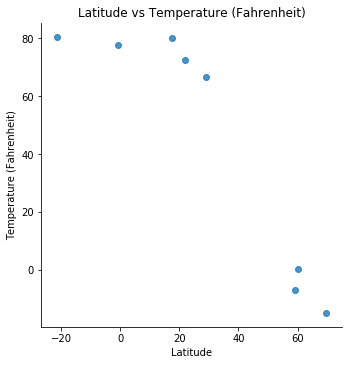

In [126]:
# -----------------------------------------------------------------------------------
# Step 5: Generate charts.
#  1) Temperature (F) vs. Latitude
#  2) Humidity (%) vs. Latitude
#  3) Cloudiness (%) vs. Latitude
#  4) Wind Speed (mph) vs. Latitude
# -----------------------------------------------------------------------------------

# Chart 1: Temperature vs Latitude
latVsTemp_plot = sns.lmplot(x='Latitude', y='Temperature (Fahrenheit)', data=cleanedWeather_df,\
                           fit_reg=False)
plt.title("Latitude vs Temperature (Fahrenheit)")
plt.show()